## Generic way to find wikidata subsets from `instance of`

https://phabricator.wikimedia.org/T291205

https://wikitech.wikimedia.org/wiki/User:AKhatun/Wikidata_Subgraph_Analysis

### Set up Spark

In [3]:
import wmfdata
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import numpy as np
import pandas as pd
from statistics import mean
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
import plotly.express as px
import plotly

In [ ]:
spark = wmfdata.spark.get_session(type='yarn-large', app_name="wdqs-analysis", 
                                  extra_settings={
                                             "spark.driver.memory": "16g",
                                            "spark.executor.memory": "16g",
                                            "spark.sql.shuffle.partitions": 1024
                                  }
                                 )

In [3]:
from pyspark.sql.functions import explode, col
import pyspark.sql.functions as F

## Utils

In [4]:
## WIKIDATA
date = "20211011"
from_clause = f"from discovery.wikibase_rdf where date={date} and wiki='wikidata'"

wd = 'http://www.wikidata.org/entity/'
wdt = 'http://www.wikidata.org/prop/direct/'
p31 = wdt+'P31'

In [5]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

def get_results(query, col_list):
    endpoint_url = "https://query.wikidata.org/sparql"
    user_agent = "akhatun-ctr-wdqs"
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    results = pd.json_normalize(results['results']['bindings'])
    
    if len(results)==0:
        return "Empty Df"
        
    col_list_value = [col+".value" for col in col_list]
    col_map = {col+".value":col for col in col_list}
    return results[col_list_value].rename(columns = col_map)

## Total triples

In [6]:
WD = spark.sql(f"""select * {from_clause}""")

In [269]:
total_triples = WD.count()
total_triples

13208971680

## List of all `instance of` items

In [9]:
instance_df = spark.sql(f"""
                            select object as instance, count(*) as count
                            {from_clause}
                            and predicate = '<{p31}>'
                            group by object
                        """)

In [24]:
instance_df.count()

82919

In [73]:
instance_pdf = instance_df.toPandas()

In [74]:
instance_pdf['code'] = instance_pdf['instance'].apply(lambda x: x.split('/')[-1][:-1])
instance_pdf = instance_pdf.sort_values('count', ascending=False)

In [45]:
instance_pdf.info(verbose=True, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82919 entries, 29769 to 82918
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   instance  82919 non-null  object
 1   count     82919 non-null  int64 
 2   code      82919 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.5+ MB


In [13]:
instance_pdf

instance     count       code
0      <http://www.wikidata.org/entity/Q13442814>  37362641  Q13442814
1             <http://www.wikidata.org/entity/Q5>   9315444         Q5
2       <http://www.wikidata.org/entity/Q4167836>   4840195   Q4167836
3           <http://www.wikidata.org/entity/Q523>   3296372       Q523
4         <http://www.wikidata.org/entity/Q16521>   3180248     Q16521
...                                           ...       ...        ...
82914  <http://www.wikidata.org/entity/Q57711694>         1  Q57711694
82915  <http://www.wikidata.org/entity/Q73404269>         1  Q73404269
82916   <http://www.wikidata.org/entity/Q5051306>         1   Q5051306
82917   <http://www.wikidata.org/entity/Q1148018>         1   Q1148018
82918   <http://www.wikidata.org/entity/Q2517832>         1   Q2517832

[82919 rows x 3 columns]

In [75]:
instance_pdf.to_csv('all_instances.csv', index=False)

In [10]:
instance_pdf = pd.read_csv('all_instances.csv')

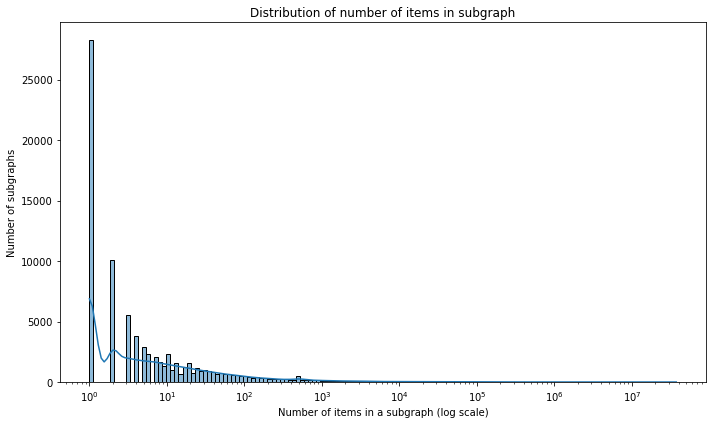

In [78]:
plt.figure(figsize=(10,6))
sns.histplot(instance_pdf['count'], kde=True, log_scale=True)
plt.xlabel('Number of items in a subgraph (log scale)')
plt.ylabel('Number of subgraphs')
plt.title('Distribution of number of items in subgraph')
plt.tight_layout()
plt.savefig('number_of_groups_vs_number_of_items.png')

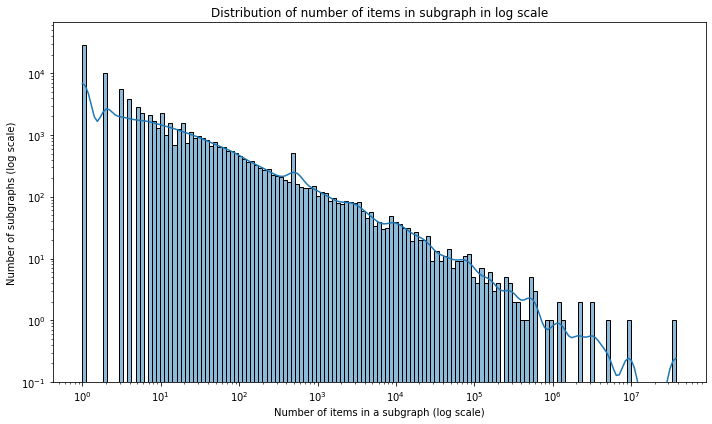

In [77]:
plt.figure(figsize=(10,6))
g = sns.histplot(instance_pdf['count'], kde=True, log_scale=(True, True))
plt.xlabel('Number of items in a subgraph (log scale)')
plt.ylabel('Number of subgraphs (log scale)')
plt.title('Distribution of number of items in subgraph in log scale')
g.axes.set_ylim(0.1,None)
plt.tight_layout()
plt.savefig('number_of_groups_vs_number_of_items_log.png')

In [ ]:
# sns.histplot(instance_pdf['count'], kde=True)

In [302]:
len(instance_pdf), len(instance_pdf[instance_pdf['count']==1]), len(instance_pdf[instance_pdf['count']>1]), len(instance_pdf[instance_pdf['count']>1000])

(82919, 28317, 54602, 1712)

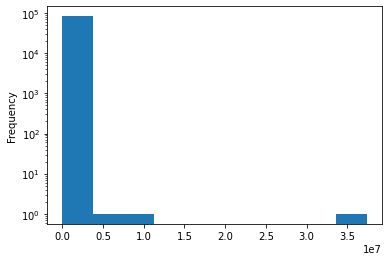

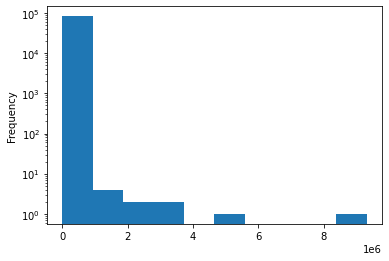

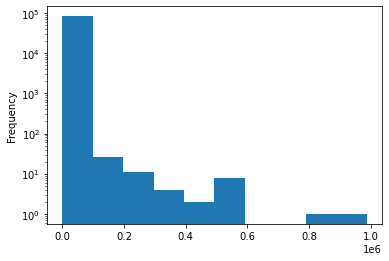

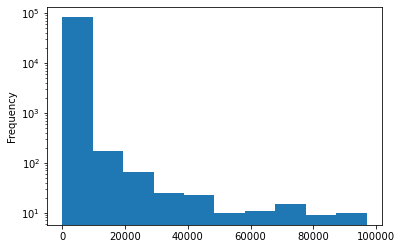

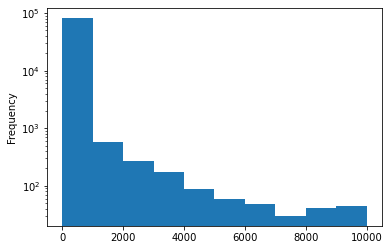

In [67]:
instance_pdf['count'].plot.hist(log=True)
plt.show()
instance_pdf['count'].iloc[1:].plot.hist(log=True)
plt.show()
instance_pdf[instance_pdf['count']<=1e6]['count'].plot.hist(log=True)
plt.show()
instance_pdf[instance_pdf['count']<=1e5]['count'].plot.hist(log=True)
plt.show()
instance_pdf[instance_pdf['count']<=1e4]['count'].plot.hist(log=True)
plt.show()

In [14]:
wd_instances = instance_pdf[instance_pdf['count']>1e4].code.values.tolist()
wd_instances = ['wd:'+insatnce for insatnce in wd_instances]
wd_instances = ' '.join(wd_instances)

In [87]:
query = """
            SELECT ?uri ?uriLabel
            WHERE 
            {
              VALUES ?uri { %s }
              SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
            }
        """ % wd_instances

labels = get_results(query, ['uri', 'uriLabel'])

In [89]:
labels['code'] = labels['uri'].apply(lambda x: x.split('/')[-1])

In [95]:
top_instances = pd.merge(instance_pdf, labels, on="code").drop(columns=['instance', 'uri']).rename(columns={'uriLabel':'label'})[['code','label','count']]
len(top_instances)

392

In [99]:
top_instances['perc_of_entities'] = top_instances['count']*100/94000000

In [154]:
top_instances.to_csv('top_instances.csv', index=False)

In [11]:
top_instances = pd.read_csv('top_instances.csv')

In [10]:
top_instances.head(50)

code                             label     count  perc_of_entities
0   Q13442814                 scholarly article  37362641         39.747490
1          Q5                             human   9315444          9.910047
2    Q4167836                Wikimedia category   4840195          5.149144
3        Q523                              star   3296372          3.506779
4      Q16521                             taxon   3180248          3.383243
5        Q318                            galaxy   2098557          2.232507
6    Q7318358                    review article   2087896          2.221166
7    Q4167410     Wikimedia disambiguation page   1359804          1.446600
8      Q11173                 chemical compound   1223387          1.301476
9       Q7187                              gene   1196361          1.272724
10      Q8054                           protein    986599          1.049573
11  Q11266439                Wikimedia template    845852          0.899843
12  Q13100073   village-level division in China    588477          0.626039
13     Q79007                            street    578926          0.615879
14    Q486972                  human settlement    563958          0.599955
15   Q3305213                          painting    539468          0.573902
16      Q8502                          mountain    525553          0.559099
17    Q871232                         editorial    512949          0.545690
18  Q13433827              encyclopedia article    512141          0.544831
19   Q2668072                        collection    500968          0.532945
20    Q101352                       family name    481450          0.512181
21      Q4022                             river    399552          0.425055
22     Q30612                    clinical trial    356838          0.379615
23   Q1931185         astronomical radio source    354111          0.376714
24  Q13406463            Wikimedia list article    334939          0.356318
25     Q54050                              hill    327277          0.348167
26   Q1457376             eclipsing binary star    292232          0.310885
27  Q17633526                  Wikinews article    286950          0.305266
28   Q2247863           high proper-motion star    284830          0.303011
29       Q532                           village    274840          0.292383
30    Q482994                             album    269095          0.286271
31     Q41176                          building    265925          0.282899
32     Q11424                              film    263070          0.279862
33     Q23397                              lake    260135          0.276739
34      Q3863                          asteroid    247441          0.263235
35     Q16970                   church building    211291          0.224778
36      Q3947                             house    197736          0.210357
37   Q4830453                          business    193858          0.206232
38  Q47150325      calendar day of a given year    189366          0.201453
39   Q2782326                       case report    187265          0.199218
40    Q355304                       watercourse    174620          0.185766
41     Q83373                            quasar    168332          0.179077
42   Q7725634                     literary work    164860          0.175383
43  Q27020041                     sports season    158877          0.169018
44   Q3331189  version, edition, or translation    157486          0.167538
45      Q9842                    primary school    157451          0.167501
46  Q19389637              biographical article    151026          0.160666
47     Q23442                            island    148587          0.158071
48  Q18593264  item of collection or exhibition    147402          0.156811
49    Q811979           architectural structure    145957          0.155273

In [191]:
top_instances['perc_of_entities'].sum()

96.36367127659575

In [193]:
top_instances.iloc[:200]['perc_of_entities'].sum()

93.2769255319149

In [141]:
top_instances.iloc[150:200]

code                                              label  count  \
150   Q23894233                       Wikimedia templates category  34934   
151   Q59542487                             Wikimedia set category  34384   
152   Q99045339                                   written question  34278   
153     Q126807                                       kindergarten  34213   
154      Q39594                                                bay  33545   
155  Q100532807                         Irish Statutory Instrument  33429   
156     Q187685                                    doctoral thesis  32725   
157   Q72802508                               emission-line galaxy  32567   
158   Q26887310                   association football team season  32270   
159   Q23925393                                              Douar  32023   
160       Q9826                                        high school  31269   
161      Q24862                                         short film  31161   
162   Q14204246                             Wikimedia project page  31029   
163   Q18918145                           academic journal article  30491   
164   Q15184295                                   Wikimedia module  29304   
165      Q11282                                        H II region  29288   
166      Q41298                                           magazine  28649   
167    Q4989906                                           monument  28491   
168   Q72803170                                      low-mass star  28152   
169   Q16510064                                     sporting event  28068   
170   Q23058136                                   cancer cell line  27960   
171    Q1681353                                                bog  27696   
172    Q1332364                      rotating ellipsoidal variable  27128   
173    Q2334719                                         legal case  27053   
174   Q72802977                     young stellar object candidate  26870   
175      Q34763                                          peninsula  26735   
176   Q46190676                                       tennis event  26646   
177      Q14350                                      radio station  26550   
178   Q21672098                                 village of Ukraine  26479   
179     Q820655                                        legislation  26437   
180     Q163740                             nonprofit organization  26427   
181   Q65954115                         State Bank of India branch  26369   
182    Q1195098                                               ward  26181   
183   Q67015940                    Government Boys' Primary School  26161   
184     Q189004                                            college  25707   
185       Q6999                                astronomical object  25629   
186     Q123705                                       neighborhood  25191   
187      Q16917                                           hospital  24950   
188      Q12280                                             bridge  24791   
189   Q61443650                                    sub post office  24761   
190       Q4421                                             forest  24642   
191    Q1248784                                            airport  24586   
192     Q852190                                          shipwreck  24497   
193    Q1491746                                       galaxy group  24493   
194    Q5707594                                       news article  24375   
195   Q26895936                      American football team season  23723   
196      Q30198                                              marsh  23651   
197   Q66826848  protein obsoleted in UniProtKB, SwissProt, TrEMBL  23629   
198     Q751876                                            château  23601   
199     Q155076                                   juridical person  23514   

     perc_of_entities  
150          0.037164  
151          0.036579  
152        

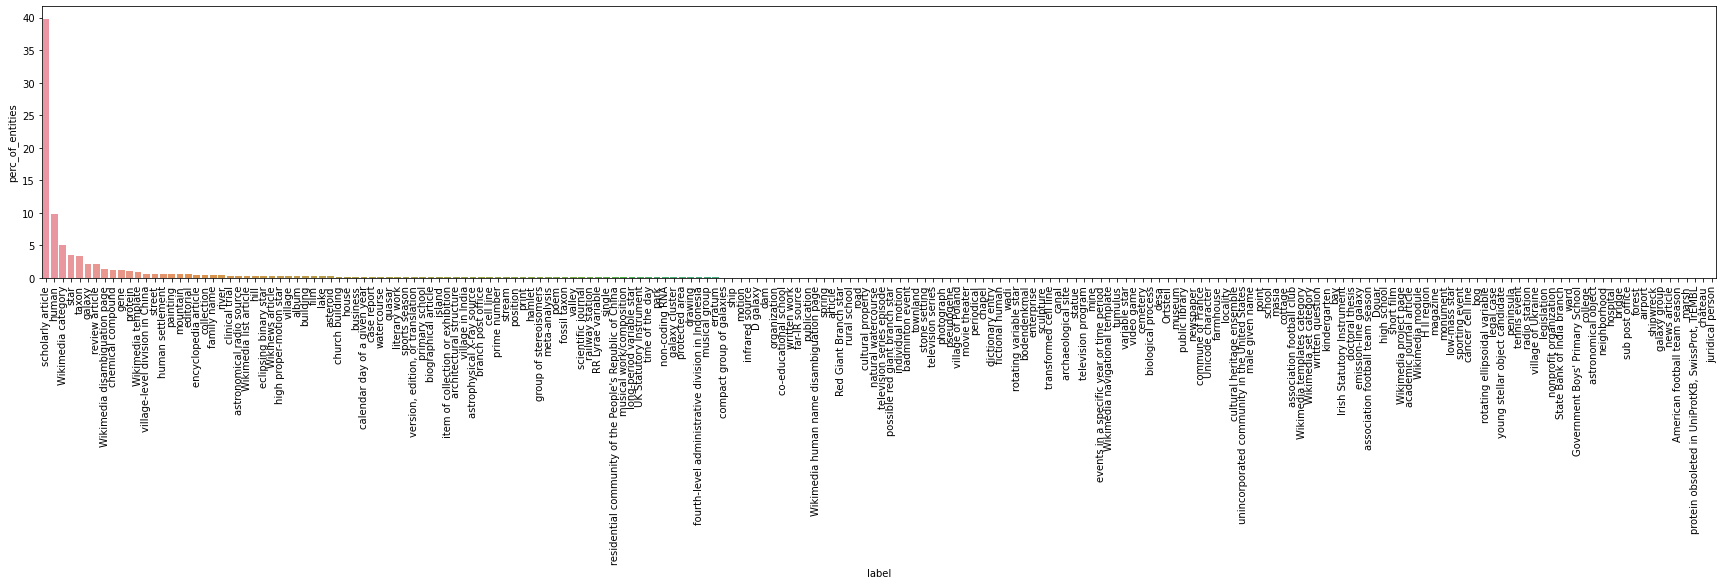

In [195]:
plt.figure(figsize=(30,5))
sns.barplot(data=top_instances.iloc[:200], y='perc_of_entities', x='label')
plt.xticks(rotation=90);

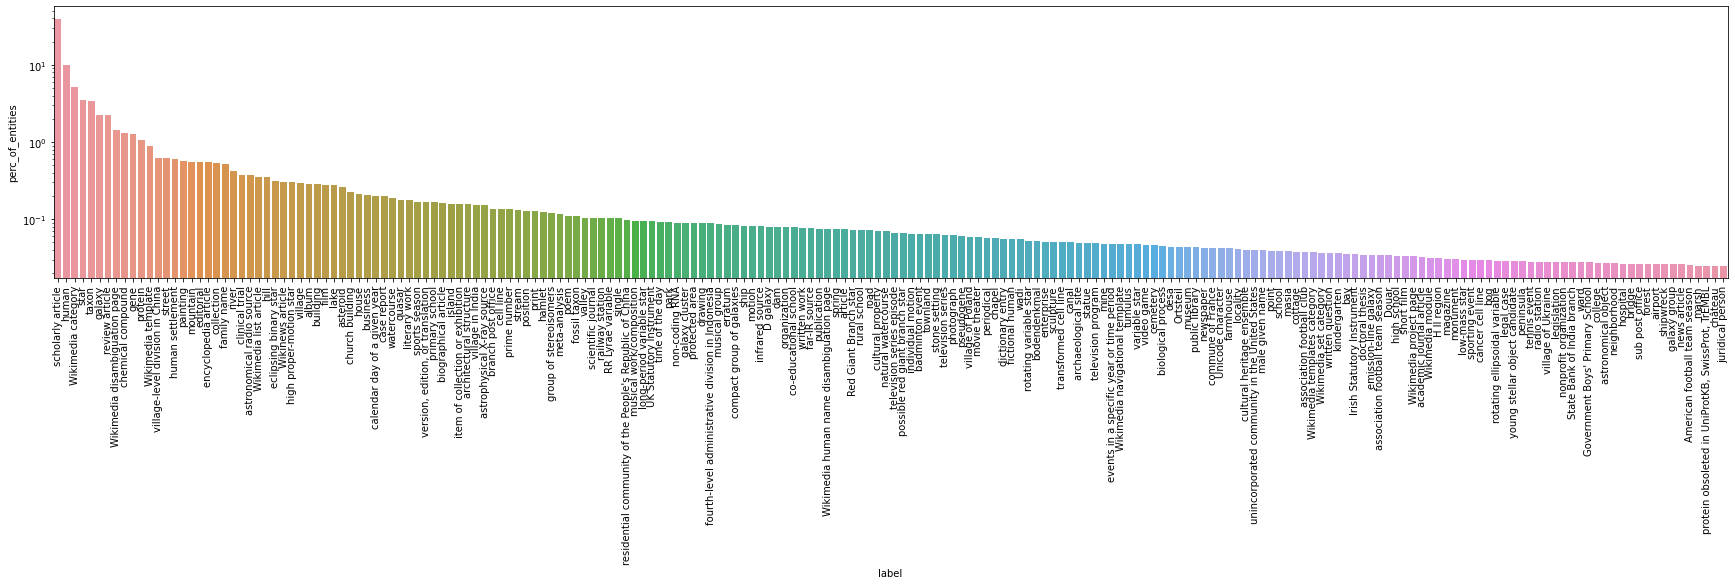

In [196]:
plt.figure(figsize=(30,5))
sns.barplot(data=top_instances.iloc[:200], y='perc_of_entities', x='label', log=True)
plt.xticks(rotation=90);

Text(0, 0.5, 'percent')

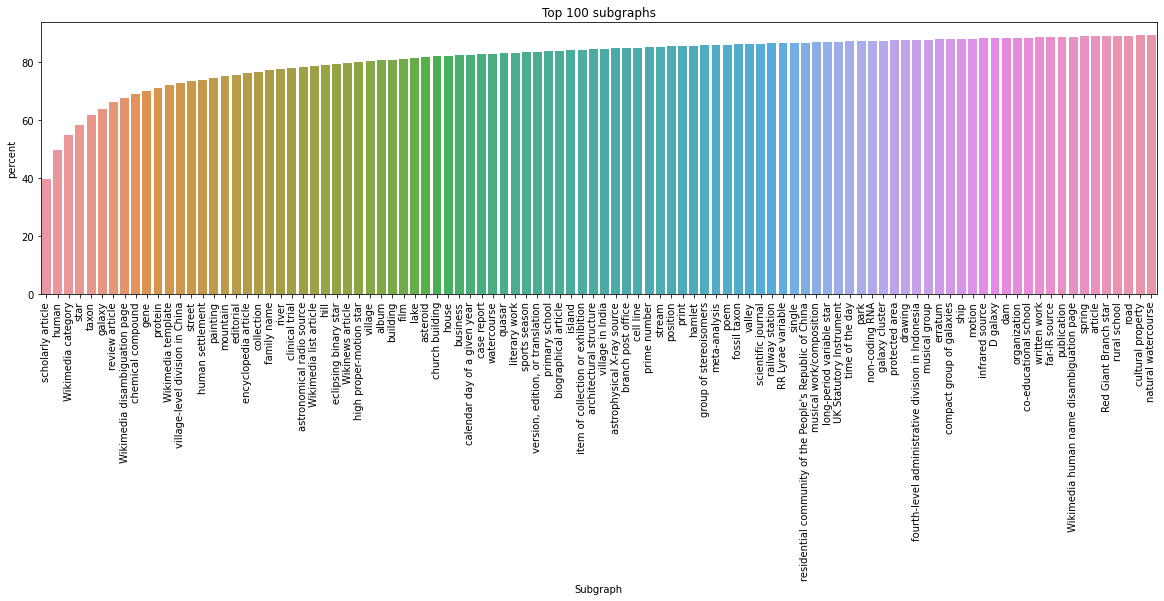

In [77]:
cumsum = top_instances['perc_of_entities'].iloc[:100].cumsum()

plt.figure(figsize=(20,5))
sns.barplot(data=top_instances.iloc[:100], y=cumsum, x='label')
plt.title('Top 100 subgraphs')
plt.xticks(rotation=90)
plt.xlabel('Subgraph')
plt.ylabel('percent')

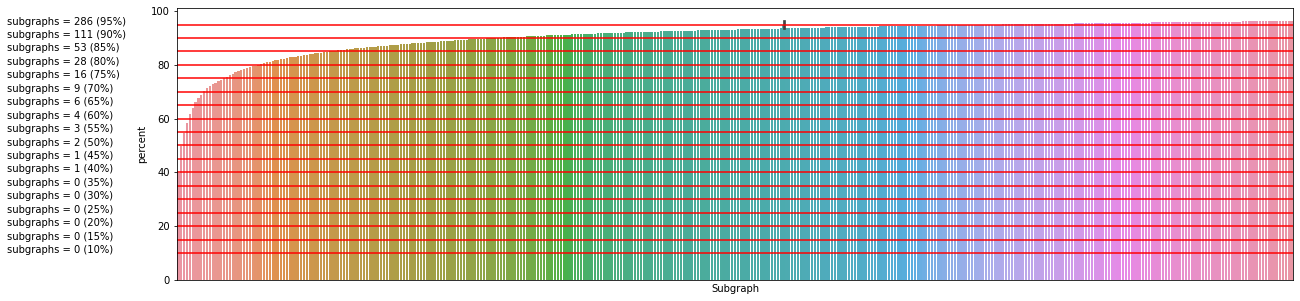

In [79]:
cumsum = top_instances['perc_of_entities'].cumsum()

plt.figure(figsize=(20,5))
sns.barplot(data=top_instances, y=cumsum, x='label')
plt.xticks([])
plt.xlabel('Subgraph')
plt.ylabel('percent')

for y in range(10,100,5):
    ln = len(top_instances[cumsum<=y])
    plt.axhline(y, color="red")
    text(-60,y, "subgraphs = %d (%d%%)" % (ln,y))

# Astronomical objects

at first I collected ~40 subclass from top 400 list manually realated to astronomical objects. Then realized I could SPARQL all subclasses and filter top ones from there.

```
SELECT (count(*) as ?count)
WHERE
{
  [] wdt:P31/wdt:P279* wd:Q6999.
}
```

##### `8,457,774` astronimical object items

In [224]:
8457774*100/94000000 ## ~9%

8.997631914893617

```
SELECT (count(*) as ?count)
WHERE
{
  [] wdt:P279* wd:Q6999.
}
```

**1349** sublcasses* of astronmical objects

In [12]:
query = """
        SELECT ?subclass ?subclassLabel
        WHERE
        {
          ?subclass wdt:P279* wd:Q6999.
          SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
        }
        """

astro_subclasses = get_results(query, ['subclass', 'subclassLabel']).rename(columns={'subclassLabel':'label'})
astro_subclasses['code'] = astro_subclasses['subclass'].apply(lambda x: x.split('/')[-1])

In [13]:
len(astro_subclasses)

1385

In [15]:
astro_subclasses.head(50)

subclass  \
0      http://www.wikidata.org/entity/Q6999   
1       http://www.wikidata.org/entity/Q427   
2       http://www.wikidata.org/entity/Q523   
3      http://www.wikidata.org/entity/Q8928   
4      http://www.wikidata.org/entity/Q9262   
5     http://www.wikidata.org/entity/Q27521   
6     http://www.wikidata.org/entity/Q41872   
7     http://www.wikidata.org/entity/Q60186   
8     http://www.wikidata.org/entity/Q71928   
9    http://www.wikidata.org/entity/Q131468   
10   http://www.wikidata.org/entity/Q179792   
11   http://www.wikidata.org/entity/Q185243   
12   http://www.wikidata.org/entity/Q193275   
13   http://www.wikidata.org/entity/Q193384   
14   http://www.wikidata.org/entity/Q202265   
15   http://www.wikidata.org/entity/Q203958   
16   http://www.wikidata.org/entity/Q237604   
17   http://www.wikidata.org/entity/Q249389   
18   http://www.wikidata.org/entity/Q285924   
19   http://www.wikidata.org/entity/Q430297   
20   http://www.wikidata.org/entity/Q462326   
21   http://www.wikidata.org/entity/Q505781   
22   http://www.wikidata.org/entity/Q595871   
23   http://www.wikidata.org/entity/Q845371   
24   http://www.wikidata.org/entity/Q986563   
25   http://www.wikidata.org/entity/Q987046   
26  http://www.wikidata.org/entity/Q1027098   
27  http://www.wikidata.org/entity/Q1054444   
28  http://www.wikidata.org/entity/Q1125935   
29  http://www.wikidata.org/entity/Q1133705   
30  http://www.wikidata.org/entity/Q1250298   
31  http://www.wikidata.org/entity/Q1297322   
32  http://www.wikidata.org/entity/Q1457669   
33  http://www.wikidata.org/entity/Q1504097   
34  http://www.wikidata.org/entity/Q1519541   
35  http://www.wikidata.org/entity/Q1931185   
36  http://www.wikidata.org/entity/Q2154519   
37  http://www.wikidata.org/entity/Q2311038   
38  http://www.wikidata.org/entity/Q2318940   
39  http://www.wikidata.org/entity/Q2327727   
40  http://www.wikidata.org/entity/Q2332332   
41  http://www.wikidata.org/entity/Q2557101   
42  http://www.wikidata.org/entity/Q2945326   
43  http://www.wikidata.org/entity/Q3132741   
44  http://www.wikidata.org/entity/Q3235978   
45  http://www.wikidata.org/entity/Q3414340   
46  http://www.wikidata.org/entity/Q3772242   
47  http://www.wikidata.org/entity/Q3850883   
48  http://www.wikidata.org/entity/Q4071774   
49  http://www.wikidata.org/entity/Q4391268   

                                          label      code  
0                           astronomical object     Q6999  
1                                   Kuiper belt      Q427  
2                                          star      Q523  
3                                 constellation     Q8928  
4                                      asterism     Q9262  
5                                  supercluster    Q27521  
6                           interstellar medium    Q41872  
7                                     meteorite    Q60186  
8                                   Parent body    Q71928  
9                                    white hole   Q131468  
10                               planetary ring   Q179792  
11                           gravitational lens   Q185243  
12                      small Solar System body   Q193275  
13                                  cosmic dust   Q193384  
14                              emission nebula   Q202265  
15                            reflection nebula   Q203958  
16                               accretion disc   Q237604  
17                              deep-sky object   Q249389  
18                  Gamma-ray burst progenitors   Q285924  
19                                   fixed star   Q430297  
20                                  rubble pile   Q462326  
21                          protoplanetary disk   Q505781  
22                                  star system   Q595871  
23                                         void   Q845371  
24                    interplanetary dust cloud   Q986563  
25                         astrophysical plasma   Q987046  
26               

Subclasses may not be directly dependable because with a long link, things start to seem irrelevant.
Atleast for scholarly articles, different kinds of cheeses are subclasses of scholarly articles with some indirect link.

## Merge all Astronomical Objects

In [14]:
instance_pdf[instance_pdf['code'].isin(astro_subclasses['code'])]['count'].sum() ## without overlap: 8,457,774

8457798

In [15]:
items = spark.sql(f"select subject as item, object as instance {from_clause} and predicate='<{p31}>'")

In [ ]:
temp = astro_subclasses[['subclass']]
temp['subclass'] = temp['subclass'].apply(lambda x: '<'+x+'>')

astro_subclasses_pydf = spark.createDataFrame(temp)

all_astro_items_df = items.join(astro_subclasses_pydf, items.instance == astro_subclasses_pydf.subclass).select('item').distinct()

In [90]:
all_astro_items_df.count()

8412914

### `8,412,914` astronimical object items, 8.9% of all entities

### Subgraph

In [17]:
## Related Astro Triples
astro_subgraph = WD.join(all_astro_items_df, WD.context==all_astro_items_df.item, 'inner').select("subject", "predicate", "object").distinct()

In [92]:
astro_subgraph.count()

1136682291

In [95]:
1136682291*100/total_triples

8.644919075325706

### `1,136,682,291` astronimical object related triples, 8.65% of all WD

In [96]:
all_astro_items_df, scholarly_items_df

(DataFrame[item: string], DataFrame[item: string])

In [97]:
len(instance_pdf)

82919

In [98]:
len(top_instances)

392

In [18]:
## all astro contains all astro subclasses
## also remove things that are almost completely in scholarly articles
to_remove = astro_subclasses['code'].values.tolist() + ['Q13442814', 'Q7318358', 'Q2782326', 'Q871232']

In [21]:
other_top_instances = top_instances[~top_instances['code'].isin(to_remove)]
len(other_top_instances)

339

In [103]:
other_top_instances.head(20)

code                            label    count  perc_of_entities
1          Q5                            human  9315444          9.910047
2    Q4167836               Wikimedia category  4840195          5.149144
4      Q16521                            taxon  3180248          3.383243
7    Q4167410    Wikimedia disambiguation page  1359804          1.446600
8      Q11173                chemical compound  1223387          1.301476
9       Q7187                             gene  1196361          1.272724
10      Q8054                          protein   986599          1.049573
11  Q11266439               Wikimedia template   845852          0.899843
12  Q13100073  village-level division in China   588477          0.626039
13     Q79007                           street   578926          0.615879
14    Q486972                 human settlement   563958          0.599955
15   Q3305213                         painting   539468          0.573902
16      Q8502                         mountain   525553          0.559099
18  Q13433827             encyclopedia article   512141          0.544831
19   Q2668072                       collection   500968          0.532945
20    Q101352                      family name   481450          0.512181
21      Q4022                            river   399552          0.425055
22     Q30612                   clinical trial   356838          0.379615
24  Q13406463           Wikimedia list article   334939          0.356318
25     Q54050                             hill   327277          0.348167

### Now list top 100 properties for each group (top 50 groups)

In [22]:
groups = [scholarly_subgraph, astro_subgraph]
group_names = ['scholarly articles', 'astronomical objects'] + other_top_instances.label.values.tolist()
group_codes = ['Q13442814', 'Q6999'] + other_top_instances.code.values.tolist()

In [23]:
for code in other_top_instances['code'].values:
    instances = spark.sql(f"""select subject as item {from_clause} and predicate = '<{p31}>' and object = '<{wd}{code}>'""")
    subgraph = WD.join(instances, WD.context==instances.item, 'inner').select("subject", "predicate", "object").distinct()
    groups.append(subgraph)

In [26]:
len(groups), len(group_names), len(group_codes)

(341, 341, 341)

In [27]:
start_time = None
limit = 50
all_group_props = pd.DataFrame(columns=['code', 'group', 'predicate', 'count'])

In [28]:
group_names[:limit]

['scholarly articles',
 'astronomical objects',
 'human',
 'Wikimedia category',
 'taxon',
 'Wikimedia disambiguation page',
 'chemical compound',
 'gene',
 'protein',
 'Wikimedia template',
 'village-level division in China',
 'street',
 'human settlement',
 'painting',
 'mountain',
 'encyclopedia article',
 'collection',
 'family name',
 'river',
 'clinical trial',
 'Wikimedia list article',
 'hill',
 'Wikinews article',
 'village',
 'album',
 'building',
 'film',
 'lake',
 'church building',
 'house',
 'business',
 'calendar day of a given year',
 'watercourse',
 'literary work',
 'sports season',
 'version, edition, or translation',
 'primary school',
 'biographical article',
 'island',
 'item of collection or exhibition',
 'architectural structure',
 'village in India',
 'branch post office',
 'cell line',
 'prime number',
 'stream',
 'position',
 'print',
 'hamlet',
 'group of stereoisomers']

In [29]:
count = 1
for df, name, code in zip(groups[:limit], group_names[:limit], group_codes[:limit]):
    clear_output()
    if start_time:
        print('Previous runtime:',(time.time() - start_time)/60)
    print('Running group number:', count)
    count += 1
    
    start_time = time.time()
    prop_df = df.groupby('predicate').count().sort('count', ascending=False).limit(100).toPandas()
    prop_df['group'] = name
    prop_df['code'] = code
    all_group_props = all_group_props.append(prop_df)
    
all_group_props

Previous runtime: 21.60985574324926
Running group number: 50


code                   group  \
0   Q13442814      scholarly articles   
1   Q13442814      scholarly articles   
2   Q13442814      scholarly articles   
3   Q13442814      scholarly articles   
4   Q13442814      scholarly articles   
..        ...                     ...   
95  Q59199015  group of stereoisomers   
96  Q59199015  group of stereoisomers   
97  Q59199015  group of stereoisomers   
98  Q59199015  group of stereoisomers   
99  Q59199015  group of stereoisomers   

                                            predicate       count  
0                     <http://schema.org/description>  1324177494  
1                    <http://wikiba.se/ontology#rank>   796548842  
2   <http://www.w3.org/1999/02/22-rdf-syntax-ns#type>   796517035  
3          <http://www.w3.org/ns/prov#wasDerivedFrom>   714004622  
4                <http://www.wikidata.org/prop/P2860>   284538763  
..                                                ...         ...  
95               <http://www.wikidata.org/prop/P4964>         681  
96     <http://www.wikidata.org/prop/statement/P4964>         681  
97               <http://www.wikidata.org/prop/P2840>         615  
98     <http://www.wikidata.org/prop/statement/P2840>         615  
99        <http://www.wikidata.org/prop/direct/P2840>         614  

[4943 rows x 4 columns]

In [31]:
all_group_props.info(verbose=True, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4943 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   code       4943 non-null   object
 1   group      4943 non-null   object
 2   predicate  4943 non-null   object
 3   count      4943 non-null   object
dtypes: object(4)
memory usage: 193.1+ KB


In [32]:
all_group_props.to_csv('all_group_props.csv', index=False)

## Predicate Analysis

In [128]:
all_group_props

code                             group  \
4   Q13406463            Wikimedia list article   
5     Q486972                  human settlement   
34     Q79007                            street   
6       Q4022                             river   
7      Q23442                            island   
..        ...                               ...   
71   Q2668072                        collection   
70  Q18593264  item of collection or exhibition   
13     Q49008                      prime number   
49   Q2668072                        collection   
96   Q4830453                          business   

                                               predicate    count  
4                              <http://schema.org/about>   623379  
5                              <http://schema.org/about>  1389085  
34                             <http://schema.org/about>   143495  
6                              <http://schema.org/about>   747720  
7                              <http://schema.org/about>   322894  
..                                                   ...      ...  
71  <http://www.wikidata.org/prop/statement/value/P7104>     8030  
70  <http://www.wikidata.org/prop/statement/value/P7104>     4156  
13  <http://www.wikidata.org/prop/statement/value/P7316>   127544  
49  <http://www.wikidata.org/prop/statement/value/P7328>    88320  
96  <http://www.wikidata.org/prop/statement/value/P8687>    16407  

[4943 rows x 4 columns]

In [38]:
all_group_props = all_group_props.sort_values('predicate')

In [46]:
other_top_instances['group_serial'] = list(range(3,342))
other_top_instances

/home/akhatun/.conda/envs/2021-05-04T07.37.12_akhatun/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


code                          label    count  perc_of_entities  \
1          Q5                          human  9315444          9.910047   
2    Q4167836             Wikimedia category  4840195          5.149144   
4      Q16521                          taxon  3180248          3.383243   
7    Q4167410  Wikimedia disambiguation page  1359804          1.446600   
8      Q11173              chemical compound  1223387          1.301476   
..        ...                            ...      ...               ...   
387  Q1081138                  historic site    10165          0.010814   
388    Q46686                        reredos    10143          0.010790   
389    Q18127                   record label    10127          0.010773   
390  Q4414033       rural council of Ukraine    10099          0.010744   
391   Q310890                monotypic taxon    10080          0.010723   

     group_serial  
1               3  
2               4  
4               5  
7               6  
8               7  
..            ...  
387           337  
388           338  
389           339  
390           340  
391           341  

[339 rows x 5 columns]

In [158]:
all_group_props_info = all_group_props.merge(other_top_instances[['code','group_serial']].iloc[:48], on='code', how='outer')

def update_group_serial(df):
    if df['code'] == 'Q13442814':
        return 1
    elif df['code'] == 'Q6999':
        return 2
    else:
        return df['group_serial']

all_group_props_info['group_serial'] = all_group_props_info.apply(lambda x: update_group_serial(x), axis=1)
all_group_props_info['group_serial'] = all_group_props_info['group_serial'].astype(int)
all_group_props_info

code                   group  \
0     Q13406463  Wikimedia list article   
1     Q13406463  Wikimedia list article   
2     Q13406463  Wikimedia list article   
3     Q13406463  Wikimedia list article   
4     Q13406463  Wikimedia list article   
...         ...                     ...   
4938  Q13442814      scholarly articles   
4939  Q13442814      scholarly articles   
4940  Q13442814      scholarly articles   
4941  Q13442814      scholarly articles   
4942  Q13442814      scholarly articles   

                                                            predicate  \
0                                           <http://schema.org/about>   
1                                    <http://schema.org/dateModified>   
2                                     <http://schema.org/description>   
3                                      <http://schema.org/inLanguage>   
4                                        <http://schema.org/isPartOf>   
...                                                               ...   
4938                    <http://www.wikidata.org/prop/statement/P953>   
4939  <http://www.wikidata.org/prop/statement/value-normalized/P3181>   
4940   <http://www.wikidata.org/prop/statement/value-normalized/P356>   
4941  <http://www.wikidata.org/prop/statement/value-normalized/P8978>   
4942              <http://www.wikidata.org/prop/statement/value/P577>   

         count  group_serial  
0       623379            21  
1       334939            21  
2     23714609            21  
3       623378            21  
4       623378            21  
...        ...           ...  
4938    559098             1  
4939    232301             1  
4940  26924150             1  
4941    416139             1  
4942  37370891             1  

[4943 rows x 5 columns]

In [159]:
all_group_props_info = all_group_props_info.sort_values(['group_serial','count'], ascending=[True, False])
serial = list(range(1,101))*42
serial.extend(list(range(1,44))) ## the 43rd group has 43 predicates
serial.extend(list(range(1,101))*7)
print(len(serial))
all_group_props_info['group_predicate_serial'] = serial

4943


In [134]:
all_group_props_info.iloc[4200:4250]

code               group  \
4504  Q61443690  branch post office   
4507  Q61443690  branch post office   
4510  Q61443690  branch post office   
4508  Q61443690  branch post office   
4516  Q61443690  branch post office   
4526  Q61443690  branch post office   
4537  Q61443690  branch post office   
4513  Q61443690  branch post office   
4523  Q61443690  branch post office   
4534  Q61443690  branch post office   
4514  Q61443690  branch post office   
4524  Q61443690  branch post office   
4535  Q61443690  branch post office   
4500  Q61443690  branch post office   
4502  Q61443690  branch post office   
4503  Q61443690  branch post office   
4505  Q61443690  branch post office   
4506  Q61443690  branch post office   
4511  Q61443690  branch post office   
4517  Q61443690  branch post office   
4521  Q61443690  branch post office   
4527  Q61443690  branch post office   
4532  Q61443690  branch post office   
4538  Q61443690  branch post office   
4512  Q61443690  branch post office   
4522  Q61443690  branch post office   
4533  Q61443690  branch post office   
4501  Q61443690  branch post office   
4519  Q61443690  branch post office   
4529  Q61443690  branch post office   
4540  Q61443690  branch post office   
4542  Q61443690  branch post office   
4509  Q61443690  branch post office   
4515  Q61443690  branch post office   
4520  Q61443690  branch post office   
4525  Q61443690  branch post office   
4530  Q61443690  branch post office   
4536  Q61443690  branch post office   
4541  Q61443690  branch post office   
4518  Q61443690  branch post office   
4528  Q61443690  branch post office   
4531  Q61443690  branch post office   
4539  Q61443690  branch post office   
1612  Q21014462           cell line   
1602  Q21014462           cell line   
1611  Q21014462           cell line   
1608  Q21014462           cell line   
1614  Q21014462           cell line   
1623  Q21014462           cell line   
1655  Q21014462           cell line   

                                                predicate    count  \
4504                     <http://wikiba.se/ontology#rank>   775436   
4507    <http://www.w3.org/1999/02/22-rdf-syntax-ns#type>   775436   
4510           <http://www.w3.org/ns/prov#wasDerivedFrom>   645628   
4508         <http://www.w3.org/2000/01/rdf-schema#label>   129684   
4516                  <http://www.wikidata.org/prop/P281>   129187   
4526           <http://www.wikidata.org/prop/direct/P281>   129187   
4537        <http://www.wikidata.org/prop/statement/P281>   129187   
4513                  <http://www.wikidata.org/prop/P137>   129185   
4523           <http://www.wikidata.org/prop/direct/P137>   129185   
4534        <http://www.wikidata.org/prop/statement/P137>   129185   
4514                   <http://www.wikidata.org/prop/P17>   129184   
4524            <http://www.wikidata.org/prop/direct/P17>   129184   
4535         <http://www.wikidata.org/prop/statement/P17>   129184   
4500                     <http://schema.org/dateModified>   129183   
4502                          <http://schema.org/version>   129183   
4503              <http://wikiba.se/ontology#identifiers>   129183   
4505                <http://wikiba.se/ontology#sitelinks>   129183   
4506               <http://wikiba.se/ontology#statements>   129183   
4511                  <http://www.wikidata.org/prop/P127>   129183   
4517                   <http://www.wikidata.org/prop/P31>   129183   
4521           <http://www.wikidata.org/prop/direct/P127>   129183   
4527            <http://www.wikidata.org/prop/direct/P31>   129183   
4532        <http://www.wikidata.org/prop/statement/P127>   129183   
4538         <http://www.wikidata.org/prop/statement/P31>   129183   
4512                  <http://www.wikidata.org/prop/P131>   128891   
4522           <http://www.wikidata.org/prop/direct/P131>   128891   
4533        <http://www.wikidata.org/prop/statement/P131>   128891   
4501                      <http://schema.org/description>    

In [160]:
all_group_props_info['predicate_code'] = all_group_props_info['predicate'].apply(lambda x: x.split('/')[-1][:-1])

In [161]:
all_group_props_info['predicate'].nunique(), all_group_props_info['predicate_code'].nunique()

(1751, 556)

In [162]:
preds = all_group_props_info[all_group_props_info['predicate_code'].str.startswith('P')]['predicate_code'].unique().tolist()
preds = ['wd:'+pred for pred in preds]
predsStr = ' '.join(preds)

In [163]:
query = """
            SELECT ?uri ?uriLabel
            WHERE 
            {
              VALUES ?uri { %s }
              SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
            }
        """ % predsStr

labels = get_results(query, ['uri', 'uriLabel'])
labels

uri                           uriLabel
0    http://www.wikidata.org/entity/P2860                         cites work
1    http://www.wikidata.org/entity/P1545                     series ordinal
2    http://www.wikidata.org/entity/P2093                 author name string
3      http://www.wikidata.org/entity/P31                        instance of
4    http://www.wikidata.org/entity/P1476                              title
..                                    ...                                ...
534   http://www.wikidata.org/entity/P672                     MeSH tree code
535  http://www.wikidata.org/entity/P9712       Research Resource Identifier
536  http://www.wikidata.org/entity/P3827                     JSTOR topic ID
537  http://www.wikidata.org/entity/P1417  Encyclopædia Britannica Online ID
538    http://www.wikidata.org/entity/P61             discoverer or inventor

[539 rows x 2 columns]

In [164]:
labels['predicate_code'] = labels['uri'].apply(lambda x: x.split('/')[-1])

In [165]:
len(labels)

539

In [ ]:
all_group_props_info = pd.merge(all_group_props_info, labels, on="predicate_code", how="outer").drop(columns='uri').rename(columns={'uriLabel':'predicate_label'})

In [ ]:
all_group_props_info['predicate_label'] = all_group_props_info.apply(lambda row: row['predicate_code'] if pd.isnull(row['predicate_label']) else row['predicate_label'],axis=1)

In [176]:
all_group_props_info.iloc[300:305]

code                 group  \
300  Q13442814    scholarly articles   
301      Q6999  astronomical objects   
302      Q6999  astronomical objects   
303      Q6999  astronomical objects   
304         Q5                 human   

                                        predicate     count  group_serial  \
300     <http://www.wikidata.org/prop/direct/P31>  40375322             1   
301            <http://www.wikidata.org/prop/P31>  11752760             2   
302  <http://www.wikidata.org/prop/statement/P31>  11752760             2   
303     <http://www.wikidata.org/prop/direct/P31>   8458232             2   
304            <http://www.wikidata.org/prop/P31>   9319315             3   

     group_predicate_serial predicate_code predicate_label  
300                      15            P31     instance of  
301                      15            P31     instance of  
302                      16            P31     instance of  
303                      22            P31     instance of  
304                      11            P31     instance of

In [177]:
all_group_props_info = all_group_props_info[['code','group','group_serial','predicate','predicate_code','predicate_label','count','group_predicate_serial']]
all_group_props_info.to_csv('all_group_props_info.csv', index=False)

In [179]:
## Top predicate of each group
all_group_props_info[all_group_props_info['group_predicate_serial']==1]

code                             group  group_serial  \
0    Q13442814                scholarly articles             1   
3     Q4167836                Wikimedia category             4   
5     Q4167410     Wikimedia disambiguation page             6   
6       Q11173                 chemical compound             7   
9    Q11266439                Wikimedia template            10   
10   Q13100073   village-level division in China            11   
13    Q3305213                          painting            14   
14       Q8502                          mountain            15   
15   Q13433827              encyclopedia article            16   
17     Q101352                       family name            18   
18       Q4022                             river            19   
20   Q13406463            Wikimedia list article            21   
22   Q17633526                  Wikinews article            23   
27      Q23397                              lake            28   
41   Q56436498                  village in India            42   
44      Q49008                      prime number            45   
51       Q6999              astronomical objects             2   
90     Q811979           architectural structure            41   
92   Q61443690                branch post office            43   
102         Q5                             human             3   
111     Q79007                            street            12   
112    Q486972                  human settlement            13   
116   Q2668072                        collection            17   
119     Q30612                    clinical trial            20   
121     Q54050                              hill            22   
123       Q532                           village            24   
124    Q482994                             album            25   
125     Q41176                          building            26   
126     Q11424                              film            27   
128     Q16970                   church building            29   
129      Q3947                             house            30   
130   Q4830453                          business            31   
132    Q355304                       watercourse            33   
133   Q7725634                     literary work            34   
134  Q27020041                     sports season            35   
135   Q3331189  version, edition, or translation            36   
136      Q9842                    primary school            37   
137  Q19389637              biographical article            38   
138     Q23442                            island            39   
139  Q18593264  item of collection or exhibition            40   
145     Q47521                            stream            46   
146   Q4164871                          position            47   
147  Q11060274                             print            48   
148      Q5084                            hamlet            49   
149  Q59199015            group of stereoisomers            50   
157      Q7187                              gene             8   
158      Q8054                           protein             9   
252     Q16521                             taxon             5   
279  Q47150325      calendar day of a given year            32   
291  Q21014462                         cell line            44   

                                             predicate         predicate_code  \
0                      <http://schema.org/description>            description   
3                      <http://schema.org/description>            description   
5                      <http://schema.org/description>            description   
6                      <http://schema.org/description>            description   
9                      <http://schema.org/description>            description   
10                     <http://schema.org/description>            description   
13                     <http://schema.org/description>            descriptio

In [180]:
## Top predicate of each group
all_group_props_info[all_group_props_info['group_predicate_serial']==2]

code                             group  group_serial  \
4       Q16521                             taxon             5   
23        Q532                           village            24   
43   Q21014462                         cell line            44   
50   Q13442814                scholarly articles             1   
52          Q5                             human             3   
61      Q79007                            street            12   
62     Q486972                  human settlement            13   
66    Q2668072                        collection            17   
69      Q30612                    clinical trial            20   
71      Q54050                              hill            22   
74     Q482994                             album            25   
75      Q41176                          building            26   
76      Q11424                              film            27   
78      Q16970                   church building            29   
79       Q3947                             house            30   
80    Q4830453                          business            31   
82     Q355304                       watercourse            33   
83    Q7725634                     literary work            34   
84   Q27020041                     sports season            35   
85    Q3331189  version, edition, or translation            36   
86       Q9842                    primary school            37   
87   Q19389637              biographical article            38   
88      Q23442                            island            39   
89   Q18593264  item of collection or exhibition            40   
91   Q56436498                  village in India            42   
94      Q49008                      prime number            45   
95      Q47521                            stream            46   
96    Q4164871                          position            47   
97   Q11060274                             print            48   
98       Q5084                            hamlet            49   
99   Q59199015            group of stereoisomers            50   
103   Q4167836                Wikimedia category             4   
106     Q11173                 chemical compound             7   
107      Q7187                              gene             8   
108      Q8054                           protein             9   
109  Q11266439                Wikimedia template            10   
113   Q3305213                          painting            14   
114      Q8502                          mountain            15   
115  Q13433827              encyclopedia article            16   
118      Q4022                             river            19   
120  Q13406463            Wikimedia list article            21   
122  Q17633526                  Wikinews article            23   
127     Q23397                              lake            28   
131  Q47150325      calendar day of a given year            32   
140    Q811979           architectural structure            41   
142  Q61443690                branch post office            43   
151      Q6999              astronomical objects             2   
253   Q4167410     Wikimedia disambiguation page             6   
258  Q13100073   village-level division in China            11   
265    Q101352                       family name            18   

                                             predicate         predicate_code  \
4                      <http://schema.org/description>            description   
23                     <http://schema.org/description>            description   
43                     <http://schema.org/description>            description   
50                    <http://wikiba.se/ontology#rank>          ontology#rank   
52                    <http://wikiba.se/ontology#rank>          ontology#rank   
61                    <http://wikiba.se/ontology#rank>          ontology#rank   
62                    <http://wikiba.se/ontology#rank>          ontology#ran

In [181]:
## Top predicate of each group
all_group_props_info[all_group_props_info['group_predicate_serial']==3]

code                             group  group_serial  \
11       Q79007                            street            12   
12      Q486972                  human settlement            13   
19       Q30612                    clinical trial            20   
21       Q54050                              hill            22   
32      Q355304                       watercourse            33   
33     Q7725634                     literary work            34   
37    Q19389637              biographical article            38   
38       Q23442                            island            39   
49    Q59199015            group of stereoisomers            50   
56       Q11173                 chemical compound             7   
57        Q7187                              gene             8   
58        Q8054                           protein             9   
63     Q3305213                          painting            14   
64        Q8502                          mountain            15   
65    Q13433827              encyclopedia article            16   
68        Q4022                             river            19   
70    Q13406463            Wikimedia list article            21   
72    Q17633526                  Wikinews article            23   
73         Q532                           village            24   
77       Q23397                              lake            28   
81    Q47150325      calendar day of a given year            32   
100   Q13442814                scholarly articles             1   
101       Q6999              astronomical objects             2   
104      Q16521                             taxon             5   
105    Q4167410     Wikimedia disambiguation page             6   
110   Q13100073   village-level division in China            11   
141   Q56436498                  village in India            42   
143   Q21014462                         cell line            44   
144      Q49008                      prime number            45   
166    Q2668072                        collection            17   
175      Q41176                          building            26   
176      Q11424                              film            27   
178      Q16970                   church building            29   
179       Q3947                             house            30   
180    Q4830453                          business            31   
185    Q3331189  version, edition, or translation            36   
186       Q9842                    primary school            37   
190     Q811979           architectural structure            41   
192   Q61443690                branch post office            43   
195      Q47521                            stream            46   
197   Q11060274                             print            48   
198       Q5084                            hamlet            49   
250          Q5                             human             3   
251    Q4167836                Wikimedia category             4   
257   Q11266439                Wikimedia template            10   
272     Q482994                             album            25   
282   Q27020041                     sports season            35   
294    Q4164871                          position            47   
1312    Q101352                       family name            18   
1389  Q18593264  item of collection or exhibition            40   

                                              predicate  \
11                      <http://schema.org/description>   
12                      <http://schema.org/description>   
19                      <http://schema.org/description>   
21                      <http://schema.org/description>   
32                      <http://schema.org/description>   
33                      <http://schema.org/description>   
37                      <http://schema.org/description>   
38                      <http://schema.org/description>   
49                      <http://schema.org/description>   
56 

In [ ]:
all_group_props_info['group_w_serial'] = all_group_props_info['group'] + ' (' + all_group_props_info['group_serial'].astype(str) + ')'
all_group_props_info['group_serial_str'] = all_group_props_info['group_serial'].astype(str)
all_group_props_info['group_predicate_serial_str'] = all_group_props_info['group_predicate_serial'].astype(str)

### Predicate grouping

In [194]:
pred_joined = all_group_props_info.groupby(['predicate','predicate_label']).agg({'group_w_serial':','.join,
                                                                                 'group_serial_str':','.join,
                                                                                 'group_predicate_serial_str':','.join,
                                                                                 'group_predicate_serial':'sum',
                                                                                 'code':'count'
                                                                                }).reset_index().rename(columns={'code':'count'})
pred_joined = pred_joined.sort_values('group_predicate_serial')

In [202]:
pd.set_option('display.max_colwidth', None)

In [ ]:
ix=0
while(True):
    clear_output()
    display(pred_joined.iloc[ix:ix+50])
    input()
    ix+=50

In [207]:
pred_joined.head(2)

predicate     predicate_label  \
35  <http://www.wikidata.org/prop/P1215>  apparent magnitude   
84  <http://www.wikidata.org/prop/P161>   cast member          

              group_w_serial group_serial_str group_predicate_serial_str  \
35  astronomical objects (2)  2                6                           
84  film (27)                 27               6                           

    group_predicate_serial  count  
35  6                       1      
84  6                       1

In [200]:
len(pred_joined), len(pred_joined[pred_joined['count']==1]), len(pred_joined[pred_joined['count']>1])

(1751, 1156, 595)

In [211]:
pd.reset_option("^display")

In [213]:
pred_joined[pred_joined['count']>1][['predicate_label','count', 'group_serial_str', 'group_predicate_serial_str', 'group_w_serial']]\
    .sort_values('count', ascending=False).iloc[:50]

predicate_label  count  \
1                                         dateModified     50   
11                                 ontology#statements     50   
9                                        ontology#rank     50   
221                                        instance of     50   
6                                              version     50   
2                                          description     50   
14                                    rdf-schema#label     50   
737                                        instance of     50   
1350                                       instance of     50   
13                               22-rdf-syntax-ns#type     50   
16                                 prov#wasDerivedFrom     50   
8                                 ontology#identifiers     50   
10                                  ontology#sitelinks     50   
15                                       core#altLabel     46   
5                                                 name     45   
4                                             isPartOf     45   
3                                           inLanguage     45   
0                                                about     45   
1315                         Google Knowledge Graph ID     31   
508                          Google Knowledge Graph ID     31   
702                          Google Knowledge Graph ID     31   
1652                         Google Knowledge Graph ID     31   
185                          Google Knowledge Graph ID     31   
105                                            country     29   
1236                                           country     29   
625                                            country     29   
113                                              image     28   
1244                                             image     27   
633                                              image     26   
1676                                       Freebase ID     24   
382                                        Freebase ID     24   
527                                        Freebase ID     24   
253                                   Commons category     24   
770                                   Commons category     24   
1383                                  Commons category     24   
571   located in the administrative territorial entity     23   
48    located in the administrative territorial entity     23   
1180  located in the administrative territorial entity     23   
899                                        Freebase ID     23   
1512                                       Freebase ID     23   
765                                            part of     20   
1378                                           part of     20   
370                                coordinate location     20   
1500                               coordinate location     20   
887                                coordinate location     20   
1741                               coordinate location     20   
248                                            part of     19   
1096                              determination method     17   
1146                                     point in time     17   
1109                                     point in time     17   

                                       group_serial_str  \
1     1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
11    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
9     1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
221   1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
6     1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
2     1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
14    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
737   1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
1350  1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
13    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
16    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
8     1,2,3,4,5

### Predicate Label Grouping

In [214]:
all_group_props_info.head(2)

code                 group  group_serial  \
0  Q13442814    scholarly articles             1   
1      Q6999  astronomical objects             2   

                         predicate predicate_code predicate_label       count  \
0  <http://schema.org/description>    description     description  1324177494   
1  <http://schema.org/description>    description     description    53884562   

   group_predicate_serial            group_w_serial group_serial_str  \
0                       1    scholarly articles (1)                1   
1                       4  astronomical objects (2)                2   

  group_predicate_serial_str  
0                          1  
1                          4

In [226]:
all_group_props_info['group'].nunique(), all_group_props_info['group_w_serial'].nunique()

(50, 50)

In [239]:
pred_label_info = all_group_props_info.groupby(['predicate_label','group_serial', 'group_w_serial','group_serial_str'])\
                                      .agg({'count':'sum'}).reset_index()

In [240]:
pred_label_info.head(2)

predicate_label  group_serial            group_w_serial  \
0  22-rdf-syntax-ns#type             1    scholarly articles (1)   
1  22-rdf-syntax-ns#type             2  astronomical objects (2)   

  group_serial_str      count  
0                1  796517035  
1                2  117137727

In [241]:
pred_label_info['predicate_label'].nunique()

555

In [242]:
pred_label_info = pred_label_info.sort_values(['group_serial', 'count'], ascending=[True, False]).reset_index(drop=True)

In [243]:
pred_label_info.head(10)

predicate_label  group_serial          group_w_serial  \
0            description             1  scholarly articles (1)   
1             cites work             1  scholarly articles (1)   
2          ontology#rank             1  scholarly articles (1)   
3  22-rdf-syntax-ns#type             1  scholarly articles (1)   
4    prov#wasDerivedFrom             1  scholarly articles (1)   
5     author name string             1  scholarly articles (1)   
6         series ordinal             1  scholarly articles (1)   
7       publication date             1  scholarly articles (1)   
8                    DOI             1  scholarly articles (1)   
9            instance of             1  scholarly articles (1)   

  group_serial_str       count  
0                1  1324177494  
1                1   853611993  
2                1   796548842  
3                1   796517035  
4                1   714004622  
5                1   402917000  
6                1   154240107  
7                1   149468521  
8                1   134618905  
9                1   121126022

In [244]:
pred_label_info.groupby(['group_serial', 'group_w_serial']).agg({'count':'count'})

count
group_serial group_w_serial                              
1            scholarly articles (1)                    39
2            astronomical objects (2)                  39
3            human (3)                                 42
4            Wikimedia category (4)                    60
5            taxon (5)                                 41
6            Wikimedia disambiguation page (6)         44
7            chemical compound (7)                     40
8            gene (8)                                  42
9            protein (9)                               45
10           Wikimedia template (10)                   47
11           village-level division in China (11)      42
12           street (12)                               41
13           human settlement (13)                     41
14           painting (14)                             47
15           mountain (15)                             40
16           encyclopedia article (16)                 46
17           collection (17)                           41
18           family name (18)                          48
19           river (19)                                38
20           clinical trial (20)                       39
21           Wikimedia list article (21)               45
22           hill (22)                                 41
23           Wikinews article (23)                     44
24           village (24)                              43
25           album (25)                                42
26           building (26)                             44
27           film (27)                                 41
28           lake (28)                                 39
29           church building (29)                      43
30           house (30)                                43
31           business (31)                             44
32           calendar day of a given year (32)         49
33           watercourse (33)                          38
34           literary work (34)                        42
35           sports season (35)                        41
36           version, edition, or translation (36)     43
37           primary school (37)                       44
38           biographical article (38)                 48
39           island (39)                               39
40           item of collection or exhibition (40)     37
41           architectural structure (41)              46
42           village in India (42)                     38
43           branch post office (43)                   22
44           cell line (44)                            46
45           prime number (45)                         47
46           stream (46)                               41
47           position (47)                             44
48           print (48)                                43
49           hamlet (49)                               42
50           group of stereoisomers (50)               40

In [252]:
serial = []
for ix, pred_count in pred_label_info.groupby(['group_serial', 'group_w_serial']).agg({'count':'count'}).iterrows():
    num = pred_count['count']
    serial.extend(list(range(1,num+1)))

In [253]:
len(serial), len(pred_label_info)

(2121, 2121)

In [256]:
pred_label_info['group_predicate_serial'] = serial
pred_label_info['group_predicate_serial_str'] = pred_label_info['group_predicate_serial'].astype(str)

In [257]:
pred_label_info.head(10)

predicate_label  group_serial          group_w_serial  \
0            description             1  scholarly articles (1)   
1             cites work             1  scholarly articles (1)   
2          ontology#rank             1  scholarly articles (1)   
3  22-rdf-syntax-ns#type             1  scholarly articles (1)   
4    prov#wasDerivedFrom             1  scholarly articles (1)   
5     author name string             1  scholarly articles (1)   
6         series ordinal             1  scholarly articles (1)   
7       publication date             1  scholarly articles (1)   
8                    DOI             1  scholarly articles (1)   
9            instance of             1  scholarly articles (1)   

  group_serial_str       count  group_predicate_serial  \
0                1  1324177494                       1   
1                1   853611993                       2   
2                1   796548842                       3   
3                1   796517035                       4   
4                1   714004622                       5   
5                1   402917000                       6   
6                1   154240107                       7   
7                1   149468521                       8   
8                1   134618905                       9   
9                1   121126022                      10   

  group_predicate_serial_str  
0                          1  
1                          2  
2                          3  
3                          4  
4                          5  
5                          6  
6                          7  
7                          8  
8                          9  
9                         10

In [264]:
pred_label_info.to_csv('all_group_props_label_info.csv', index=False)

### Finally predicate label grouping analysis

In [270]:
pred_label_joined = pred_label_info.groupby(['predicate_label']) .agg({'group_w_serial':','.join,
                                                                         'group_serial_str':','.join,
                                                                         'group_predicate_serial_str':','.join,
                                                                         'group_predicate_serial':'sum',
                                                                         'group_serial':'count'
                                                                        }).reset_index().rename(columns={'group_serial':'count'})
pred_label_joined = pred_label_joined.sort_values('group_predicate_serial')

In [295]:
pd.reset_option("^display")

In [293]:
pd.set_option('display.max_colwidth', None)

In [ ]:
ix=0
while(True):
    clear_output()
    display(pred_joined.iloc[ix:ix+50])
    input()
    ix+=50

In [271]:
pred_label_joined.head(2)

predicate_label       group_w_serial group_serial_str  \
398                    minimum age  clinical trial (20)               20   
252  collection or exhibition size      collection (17)               17   

    group_predicate_serial_str  group_predicate_serial  count  
398                          3                       3      1  
252                          4                       4      1

In [272]:
len(pred_label_joined), len(pred_label_joined[pred_label_joined['count']==1]), len(pred_label_joined[pred_label_joined['count']>1])

(555, 345, 210)

In [273]:
all_group_props_info[(all_group_props_info['group_serial']==11) & (all_group_props_info['predicate_label']=='coordinate location')]

code                            group  group_serial  \
3177  Q13100073  village-level division in China            11   
3178  Q13100073  village-level division in China            11   
3179  Q13100073  village-level division in China            11   
3180  Q13100073  village-level division in China            11   

                                                predicate predicate_code  \
3177                  <http://www.wikidata.org/prop/P625>           P625   
3178        <http://www.wikidata.org/prop/statement/P625>           P625   
3179           <http://www.wikidata.org/prop/direct/P625>           P625   
3180  <http://www.wikidata.org/prop/statement/value/P625>           P625   

          predicate_label count  group_predicate_serial  \
3177  coordinate location   358                      39   
3178  coordinate location   358                      40   
3179  coordinate location   357                      41   
3180  coordinate location   356                      42   

                            group_w_serial group_serial_str  \
3177  village-level division in China (11)               11   
3178  village-level division in China (11)               11   
3179  village-level division in China (11)               11   
3180  village-level division in China (11)               11   

     group_predicate_serial_str  
3177                         39  
3178                         40  
3179                         41  
3180                         42

In [289]:
imp_pred = pred_label_joined[pred_label_joined['count']>1][['predicate_label','count', 'group_serial_str', 'group_predicate_serial_str', 'group_w_serial']]\
    .sort_values('count', ascending=False)

In [290]:
imp_pred.to_csv('VIP_preds_from_top50_groups.csv', index=False)

In [297]:
imp_pred.iloc[50:100]

predicate_label  count  \
515                             street address      8   
408                               native label      7   
224                                     author      7   
476                               published in      7   
347                       heritage designation      7   
286                        described by source      7   
427                              official name      7   
215                    applies to jurisdiction      7   
376                       located in time zone      6   
194                                    VIAF ID      6   
225                         author name string      6   
463                                 population      6   
61                                     GNIS ID      6   
338                                      genre      6   
533                      topic's main category      6   
508                                      sport      5   
444                                    page(s)      5   
319                                exact match      5   
269                          country of origin      5   
367                                     length      5   
512                                  stated as      5   
358                           inventory number      5   
493                     said to be the same as      5   
271                             criterion used      5   
214      appears in the heritage monument list      5   
513                    statement is subject of      5   
250                                 collection      4   
143                          OS grid reference      4   
221                                       area      4   
428                           official website      4   
547                                     volume      4   
135  National Heritage List for England number      4   
245                                 cites work      4   
477                                  publisher      4   
430                             ontology#badge      4   
371                         local dialing code      4   
332                             found in taxon      4   
435                         ontology#wikiGroup      4   
550                                      width      4   
406                                named after      4   
544                            valid in period      4   
402                   mouth of the watercourse      4   
274                              date of death      3   
549                             watershed area      3   
461                       place of publication      3   
234                                    catalog      3   
333                 full work available at URL      3   
472                        pronunciation audio      3   
149                  OpenStreetMap relation ID      3   
464                              position held      3   

            group_serial_str group_predicate_serial_str  \
515  12,17,26,29,30,37,41,43    11,36,21,29,10,12,28,19   
408      6,15,18,22,24,28,47        38,35,8,33,37,37,36   
224      1,16,20,23,34,36,38         18,23,36,37,6,10,7   
476      1,16,20,23,34,36,38         12,6,37,17,29,28,5   
347     13,21,22,26,29,30,41          37,45,26,8,12,8,8   
286       6,9,18,19,23,38,44        30,27,32,37,23,39,9   
427     11,12,26,30,31,41,49        9,19,38,39,28,34,38   
215     14,16,34,36,38,47,48        29,32,33,40,32,6,38   
376        11,13,24,39,42,49          10,17,16,29,19,25   
194         3,15,19,31,33,46          16,31,36,26,33,34   
225         1,16,20,25,36,38           6,27,32,42,27,37   
463         6,13,24,39,42,49          32,27,18,31,11,23   
61         15,19,22,28,39,46          23,28,25,27,27,21   
338         4,14,25,27,34,48           57,20,11,8,10,28   
533         6,10,18,21,32,47          21,35,46,33,21,25   
508            4,10,21,23,35             34,19,22,30,10   
444            1,16,18,20,38              13,25,41,38,9   
319              1,8,9,12,44             29,28,36,23,18   
26

# All Subgraph-Predicate Analysis of top 50 subgraphs at once

In [16]:
len(instance_pdf), len(top_instances)

(82919, 392)

In [18]:
## all astro contains all astro subclasses
## also remove things that are almost completely in scholarly articles (but keeping scholarly articles)
to_remove = astro_subclasses['code'].values.tolist() + ['Q7318358', 'Q2782326', 'Q871232']

In [19]:
other_top_instances = top_instances[~top_instances['code'].isin(to_remove)]
len(other_top_instances)

340

In [26]:
## Top 50 items are 84% of items in wikidata
top_instances.iloc[:50]['count'].sum()/940000.00

84.43467553191489

In [27]:
## Top 100 items are 89% of items in wikidata
top_instances.iloc[:100]['count'].sum()/940000.00

89.28306382978724

In [20]:
## Top 400 items are 96% of items in wikidata
print(len(top_instances))
top_instances['count'].sum()/940000.00

392


96.36367127659574

In [20]:
limit = 49 ## astro is 50th
subgraphs = ">','<".join([wd+item for item in other_top_instances.iloc[:limit]['code'].values.tolist()])

In [21]:
all_items = spark.sql(f"""
                        select object as subgraph, subject as item
                        {from_clause}
                        and predicate='<{p31}>'
                        and object in ('<{subgraphs}>')
                        """)

all_items = all_items.unionByName(all_astro_items_df.withColumn('subgraph',F.lit('<http://www.wikidata.org/entity/Q6999>')))
all_items

DataFrame[subgraph: string, item: string]

In [25]:
all_items.select('subgraph').distinct().count()

50

In [22]:
all_subgraphs = WD.join(all_items, WD.context == all_items.item, 'inner').drop('context', 'wiki', 'date')

pred2codeUDF = F.udf(lambda x: x.split('/')[-1][:-1]) ## from <http://wikidata.org/prop/direct/P90> to P90

all_subgraphs = all_subgraphs.withColumn('predicate_code', pred2codeUDF('predicate'))

all_subgraphs

DataFrame[subject: string, predicate: string, object: string, subgraph: string, item: string, predicate_code: string]

# Subgraph Size

In [37]:
## total triples in top 50 subgraphs ## took 30 minutes
triples = all_subgraphs.select('subject', 'predicate', 'object').distinct().count()

triples, triples*100/total_triples

(11284296417, 85.82154408434681)

In [ ]:
## total items in top 50 subgraphs ## 4 minutes
items = all_subgraphs.select('item').distinct().count()

items, items/940000.00

(79337202, 84.40127872340426)

In [ ]:
## Graph size for top 50 subgraphs
subgraph_size = all_subgraphs.groupby('subgraph').agg(F.countDistinct('item').alias('item_count'), 
                                                      F.countDistinct("subject", "predicate", "object").alias("triple_count")
                                                     ).toPandas()

In [ ]:
subgraph_size['triple_percentage'] = (subgraph_size['triple_count']*100/total_triples).round(3)
subgraph_size['item_percentage'] = (subgraph_size['item_count']*100/94000000).round(3)
subgraph_size['density'] = subgraph_size['triple_count']/subgraph_size['item_count']
subgraph_size['subgraph_code'] = subgraph_size['subgraph'].apply(lambda x: x.split('/')[-1][:-1])
subgraph_size = subgraph_size.merge(top_instances, left_on='subgraph_code', right_on='code', how='inner').drop(columns=['code','count','perc_of_entities'])
subgraph_size = subgraph_size[['subgraph', 'subgraph_code', 'label', 'item_count', 'triple_count', 'triple_percentage','item_percentage', 'density']]
subgraph_size = subgraph_size.sort_values('triple_count', ascending=False).reset_index(drop=True)
subgraph_size['subgraph_rank'] = list(range(1,len(subgraph_size)+1))
subgraph_size = subgraph_size.sort_values('item_count', ascending=False).reset_index(drop=True)
subgraph_size['item_rank'] = list(range(1,len(subgraph_size)+1))

In [110]:
subgraph_size.head(50)

subgraph subgraph_code  \
0   <http://www.wikidata.org/entity/Q13442814>     Q13442814   
1          <http://www.wikidata.org/entity/Q5>            Q5   
2       <http://www.wikidata.org/entity/Q6999>         Q6999   
3    <http://www.wikidata.org/entity/Q4167836>      Q4167836   
4      <http://www.wikidata.org/entity/Q16521>        Q16521   
5    <http://www.wikidata.org/entity/Q4167410>      Q4167410   
6      <http://www.wikidata.org/entity/Q11173>        Q11173   
7       <http://www.wikidata.org/entity/Q7187>         Q7187   
8       <http://www.wikidata.org/entity/Q8054>         Q8054   
9   <http://www.wikidata.org/entity/Q11266439>     Q11266439   
10  <http://www.wikidata.org/entity/Q13100073>     Q13100073   
11     <http://www.wikidata.org/entity/Q79007>        Q79007   
12    <http://www.wikidata.org/entity/Q486972>       Q486972   
13   <http://www.wikidata.org/entity/Q3305213>      Q3305213   
14      <http://www.wikidata.org/entity/Q8502>         Q8502   
15  <http://www.wikidata.org/entity/Q13433827>     Q13433827   
16   <http://www.wikidata.org/entity/Q2668072>      Q2668072   
17    <http://www.wikidata.org/entity/Q101352>       Q101352   
18      <http://www.wikidata.org/entity/Q4022>         Q4022   
19     <http://www.wikidata.org/entity/Q30612>        Q30612   
20  <http://www.wikidata.org/entity/Q13406463>     Q13406463   
21     <http://www.wikidata.org/entity/Q54050>        Q54050   
22  <http://www.wikidata.org/entity/Q17633526>     Q17633526   
23       <http://www.wikidata.org/entity/Q532>          Q532   
24    <http://www.wikidata.org/entity/Q482994>       Q482994   
25     <http://www.wikidata.org/entity/Q41176>        Q41176   
26     <http://www.wikidata.org/entity/Q11424>        Q11424   
27     <http://www.wikidata.org/entity/Q23397>        Q23397   
28     <http://www.wikidata.org/entity/Q16970>        Q16970   
29      <http://www.wikidata.org/entity/Q3947>         Q3947   
30   <http://www.wikidata.org/entity/Q4830453>      Q4830453   
31  <http://www.wikidata.org/entity/Q47150325>     Q47150325   
32    <http://www.wikidata.org/entity/Q355304>       Q355304   
33   <http://www.wikidata.org/entity/Q7725634>      Q7725634   
34  <http://www.wikidata.org/entity/Q27020041>     Q27020041   
35   <http://www.wikidata.org/entity/Q3331189>      Q3331189   
36      <http://www.wikidata.org/entity/Q9842>         Q9842   
37  <http://www.wikidata.org/entity/Q19389637>     Q19389637   
38     <http://www.wikidata.org/entity/Q23442>        Q23442   
39  <http://www.wikidata.org/entity/Q18593264>     Q18593264   
40    <http://www.wikidata.org/entity/Q811979>       Q811979   
41  <http://www.wikidata.org/entity/Q56436498>     Q56436498   
42  <http://www.wikidata.org/entity/Q61443690>     Q61443690   
43  <http://www.wikidata.org/entity/Q21014462>     Q21014462   
44     <http://www.wikidata.org/entity/Q49008>        Q49008   
45     <http://www.wikidata.org/entity/Q47521>        Q47521   
46   <http://www.wikidata.org/entity/Q4164871>      Q4164871   
47  <http://www.wikidata.org/entity/Q11060274>     Q11060274   
48      <http://www.wikidata.org/entity/Q5084>         Q5084   
49  <http://www.wikidata.org/entity/Q59199015>     Q59199015   

                               label  item_count  triple_count  \
0                  scholarly article    37362641    6539020889   
1                              human     9315444     954536943   
2                astronomical object     8412914    1136682291   
3                 Wikimedia category     4840195     753127982   
4                              taxon     3180248     367926462   
5      Wikimedia disambiguation page     1359804     180124174   
6                  chemical compound     1223387      91228463   
7                               gene     1196361     122421508   
8                            protein      986599      88483828   
9                 Wikimedia template      845852     114308711   
10   village-level division in China      58847

In [111]:
subgraph_size.to_csv('subgraph_size.csv', index=False)

In [ ]:
subgraph_size = pd.read_csv('subgraph_size.csv')

In [59]:
## bubble chart of all subgraphs size!
## also density, triples/items

title = """
        <b>Subgraphs in Wikidata</b> (Entity count vs Subgraph size)
        <br>Density = triple_count/item_count
        <br><span style="font-size:15px;">This is an interactive graph created with plotly. Feel free to move it around, zoom in by dragging to create a rectangle, reset axes, and save snapshots as png.</span>
        """
fig = px.scatter(subgraph_size, size="triple_count", color="density",
                 hover_name="label", size_max=100,
                 x='triple_count',y='item_count',
                 hover_data=["subgraph_code", "triple_count", "triple_percentage", "item_count", "item_percentage", "density"],
                 width=1300, height=600,
                 color_continuous_scale='burg'
               )
fig.update_layout(title_text=title, title_x=0.5, margin_t=100)
fig.write_html("subgraph_stats.html")

In [110]:
subgraph_size = subgraph_size.sort_values('triple_count', ascending=False).reset_index(drop=True)

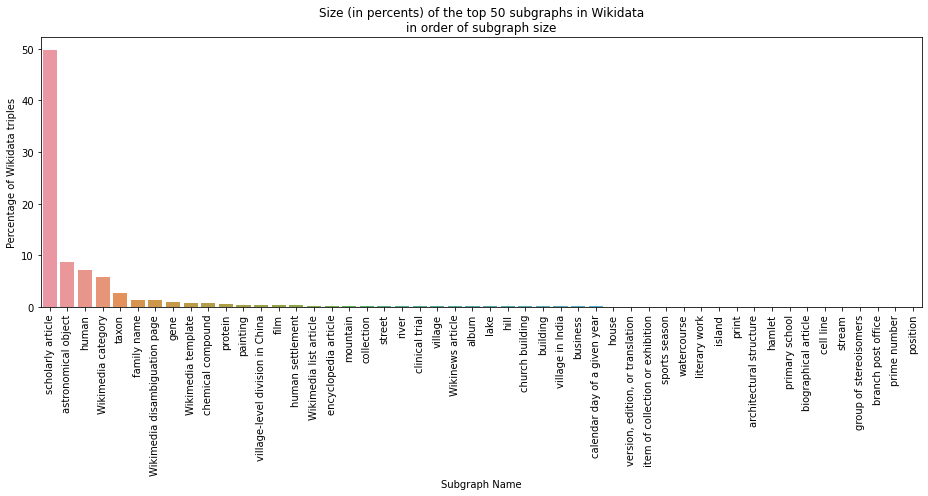

In [112]:
plt.figure(figsize=(13,7))
sns.barplot(data=subgraph_size, y='triple_percentage', x='label')
plt.xticks(rotation=90);
plt.title('Size (in percents) of the top 50 subgraphs in Wikidata\nin order of subgraph size')
plt.ylabel('Percentage of Wikidata triples')
plt.xlabel('Subgraph Name')
plt.tight_layout()
plt.savefig('top_50_subgraph_distribution_percents.png')

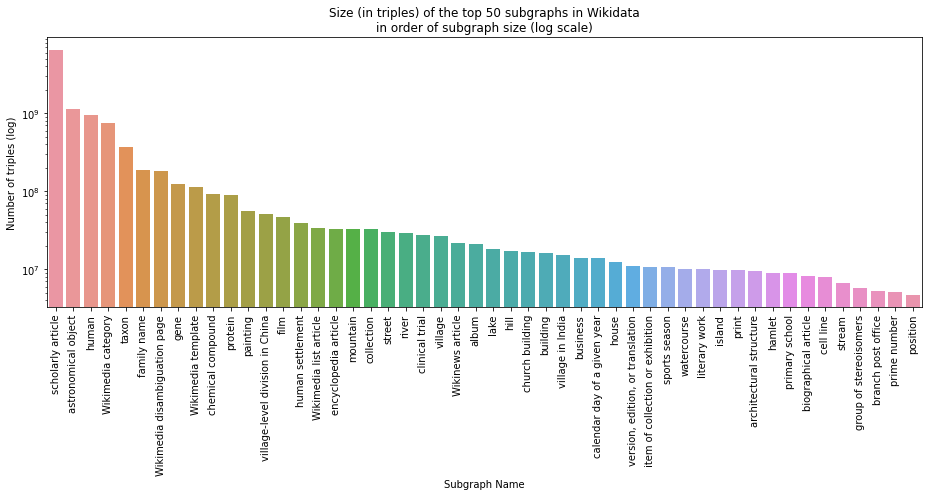

In [116]:
plt.figure(figsize=(13,7))
sns.barplot(data=subgraph_size, y='triple_count', x='label', log=True)
plt.xticks(rotation=90)
plt.title('Size (in triples) of the top 50 subgraphs in Wikidata\nin order of subgraph size (log scale)')
plt.ylabel('Number of triples (log)')
plt.xlabel('Subgraph Name')
plt.tight_layout()
plt.savefig('top_50_subgraph_distribution_triples.png')

Text(0, 0.5, 'Triple percent')

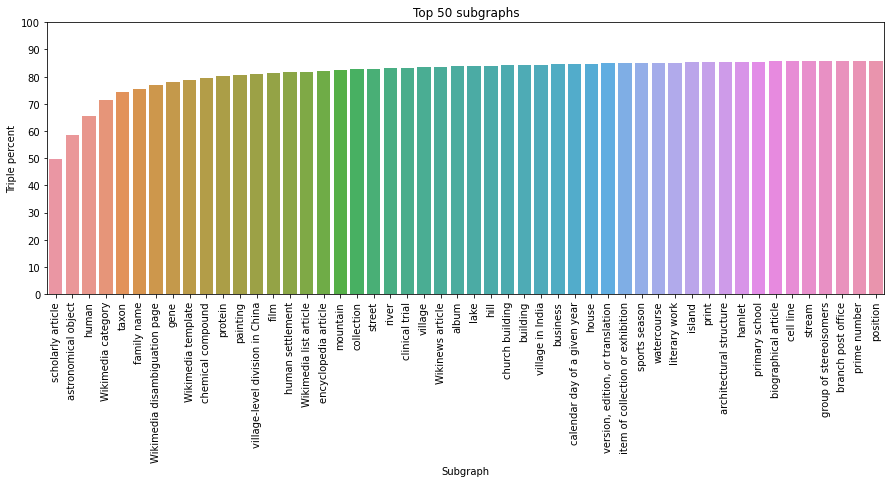

In [188]:
cumsum = subgraph_size['triple_percentage'].cumsum()

plt.figure(figsize=(15,5))
sns.barplot(data=subgraph_size, y=cumsum, x='label')
plt.title('Top 50 subgraphs')
plt.xticks(rotation=90)
plt.yticks(range(0,110,10))
plt.xlabel('Subgraph')
plt.ylabel('Triple percent')

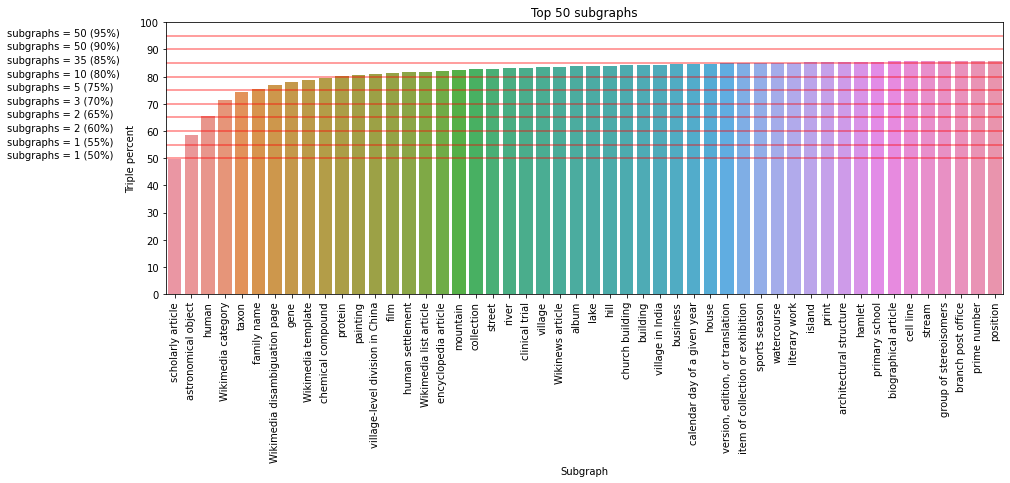

In [190]:
plt.figure(figsize=(15,5))
sns.barplot(data=subgraph_size.sort_values('triple_percentage', ascending=False), y=cumsum, x='label')
plt.title('Top 50 subgraphs')
plt.xticks(rotation=90)
plt.yticks(range(0,110,10))
plt.xlabel('Subgraph')
plt.ylabel('Triple percent')

for y in range(50,100,5):
    ln = len(subgraph_size[cumsum<=y])
    plt.axhline(y, color="red", alpha=0.5)
    text(-10,y, "subgraphs = %d (%d%%)" % (ln,y))

# Growth rate of all subgraphs

In [ ]:
to_remove = astro_subclasses['code'].values.tolist() + ['Q7318358', 'Q2782326', 'Q871232']
other_top_instances = top_instances[~top_instances['code'].isin(to_remove)]
limit = 49 ## astro is 50th
other_top_instances['wd_code'] = other_top_instances['code'].apply(lambda x: "<"+wd+x+">")
limited_other_top_instances = other_top_instances.iloc[:limit]


temp = astro_subclasses[['subclass']]
temp['wd_code'] = temp['subclass'].apply(lambda x: '<'+x+'>')
temp['code'] = 'Q6999'

req_instances = pd.concat([limited_other_top_instances[['wd_code', 'code']], temp[['wd_code', 'code']]])

req_instances_pydf = spark.createDataFrame(req_instances)

In [36]:
dates = ['20210927', '20211004','20211011','20211018']
date_dfs = []

for date in dates:
    
    WD = spark.sql(f"""select * from discovery.wikibase_rdf where date={date} and wiki='wikidata'""")
    
    items = spark.sql(f"""select subject as item, object as instance 
                       from discovery.wikibase_rdf where date={date} and wiki='wikidata'
                       and predicate='<{p31}>'""")

    all_items = items.join(req_instances_pydf, items.instance == req_instances_pydf.wd_code)\
                        .select('item', 'code').distinct()
    
    all_subgraphs = WD.join(all_items, WD.context == all_items.item, 'inner').drop('context', 'wiki', 'date')

    ## Graph size for top 50 subgraphs
    subgraph_size = all_subgraphs.groupby('code').agg(F.countDistinct('item').alias('item_count'), 
                                                      F.countDistinct("subject", "predicate", "object").alias("triple_count")
                                                     ).toPandas()
    subgraph_size['date'] = date
    
    date_dfs.append(subgraph_size)

In [37]:
growth_df = pd.concat(date_dfs)

In [39]:
growth_df.to_csv('growth_df.csv', index=False)

In [ ]:
growth_df = pd.read_csv('growth_df.csv')

In [7]:
growth_df['date'] = pd.to_datetime(growth_df['date'], format='%Y%m%d')

In [10]:
growth_df = pd.merge(top_instances[['code', 'label']], growth_df, on='code')

In [28]:
growth_df

code  item_count  triple_count      date
0    Q13406463      335135      33806231  20210927
1     Q4830453      194063      14128542  20210927
2    Q13433827      512232      33380376  20210927
3    Q13442814    37370825    6543481682  20210927
4      Q482994      269330      21215393  20210927
..         ...         ...           ...       ...
195      Q8054      986935      88541094  20211018
196     Q41176      267277      16402243  20211018
197      Q4022      399046      28907402  20211018
198     Q23397      260559      18190532  20211018
199      Q6999     8405941    1150843582  20211018

[200 rows x 4 columns]

[Stage 5:>                                                     (0 + 512) / 1024]

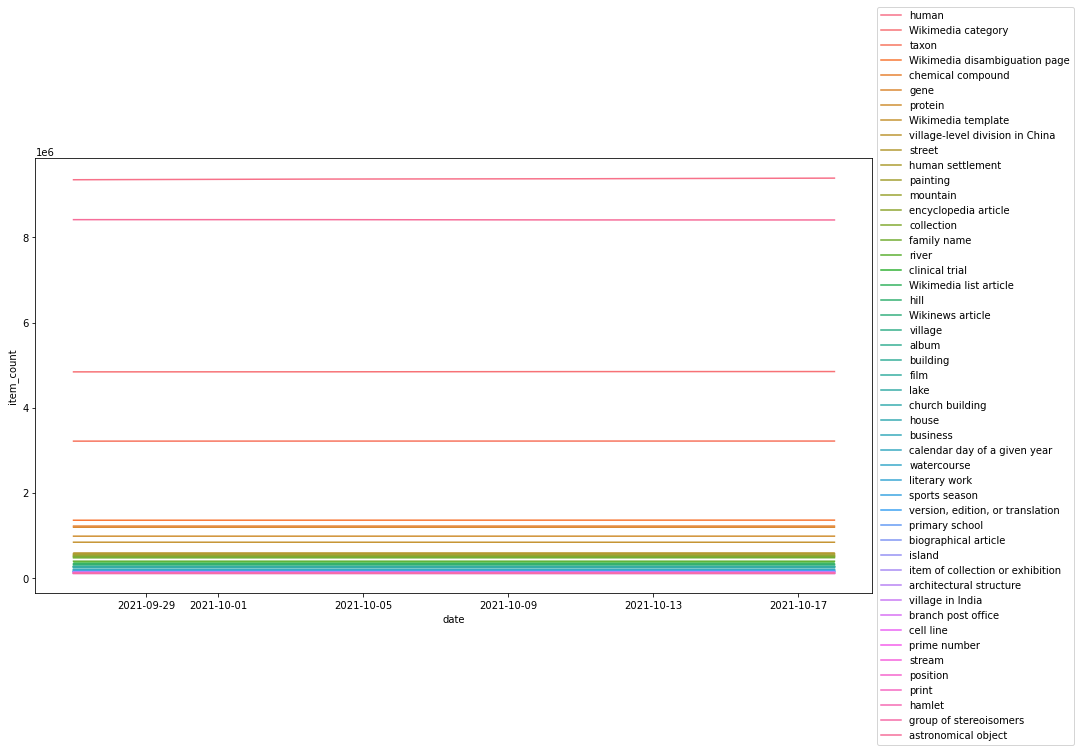

In [169]:
plt.figure(figsize=(15,8))
sns.lineplot(data=growth_df[growth_df['label']!='scholarly article'], x='date', y='item_count', hue='label')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [34]:
# px.line(growth_df,  x='date', y='item_count', color='label')
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def figures_to_html(figs, filename, others=None):
    '''Saves a list of plotly figures in an html file.

    Parameters
    ----------
    figs : list[plotly.graph_objects.Figure]
        List of plotly figures to be saved.

    filename : str
        File name to save in.

    '''
    import plotly.offline as pyo

    dashboard = open(filename, 'w')
    dashboard.write("<html><head></head><body>" + "\n")
    if others:
        dashboard.write(others+"<br/>"+"\n")

    add_js = True
    for fig in figs:

        inner_html = pyo.plot(
            fig, include_plotlyjs=add_js, output_type='div'
        )

        dashboard.write(inner_html)
        add_js = False

    dashboard.write("</body></html>" + "\n")

fig1 = px.line(growth_df,  x='date', y='item_count', color='label', labels={"label":"Subgraph"})\
            .for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
fig1.update_layout(title_x=0.5, title_text="Subgraph item count growth")
fig2 = px.line(growth_df,  x='date', y='triple_count', color='label', labels={"label":"Subgraph"})\
            .for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
fig2.update_layout(title_x=0.5, title_text="Subgraph size (triple count) growth")
figures_to_html([fig1, fig2], "subgraph_growth_rate.html", 
                "<div style=\"font-size:15px;text-align:center;\">"
                "This is an interactive graph. Feel free to move it around, zoom in, and save snapshots as png.<br>"
                "Click on legend a item to remove it from the graph. Double click to only show that plot. "
                "You can select multiple subgraphs as well. Double click again to view all."
                "</div>")

# More subgraphs 90%

In [29]:
len(instance_pdf), len(top_instances)

(82919, 392)

In [200]:
top_instances.iloc[:50]['perc_of_entities'].sum(), top_instances.iloc[:100]['perc_of_entities'].sum(), \
top_instances.iloc[:200]['perc_of_entities'].sum(), top_instances['perc_of_entities'].sum()

(84.43467553191492, 89.28306382978724, 93.2769255319149, 96.36367127659575)

In [155]:
## all astro contains all astro subclasses
## also remove things that are almost completely in scholarly articles (but keeping scholarly articles)
to_remove = astro_subclasses['code'].values.tolist() + ['Q7318358', 'Q2782326', 'Q871232']

other_top_instances = top_instances[~top_instances['code'].isin(to_remove)]
len(other_top_instances)

340

In [156]:
subgraphs = ">','<".join([wd+item for item in other_top_instances['code'].values.tolist()])

In [157]:
full_items = spark.sql(f"""
                        select object as subgraph, subject as item
                        {from_clause}
                        and predicate='<{p31}>'
                        and object in ('<{subgraphs}>')
                        """)

full_items = full_items.unionByName(all_astro_items_df.withColumn('subgraph',F.lit('<http://www.wikidata.org/entity/Q6999>')))
full_items

DataFrame[subgraph: string, item: string]

In [206]:
full_items.select('subgraph').distinct().count()

341

In [158]:
full_subgraphs = WD.join(full_items, WD.context == full_items.item, 'inner').drop('context', 'wiki', 'date')
full_subgraphs

DataFrame[subject: string, predicate: string, object: string, subgraph: string, item: string]

In [209]:
## Graph size for top subgraphs
full_subgraph_size = full_subgraphs.groupby('subgraph').agg(F.countDistinct('item').alias('item_count'), 
                                                      F.countDistinct("subject", "predicate", "object").alias("triple_count")).toPandas()

In [ ]:
full_subgraph_size['triple_percentage'] = (full_subgraph_size['triple_count']*100/total_triples).round(3)
full_subgraph_size['item_percentage'] = (full_subgraph_size['item_count']*100/94000000).round(3)
full_subgraph_size['density'] = full_subgraph_size['triple_count']/full_subgraph_size['item_count']
full_subgraph_size['subgraph_code'] = full_subgraph_size['subgraph'].apply(lambda x: x.split('/')[-1][:-1])
full_subgraph_size = full_subgraph_size.merge(top_instances, left_on='subgraph_code', right_on='code', how='left').drop(columns=['code','count','perc_of_entities'])
full_subgraph_size = full_subgraph_size[['subgraph', 'subgraph_code', 'label', 'item_count', 'triple_count', 'triple_percentage','item_percentage', 'density']]
full_subgraph_size = full_subgraph_size.sort_values('item_count', ascending=False).reset_index(drop=True)
full_subgraph_size['item_rank'] = list(range(1,len(full_subgraph_size)+1))
full_subgraph_size = full_subgraph_size.sort_values('triple_count', ascending=False).reset_index(drop=True)
full_subgraph_size['subgraph_rank'] = list(range(1,len(full_subgraph_size)+1))
full_subgraph_size.to_csv('full_subgraph_size.csv', index=False)

In [ ]:
full_subgraph_size = pd.read_csv('full_subgraph_size.csv')

In [81]:
len(full_subgraph_size)

341

In [87]:
## bubble chart of all subgraphs size!
## also density, triples/items

title = """
        <b>Top 340 Subgraphs in Wikidata</b>
        <br>These form 90% of all Wikidata triples. Density = triple_count/item_count
        <br><span style="font-size:15px;">This is an interactive graph created with plotly. Feel free to move it around, zoom in by dragging to create a rectangle, reset axes, and save snapshots as png.</span>
        """
fig = px.scatter(full_subgraph_size, size="triple_count", color="density",
                 hover_name="label", size_max=100,
                 x='triple_count',y='item_count',
                 hover_data=["subgraph_code", "triple_count", "triple_percentage", "item_count", "item_percentage", "density"],
                 width=1300, height=600,
                 color_continuous_scale='Aggrnyl'
               )
fig.update_layout(title_text=title, title_x=0.5, margin_t=100)
fig.update_traces(marker=dict(line=dict(width=1,color='DarkSlateGrey')))
fig.write_html("subgraph_stats.html")

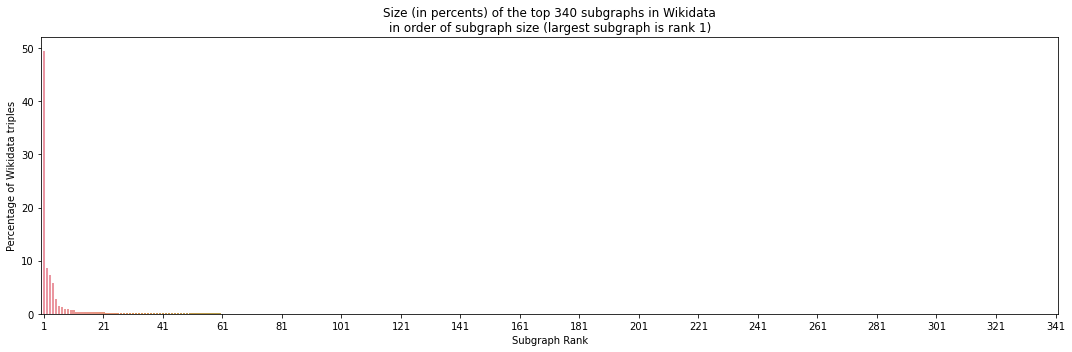

In [104]:
plt.figure(figsize=(15,5))
sns.barplot(data=full_subgraph_size, y='triple_percentage', x='subgraph_rank')
plt.xlim(-1, len(full_subgraph_size))
plt.xticks(ticks=range(0,341,20),labels=range(1,342,20));
plt.title('Size (in percents) of the top 340 subgraphs in Wikidata\nin order of subgraph size (largest subgraph is rank 1)')
plt.ylabel('Percentage of Wikidata triples')
plt.xlabel('Subgraph Rank')
plt.tight_layout()
plt.savefig('subgraph_distribution_percents.png')

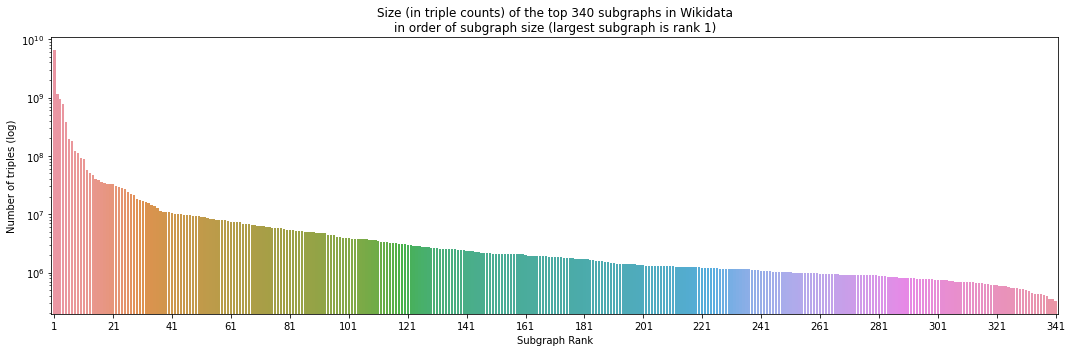

In [103]:
plt.figure(figsize=(15,5))
sns.barplot(data=full_subgraph_size, y='triple_count', x='subgraph_rank', log=True)
plt.xlim(-1, len(full_subgraph_size))
plt.xticks(ticks=range(0,341,20),labels=range(1,342,20));
plt.ylabel('Number of triples (log)')
plt.xlabel('Subgraph Rank')
plt.title('Size (in triple counts) of the top 340 subgraphs in Wikidata\nin order of subgraph size (largest subgraph is rank 1)')
plt.tight_layout()
plt.savefig('subgraph_distribution_triples.png')

Text(0, 0.5, 'Triple percent')

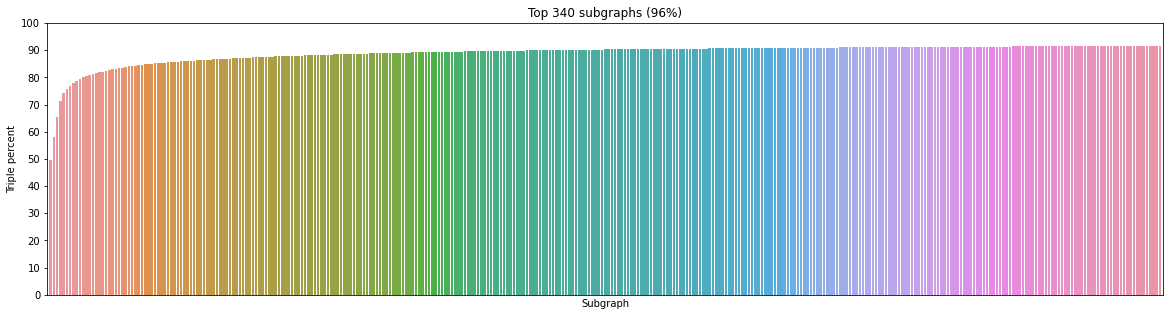

In [249]:
cumsum = full_subgraph_size['triple_percentage'].cumsum()

plt.figure(figsize=(20,5))
sns.barplot(data=full_subgraph_size, y=cumsum, x='subgraph_rank')
plt.title('Top 340 subgraphs (96%)')
plt.xlim(-1, len(full_subgraph_size))
plt.xticks([], rotation=90);
plt.yticks(range(0,110,10))
plt.xlabel('Subgraph')
plt.ylabel('Triple percent')

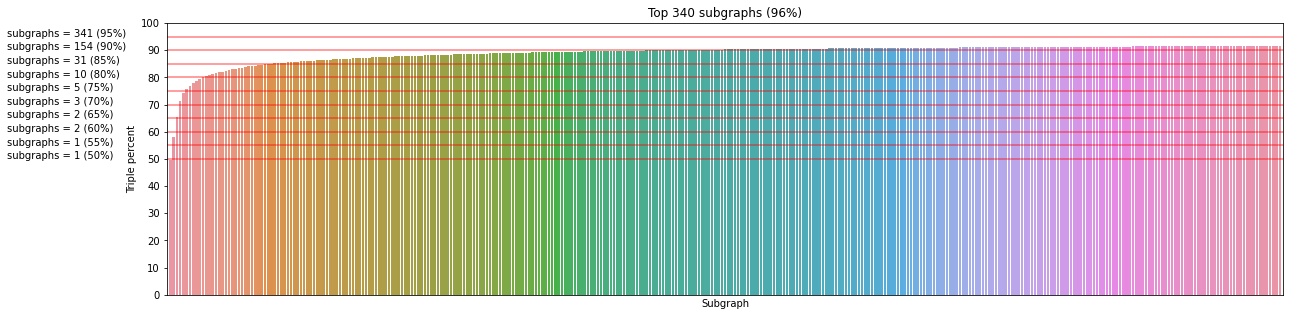

In [252]:
plt.figure(figsize=(20,5))
sns.barplot(data=full_subgraph_size, y=cumsum, x='subgraph_rank')
plt.title('Top 340 subgraphs (96%)')
plt.xlim(-1, len(full_subgraph_size))
plt.xticks([], rotation=90);
plt.yticks(range(0,110,10))
plt.xlabel('Subgraph')
plt.ylabel('Triple percent')

for y in range(50,100,5):
    ln = len(full_subgraph_size[cumsum<=y])
    plt.axhline(y, color="red", alpha=0.5)
    text(-50,y, "subgraphs = %d (%d%%)" % (ln,y))

In [323]:
full_items_count = full_items.select('item').distinct().count()
full_items_count, full_items_count*100/95000000

(87000857, 91.5798494736842)

In [325]:
full_triples_count = full_subgraphs.select("subject", "predicate", "object").distinct().count()
full_triples_count, full_triples_count*100/total_triples

(11976212996, 90.66726226791334)

# Direct triples vs statements
- nonwiki predicates
- wdt direct wiki predicates
- p statments
- things inside statements 


---
- subject != subgraph will include of other things: wikipedia links and their triples
- subject == subgraph will have direct and indirect triples 

In [23]:
## includes all wdt and nonwiki predicates
direct = all_subgraphs.filter("item = subject").filter("predicate not like '<http://www.wikidata.org/prop/P%'")
wddirect = direct.filter("predicate like '<http://www.wikidata.org%'")
nwddirect = direct.filter("predicate not like '<http://www.wikidata.org%'")
statements = all_subgraphs.filter("item = subject").filter("predicate like '<http://www.wikidata.org/prop/P%'")
o = statements.select('object')
inside_statements = o.alias("a").join(all_subgraphs.alias("b"), col('a.object') == col('b.subject'), 'inner')\
                                .select(*(col("b.%s"%x).alias(x) for x in all_subgraphs.columns))

In [24]:
direct_df = direct.groupby('subgraph').count().toPandas().rename(columns = {'count':'direct'})
wddirect_df = wddirect.groupby('subgraph').count().toPandas().rename(columns = {'count':'wddirect'})
nwddirect_df = nwddirect.groupby('subgraph').count().toPandas().rename(columns = {'count':'nwddirect'})
statements_df = statements.groupby('subgraph').count().toPandas().rename(columns = {'count':'statements'})
inside_statements_df = inside_statements.groupby('subgraph').count().toPandas().rename(columns = {'count':'inside_statements'})

In [27]:
subgraph_triple_types = pd.merge(direct_df, wddirect_df, on='subgraph')
subgraph_triple_types = pd.merge(subgraph_triple_types, nwddirect_df, on='subgraph')
subgraph_triple_types = pd.merge(subgraph_triple_types, statements_df, on='subgraph')
subgraph_triple_types = pd.merge(subgraph_triple_types, inside_statements_df, on='subgraph')
subgraph_triple_types

subgraph      direct   wddirect  \
0      <http://www.wikidata.org/entity/Q41176>     4758995    2316655   
1   <http://www.wikidata.org/entity/Q17633526>    16689382     804536   
2       <http://www.wikidata.org/entity/Q4022>    10476404    3269952   
3       <http://www.wikidata.org/entity/Q7187>    32626974   17309367   
4   <http://www.wikidata.org/entity/Q61443690>     1565091     775436   
5      <http://www.wikidata.org/entity/Q23442>     3354686    1127832   
6      <http://www.wikidata.org/entity/Q11173>    44167483   11580903   
7       <http://www.wikidata.org/entity/Q5084>     2665744     986418   
8      <http://www.wikidata.org/entity/Q16521>   174186235   37218788   
9        <http://www.wikidata.org/entity/Q532>     9519018    2566665   
10  <http://www.wikidata.org/entity/Q13442814>  2413410221  825273136   
11   <http://www.wikidata.org/entity/Q3331189>     3312579    1695101   
12  <http://www.wikidata.org/entity/Q13406463>    27168578     829082   
13   <http://www.wikidata.org/entity/Q4164871>     2147050     600497   
14   <http://www.wikidata.org/entity/Q7725634>     3070085    1392458   
15  <http://www.wikidata.org/entity/Q59199015>     2002140     901931   
16     <http://www.wikidata.org/entity/Q47521>     2171846     862342   
17  <http://www.wikidata.org/entity/Q47150325>     8885135     965525   
18  <http://www.wikidata.org/entity/Q13100073>    35914215    3532621   
19    <http://www.wikidata.org/entity/Q482994>     7382092    2584869   
20      <http://www.wikidata.org/entity/Q9842>     2694762    1248144   
21     <http://www.wikidata.org/entity/Q49008>     2428462     519793   
22   <http://www.wikidata.org/entity/Q2668072>     8999385    4979275   
23  <http://www.wikidata.org/entity/Q11060274>     2386953    1441258   
24  <http://www.wikidata.org/entity/Q19389637>     2787923    1051700   
25  <http://www.wikidata.org/entity/Q21014462>     3724377     845678   
26         <http://www.wikidata.org/entity/Q5>   318618863  127084008   
27  <http://www.wikidata.org/entity/Q11266439>   100411421     894785   
28    <http://www.wikidata.org/entity/Q101352>   178108015    2989149   
29     <http://www.wikidata.org/entity/Q30612>     7872348    4452296   
30  <http://www.wikidata.org/entity/Q18593264>     2860701    1820483   
31     <http://www.wikidata.org/entity/Q54050>     6158750    2183127   
32      <http://www.wikidata.org/entity/Q6999>   277906880  116016182   
33    <http://www.wikidata.org/entity/Q355304>     3753998    1226746   
34     <http://www.wikidata.org/entity/Q16970>     4894303    2360507   
35  <http://www.wikidata.org/entity/Q27020041>     2913291    1295808   
36   <http://www.wikidata.org/entity/Q4167836>   657204686    8998546   
37      <http://www.wikidata.org/entity/Q3947>     3795765    1902907   
38   <http://www.wikidata.org/entity/Q4830453>     4132040    1842097   
39   <http://www.wikidata.org/entity/Q4167410>   160703176    1617168   
40     <http://www.wikidata.org/entity/Q79007>    11526095    4192994   
41      <http://www.wikidata.org/entity/Q8054>    24580188   12624677   
42      <http://www.wikidata.org/entity/Q8502>    13057232    3792142   
43   <http://www.wikidata.org/entity/Q3305213>    20760729    6873382   
44     <http://www.wikidata.org/entity/Q23397>     6635760    2044165   
45  <http://www.wikidata.org/entity/Q56436498>     4704617    1283960   
46     <http://www.wikidata.org/entity/Q11424>    12794097    6783086   
47    <http://www.wikidata.org/entity/Q811979>     1931607     973222   
48  <http://www.wikidata.org/entity/Q13433827>    18207069    3013570   
49    <http://www.wikidata.org/entity/Q486972>    13378285    4294301   

     nwddirect  statements  inside_statements  
0      2442340     2272256            8817112  
1     15884846      804514            2790418  
2      7206452     2853639           12184115  
3     15317607    15994173           73519310  
4       789655      775436            2972553  
5      2226854      960336

In [28]:
subgraph_triple_types.to_csv('subgraph_triple_types.csv', index=False)

In [37]:
subgraph_triple_types = pd.read_csv('subgraph_triple_types.csv')
subgraph_size = pd.read_csv('subgraph_size.csv')
subgraph_triple_types = pd.merge(subgraph_triple_types, subgraph_size[['subgraph', 'label', 'triple_count']], on="subgraph")
cols = subgraph_triple_types.columns.tolist()
cols = cols[0:1]+cols[-2:-1]+cols[1:6]+cols[-1:]
subgraph_triple_types = subgraph_triple_types[cols]
for col in cols[2:-1]:
    subgraph_triple_types[col+'_percent'] = (subgraph_triple_types[col]*100/subgraph_triple_types['triple_count']).round(3)
subgraph_triple_types = subgraph_triple_types.sort_values('triple_count', ascending=False)
subgraph_triple_types['statements_and_inside_percent'] = subgraph_triple_types['statements_percent'] + subgraph_triple_types['inside_statements_percent']

In [44]:
cols = ['direct_percent', 'wddirect_percent', 'nwddirect_percent', 'statements_and_inside_percent']
subgraph_triple_types.sort_values('triple_count', ascending=False)[cols]

direct_percent  wddirect_percent  nwddirect_percent  \
10          36.908            12.621             24.287   
32          24.449            10.207             14.242   
26          33.379            13.314             20.066   
36          87.263             1.195             86.069   
8           47.343            10.116             37.227   
28          95.092             1.596             93.497   
39          89.218             0.898             88.320   
3           26.651            14.139             12.512   
27          87.842             0.783             87.060   
6           48.414            12.694             35.720   
41          27.779            14.268             13.512   
43          36.570            12.108             24.463   
18          69.580             6.844             62.736   
46          27.120            14.378             12.742   
49          33.791            10.847             22.945   
12          80.518             2.457             78.061   
48          54.556             9.030             45.526   
42          39.164            11.374             27.790   
22          27.546            15.241             12.305   
40          38.100            13.860             24.240   
2           36.334            11.341             24.993   
29          28.388            16.055             12.333   
9           35.944             9.692             26.252   
1           76.451             3.685             72.766   
19          34.852            12.204             22.649   
44          36.757            11.323             25.434   
31          35.748            12.672             23.076   
34          29.095            14.033             15.063   
0           29.209            14.219             14.990   
45          30.582             8.346             22.236   
38          29.303            13.063             16.239   
17          63.111             6.858             56.253   
37          30.443            15.262             15.181   
11          30.121            15.413             14.708   
30          26.653            16.962              9.692   
35          27.244            12.118             15.126   
33          37.240            12.170             25.071   
14          30.550            13.856             16.694   
5           33.936            11.409             22.527   
23          24.608            14.858              9.749   
47          19.982            10.068              9.914   
7           29.575            10.944             18.631   
20          30.223            13.998             16.224   
24          33.841            12.766             21.075   
25          46.812            10.629             36.183   
16          32.638            12.959             19.679   
15          34.264            15.435             18.829   
4           29.458            14.595             14.863   
21          46.802            10.018             36.785   
13          45.482            12.721             32.761   

    statements_and_inside_percent  
10                         63.251  
32                         76.074  
26                         60.946  
36                          5.199  
8                          42.971  
28                          6.620  
39                          3.833  
3                          73.119  
27                          3.202  
6                          50.861  
41                         72.211  
43                         63.350  
18                         30.413  
46                         66.013  
49                         49.329  
12                         10.483  
48                         39.764  
42                         50.396  
22                         72.719  
40                         59.886  
2                          52.154  
29                         71.782  
9                          45.222  
1                          16.467  
19                         53.056  
44                         53.191  
31                    

# Triples per item

In [84]:
first_quartile = F.expr('percentile_approx(count, 0.25)')
media = F.expr('percentile_approx(count, 0.5)')
third_quartile = F.expr('percentile_approx(count, 0.75)')

subgraph_item_stats = all_subgraphs.groupby(['subgraph', 'item']).count()\
             .groupby('subgraph')\
             .agg(F.max(F.col('count')), F.min(F.col('count')), F.avg(F.col('count')), F.stddev(F.col('count')), first_quartile, media, third_quartile)\
             .toPandas()

subgraph_item_stats = pd.merge(subgraph_item_stats, subgraph_size[['subgraph', 'label']], on='subgraph')
cols = subgraph_item_stats.columns.tolist()
cols = cols[0:1]+cols[-1:]+cols[1:-1]
subgraph_item_stats = subgraph_item_stats[cols]
subgraph_item_stats.to_csv('subgraph_item_stats.csv', index=False)

In [4]:
subgraph_item_stats = pd.read_csv('subgraph_item_stats.csv')

In [5]:
qs = subgraph_item_stats.rename(columns = {
                                             'max(count)':'whishi',
                                             'min(count)':'whislo',
                                             'avg(count)':'mean',
                                             'stddev_samp(count)':'standard deviation',
                                             'percentile_approx(count, 0.25)':'q1',
                                             'percentile_approx(count, 0.5)':'med',
                                             'percentile_approx(count, 0.75)':'q3'
                                     }
                          ).drop(columns='subgraph')
qs['whishi'] = np.nan
qs['whislo'] = np.nan

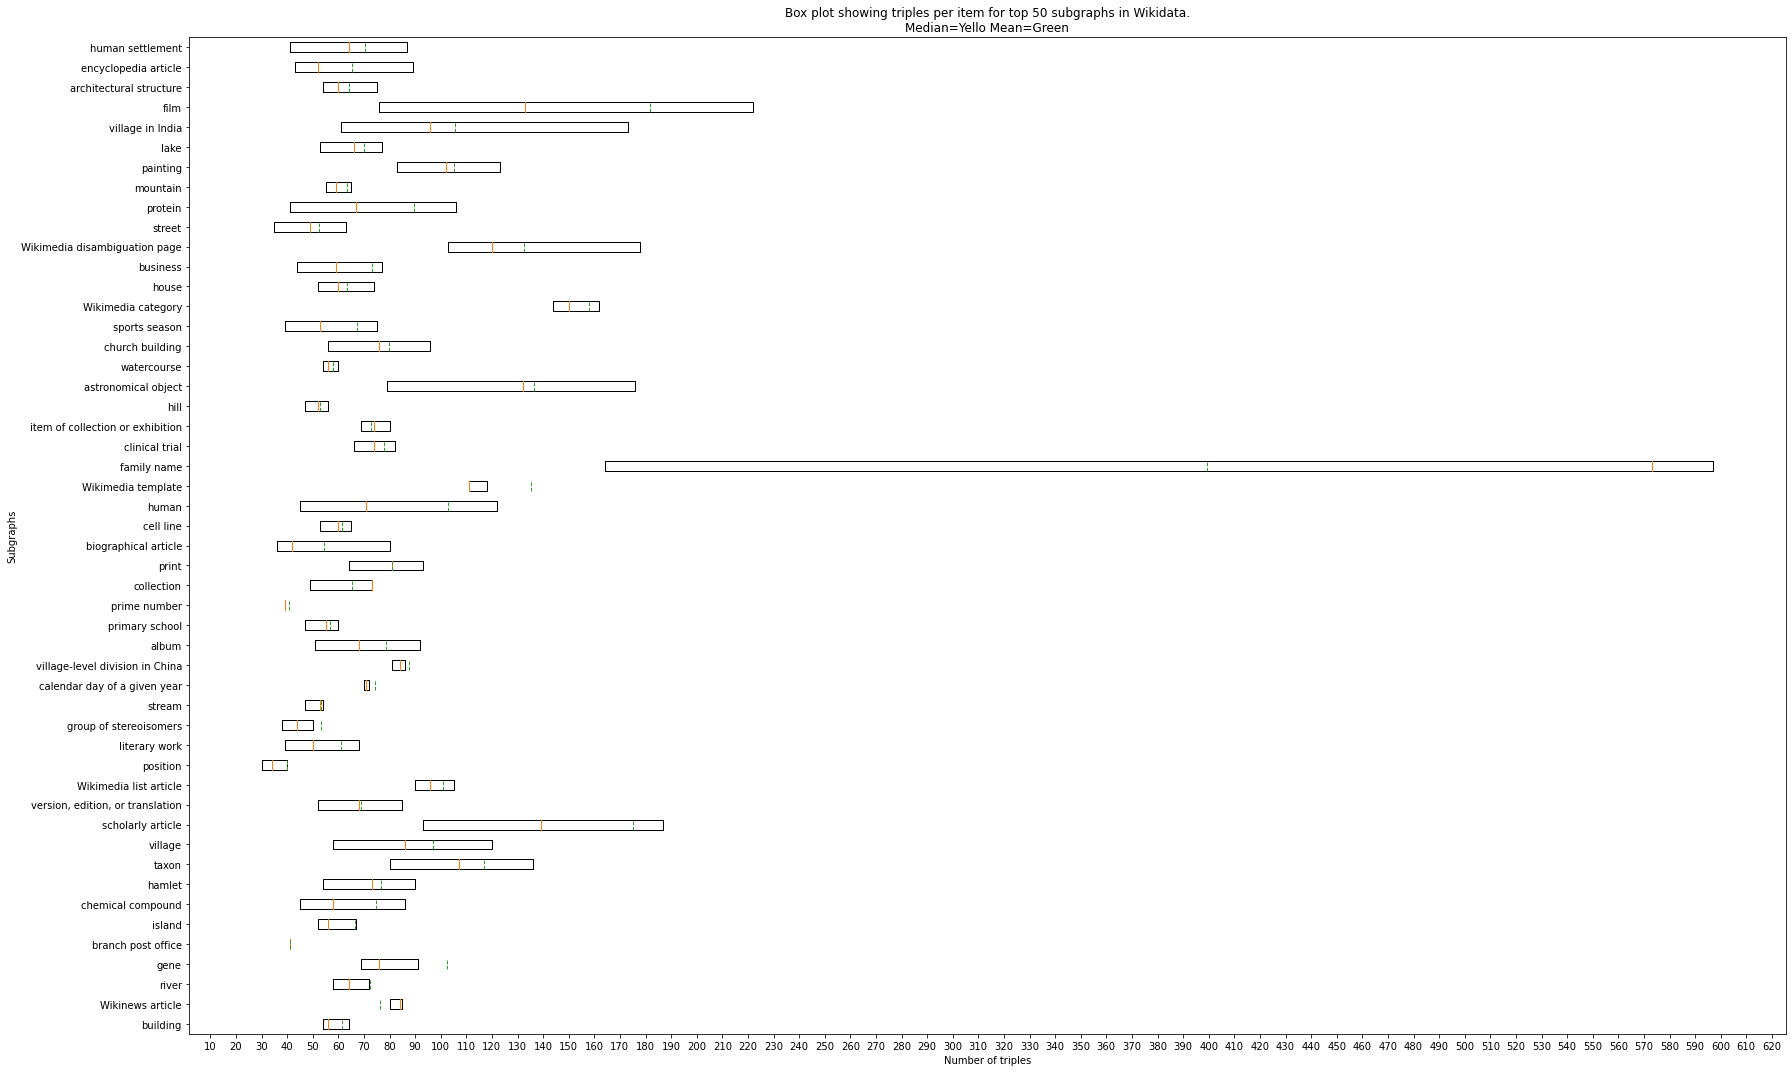

In [6]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(25,15))
boxes = qs.to_dict('records')
ax.bxp(boxes, showfliers=False, showmeans=True, meanline=True, vert=False)
ax.set_xlabel("Number of triples")
ax.set_ylabel("Subgraphs")
ax.set_title("Box plot showing triples per item for top 50 subgraphs in Wikidata.\nMedian=Yello Mean=Green")
tick_spacing = 10
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# ax.tick_params(axis='x', labelrotation=90)
plt.tight_layout()
plt.savefig("subgraphs_boxplot.png")

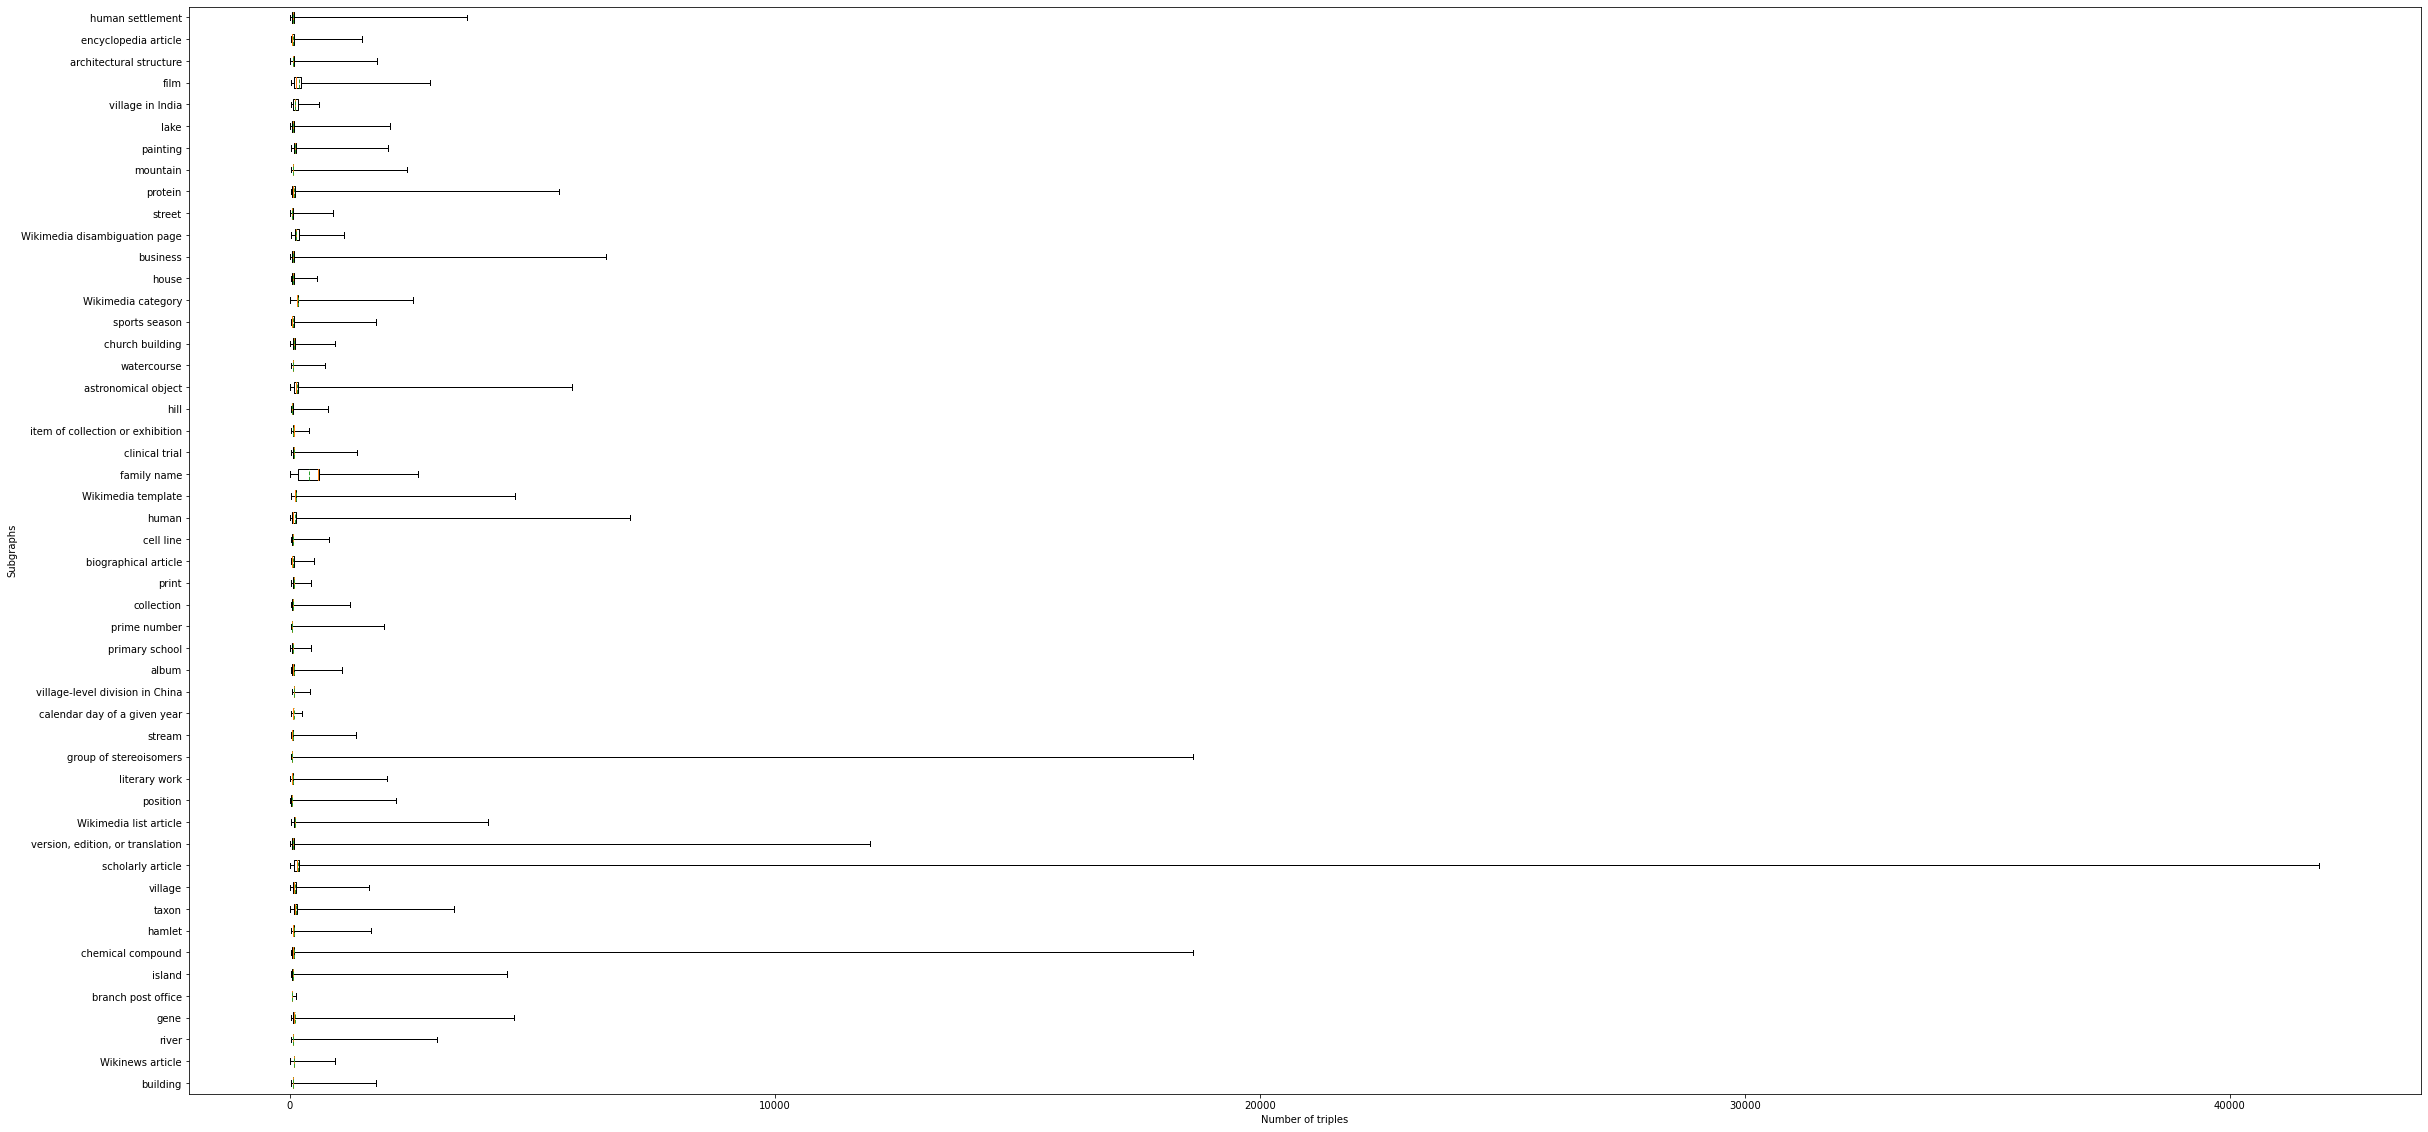

In [146]:
fig, ax = plt.subplots(figsize=(40,20))
boxes = qs.to_dict('records')
ax.bxp(boxes, showfliers=False, showmeans=True, meanline=True, vert=False)
ax.set_xlabel("Number of triples")
ax.set_ylabel("Subgraphs")
# ax.tick_params(axis='x', labelrotation=90)
plt.savefig("subgraphs_boxplot_w_whiskers.png")

# Predicate Analysis

## General analysis

In [ ]:
subgraph_pred_count = all_subgraphs.groupby(['subgraph','predicate_code']).count()

In [ ]:
subgraph_pred_count.select('predicate_code').distinct().count()

7418

In [42]:
subgraph_pred_df = subgraph_pred_count.toPandas()

subgraph predicate_code    count
0            <http://www.wikidata.org/entity/Q5>  core#altLabel  9320641
1         <http://www.wikidata.org/entity/Q4022>          P1705     8216
2      <http://www.wikidata.org/entity/Q3331189>           P655    30508
3            <http://www.wikidata.org/entity/Q5>          P8122     8547
4            <http://www.wikidata.org/entity/Q5>          P3553     4447
...                                          ...            ...      ...
31852  <http://www.wikidata.org/entity/Q4167410>            P36       12
31853    <http://www.wikidata.org/entity/Q23397>          P7116        3
31854    <http://www.wikidata.org/entity/Q11424>          P7369        3
31855   <http://www.wikidata.org/entity/Q101352>           P641        3
31856   <http://www.wikidata.org/entity/Q482994>          P1775        3

[31857 rows x 3 columns]

In [115]:
subgraph_pred_df.to_csv('subgraph_pred_df.csv', index=False)

In [120]:
subgraph_pred_df['predicate_code'].nunique()

7418

In [124]:
subgraph_pred_df[~subgraph_pred_df['predicate_code'].str.startswith('P')]['predicate_code'].unique()

array(['core#altLabel', 'ontology#badge', 'about', 'rdf-schema#label',
       'version', '22-rdf-syntax-ns#type', 'prov#wasDerivedFrom',
       'ontology#identifiers', 'ontology#sitelinks', 'ontology#rank',
       'ontology#wikiGroup', 'dateModified', 'description', 'isPartOf',
       'name', 'inLanguage', 'ontology#statements',
       'ontology#propertyType', 'owl#complementOf', 'ontology#qualifier',
       'ontolex#sense', 'core#definition', 'owl#someValuesFrom',
       'ontology#lemma', 'ontology#qualifierValue', 'ontolex#lexicalForm',
       'ontology#statementValue', 'ontology#claim',
       'ontolex#representation', 'ontology#directClaim',
       'ontology#referenceValue', 'ontology#reference',
       'ontology#qualifierValueNormalized', 'ontology#statementProperty',
       'ontology#novalue', 'ontology#statementValueNormalized',
       'ontology#grammaticalFeature', 'language',
       'ontology#lexicalCategory', 'ontology#directClaimNormalized',
       'ontology#referenceValueNo

In [129]:
subgraph_pred_df[subgraph_pred_df['predicate_code'].str.startswith('P')]['predicate_code'].nunique()

7376

In [143]:
preds_list = subgraph_pred_df[subgraph_pred_df['predicate_code'].str.startswith('P')]['predicate_code'].unique().tolist()
chunksize = 500
labels = pd.DataFrame(columns=['uri', 'uriLabel'])

for i in range(0,len(preds_list), chunksize):
    preds = ['wd:'+pred for pred in preds_list[i:i+chunksize]]
    predsStr = ' '.join(preds)
    query = """
                SELECT ?uri ?uriLabel
                WHERE 
                {
                  VALUES ?uri { %s }
                  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
                }
            """ % predsStr
    labels = pd.concat([labels, get_results(query, ['uri', 'uriLabel'])])

labels['predicate_code'] = labels['uri'].apply(lambda x: x.split('/')[-1])
labels

uri  \
0    http://www.wikidata.org/entity/P1705   
1     http://www.wikidata.org/entity/P655   
2    http://www.wikidata.org/entity/P8122   
3    http://www.wikidata.org/entity/P3553   
4    http://www.wikidata.org/entity/P7425   
..                                    ...   
371  http://www.wikidata.org/entity/P1981   
372  http://www.wikidata.org/entity/P4889   
373  http://www.wikidata.org/entity/P8373   
374  http://www.wikidata.org/entity/P8339   
375  http://www.wikidata.org/entity/P7116   

                                 uriLabel predicate_code  
0                            native label          P1705  
1                              translator           P655  
2                   DLL Catalog author ID          P8122  
3                          Zhihu topic ID          P3553  
4        Rotterdam City Archives actor ID          P7425  
..                                    ...            ...  
371                       FSK film rating          P1981  
372               MuIS person or group ID          P4889  
373  Encyclopedia Tatarica (tt) Online ID          P8373  
374                        entry receptor          P8339  
375               Hiking Project trail ID          P7116  

[7376 rows x 3 columns]

In [206]:
subgraph_pred_df_info = subgraph_pred_df.merge(subgraph_size[['subgraph', 'subgraph_code', 'label', 'subgraph_rank', 'item_rank']], on='subgraph')
subgraph_pred_df_info['subgraph_label&rank'] = subgraph_pred_df_info['label'] + ' (' + subgraph_pred_df_info['subgraph_rank'].astype(str) + ')'
subgraph_pred_df_info = subgraph_pred_df_info.merge(labels[['uriLabel','predicate_code']], on='predicate_code', how='outer')\
                                             .rename(columns={'uriLabel':'predicate_label'})
subgraph_pred_df_info['predicate_label'] = subgraph_pred_df_info.apply(lambda row: row['predicate_code'] if pd.isnull(row['predicate_label']) else row['predicate_label'],axis=1)
subgraph_pred_df_info = subgraph_pred_df_info[['subgraph', 'subgraph_code', 'label', 
                                               'subgraph_rank', 'subgraph_label&rank', 'item_rank', 
                                               'predicate_code', 'predicate_label', 'count']]
subgraph_pred_df_info.loc[(subgraph_pred_df_info['predicate_label']=='name') & (subgraph_pred_df_info['predicate_code']=='name'),'predicate_label'] = 'schema:name'
subgraph_pred_df_info.loc[subgraph_pred_df_info['predicate_label']=='schema:name','predicate_code'] = 'schema:name'

subgraph_pred_df_info

subgraph subgraph_code  \
0             <http://www.wikidata.org/entity/Q5>            Q5   
1          <http://www.wikidata.org/entity/Q4022>         Q4022   
2       <http://www.wikidata.org/entity/Q3331189>      Q3331189   
3          <http://www.wikidata.org/entity/Q9842>         Q9842   
4       <http://www.wikidata.org/entity/Q4167836>      Q4167836   
...                                           ...           ...   
31852  <http://www.wikidata.org/entity/Q11266439>     Q11266439   
31853  <http://www.wikidata.org/entity/Q11266439>     Q11266439   
31854  <http://www.wikidata.org/entity/Q11266439>     Q11266439   
31855    <http://www.wikidata.org/entity/Q355304>       Q355304   
31856    <http://www.wikidata.org/entity/Q355304>       Q355304   

                                  label  subgraph_rank  \
0                                 human              3   
1                                 river             21   
2      version, edition, or translation             34   
3                        primary school             43   
4                    Wikimedia category              4   
...                                 ...            ...   
31852                Wikimedia template              9   
31853                Wikimedia template              9   
31854                Wikimedia template              9   
31855                       watercourse             37   
31856                       watercourse             37   

                         subgraph_label&rank  item_rank predicate_code  \
0                                  human (3)          2  core#altLabel   
1                                 river (21)         19  core#altLabel   
2      version, edition, or translation (34)         36  core#altLabel   
3                        primary school (43)         37  core#altLabel   
4                     Wikimedia category (4)          4  core#altLabel   
...                                      ...        ...            ...   
31852                 Wikimedia template (9)         10          P1693   
31853                 Wikimedia template (9)         10          P1690   
31854                 Wikimedia template (9)         10          P3457   
31855                       watercourse (37)         33          P9700   
31856                       watercourse (37)         33           P587   

                 predicate_label    count  
0                  core#altLabel  9320641  
1                  core#altLabel    80417  
2                  core#altLabel    35149  
3                  core#altLabel    16908  
4                  core#altLabel   204281  
...                          ...      ...  
31852  Terminologia Embryologica       39  
31853                 ICD-10-PCS       78  
31854         case fatality rate      346  
31855                   delta of        9  
31856                       MMSI        3  

[31857 rows x 9 columns]

In [207]:
subgraph_pred_df_info.to_csv('subgraph_pred_df_info.csv', index=False)
subgraph_pred_df_info

subgraph subgraph_code  \
0             <http://www.wikidata.org/entity/Q5>            Q5   
1          <http://www.wikidata.org/entity/Q4022>         Q4022   
2       <http://www.wikidata.org/entity/Q3331189>      Q3331189   
3          <http://www.wikidata.org/entity/Q9842>         Q9842   
4       <http://www.wikidata.org/entity/Q4167836>      Q4167836   
...                                           ...           ...   
31852  <http://www.wikidata.org/entity/Q11266439>     Q11266439   
31853  <http://www.wikidata.org/entity/Q11266439>     Q11266439   
31854  <http://www.wikidata.org/entity/Q11266439>     Q11266439   
31855    <http://www.wikidata.org/entity/Q355304>       Q355304   
31856    <http://www.wikidata.org/entity/Q355304>       Q355304   

                                  label  subgraph_rank  \
0                                 human              3   
1                                 river             21   
2      version, edition, or translation             34   
3                        primary school             43   
4                    Wikimedia category              4   
...                                 ...            ...   
31852                Wikimedia template              9   
31853                Wikimedia template              9   
31854                Wikimedia template              9   
31855                       watercourse             37   
31856                       watercourse             37   

                         subgraph_label&rank  item_rank predicate_code  \
0                                  human (3)          2  core#altLabel   
1                                 river (21)         19  core#altLabel   
2      version, edition, or translation (34)         36  core#altLabel   
3                        primary school (43)         37  core#altLabel   
4                     Wikimedia category (4)          4  core#altLabel   
...                                      ...        ...            ...   
31852                 Wikimedia template (9)         10          P1693   
31853                 Wikimedia template (9)         10          P1690   
31854                 Wikimedia template (9)         10          P3457   
31855                       watercourse (37)         33          P9700   
31856                       watercourse (37)         33           P587   

                 predicate_label    count  
0                  core#altLabel  9320641  
1                  core#altLabel    80417  
2                  core#altLabel    35149  
3                  core#altLabel    16908  
4                  core#altLabel   204281  
...                          ...      ...  
31852  Terminologia Embryologica       39  
31853                 ICD-10-PCS       78  
31854         case fatality rate      346  
31855                   delta of        9  
31856                       MMSI        3  

[31857 rows x 9 columns]

In [208]:
## Number of predicates per subgraph
subgraph_pred_df_info.groupby('label').count()[['count']].sort_values('count', ascending=False)

count
label                                  
human                              4482
business                           1790
building                           1243
human settlement                   1120
literary work                      1093
church building                    1036
film                               1029
version, edition, or translation   1006
architectural structure             994
taxon                               963
Wikimedia list article              880
island                              829
village                             818
Wikimedia disambiguation page       796
painting                            785
house                               760
scholarly article                   722
mountain                            709
collection                          665
position                            654
album                               638
Wikimedia category                  610
lake                                602
chemical compound                   591
river                               580
astronomical object                 578
street                              572
hill                                470
hamlet                              423
primary school                      410
family name                         375
sports season                       353
item of collection or exhibition    306
watercourse                         302
stream                              280
print                               269
protein                             267
Wikinews article                    256
Wikimedia template                  222
gene                                218
group of stereoisomers              216
village in India                    210
encyclopedia article                164
biographical article                131
clinical trial                      124
prime number                        101
village-level division in China      77
cell line                            60
calendar day of a given year         56
branch post office                   22

In [35]:
subgraph_pred_df_info = pd.read_csv('subgraph_pred_df_info.csv')

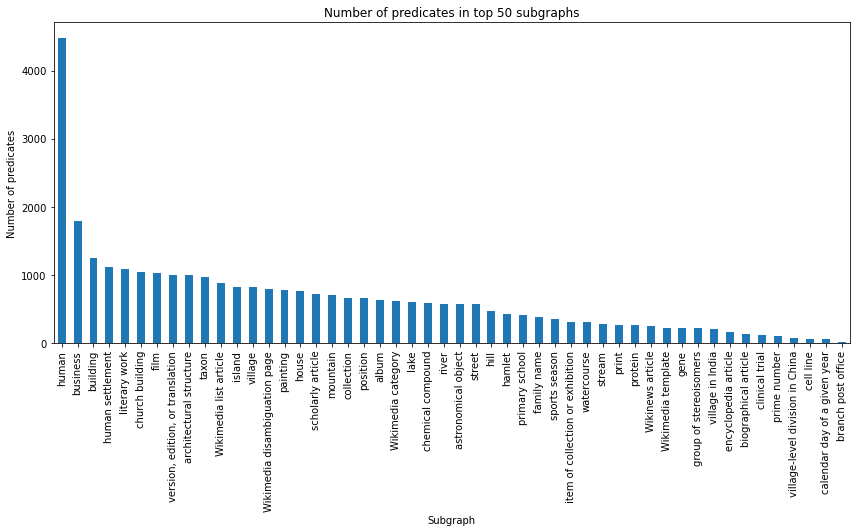

In [43]:
subgraph_pred_df_info.groupby('label').count()[['count']]\
                     .sort_values('count', ascending=False)\
                     .plot.bar(figsize=(12,7.5), title='Number of predicates in top 50 subgraphs', 
                               xlabel='Subgraph', ylabel='Number of predicates', legend=None)
plt.tight_layout()
plt.savefig('pred_count.png')

In [45]:
all_pred = subgraph_pred_df_info.rename(columns={'count':'pred_count'}).groupby('predicate_label').agg({'pred_count':['sum', 'count']})
all_pred.columns = [b for _,b in all_pred.columns.to_flat_index()]
all_pred = all_pred.sort_values('count', ascending=False)

all_pred

sum  count
predicate_label                                  
ontology#statements               79377439     50
core#altLabel                     69166128     50
instance of                      257980370     50
ontology#identifiers              79377422     50
dateModified                      79377439     50
...                                    ...    ...
Vesti.kz person ID                     384      1
Viasona ID                             696      1
VicFlora ID                          28824      1
Viceversa Letteratura author ID       3912      1
NFL.com ID (new scheme)              25428      1

[7418 rows x 2 columns]

In [46]:
all_pred[all_pred['count']==1]

sum  count
predicate_label                                
instruction set                       33      1
NeuroNames ID (plain mode)             3      1
Conférence du stage secretary ID     237      1
Nevada SHPO marker ID                  6      1
Nevada Women's History Project ID    555      1
...                                  ...    ...
Vesti.kz person ID                   384      1
Viasona ID                           696      1
VicFlora ID                        28824      1
Viceversa Letteratura author ID     3912      1
NFL.com ID (new scheme)            25428      1

[3567 rows x 2 columns]

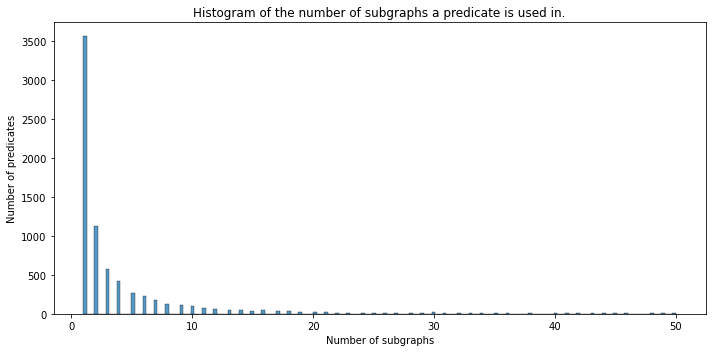

In [55]:
plt.figure(figsize=(10,5))
sns.histplot(all_pred['count'])
plt.xlabel('Number of subgraphs')
plt.ylabel('Number of predicates')
plt.title('Histogram of the number of subgraphs a predicate is used in.')
plt.tight_layout()
plt.savefig('subgraph_pred_dist.png')

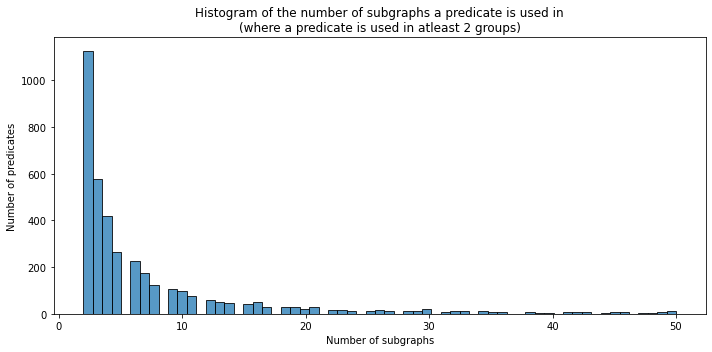

In [56]:
plt.figure(figsize=(10,5))
sns.histplot(all_pred[all_pred['count']>1]['count'])
plt.xlabel('Number of subgraphs')
plt.ylabel('Number of predicates')
plt.title('Histogram of the number of subgraphs a predicate is used in\n(where a predicate is used in atleast 2 groups)')
plt.tight_layout()
plt.savefig('subgraph_pred_dist_2.png')

Text(0.5, 1.0, 'Logarithmic histogram of the number of subgraphs a predicate is used in.')

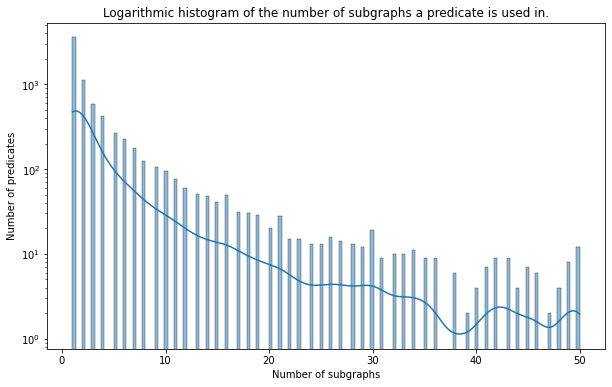

In [52]:
plt.figure(figsize=(10,6))
sns.histplot(all_pred['count'], kde=True, log_scale=[False, True])
plt.xlabel('Number of subgraphs')
plt.ylabel('Number of predicates')
plt.title('Logarithmic histogram of the number of subgraphs a predicate is used in.')

Text(0.5, 1.0, 'Logarithmic histogram of the number of triples per predicate.')

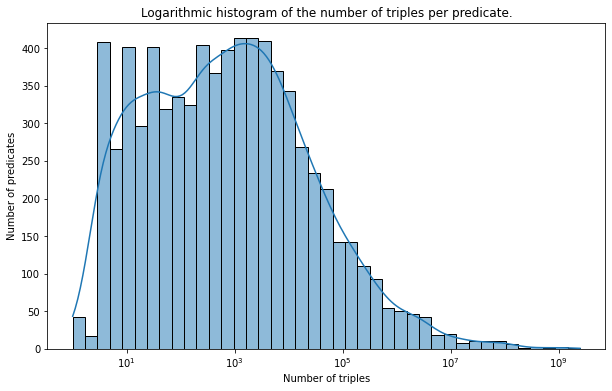

In [222]:
## takes forever
# plt.figure(figsize=(10,6))
# sns.histplot(all_pred['count'], kde=True)
# plt.xlabel('Number of triples')
# plt.ylabel('Number of predicates')
# plt.title('Histogram of the number of triples per predicate.')

plt.figure(figsize=(10,6))
sns.histplot(all_pred['sum'], kde=True, log_scale=True)
plt.xlabel('Number of triples')
plt.ylabel('Number of predicates')
plt.title('Logarithmic histogram of the number of triples per predicate.')

Text(0.5, 1.0, 'Logarithmic histogram of the number of triples per predicate.')

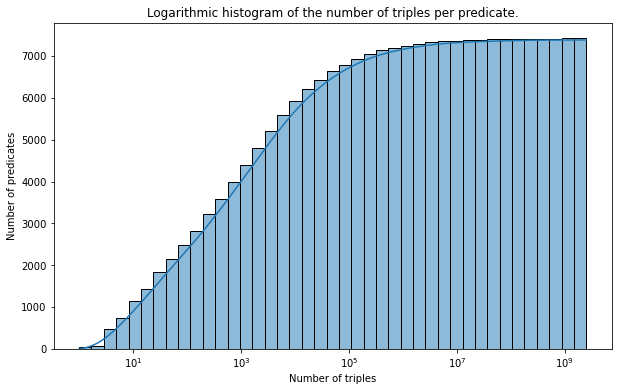

In [224]:
plt.figure(figsize=(10,6))
sns.histplot(all_pred['sum'], kde=True, log_scale=True, cumulative=True)
plt.xlabel('Number of triples')
plt.ylabel('Number of predicates')
plt.title('Logarithmic histogram of the number of triples per predicate.')

### Top predicates per subgraph

In [59]:
top_subgraph_pred = subgraph_pred_df_info[['subgraph_code', 'label', 'predicate_label', 'count']]\
                            .sort_values('count', ascending=False)\
                            .groupby(['subgraph_code', 'label']).head(5)
top_subgraph_pred = pd.merge(top_subgraph_pred, subgraph_size[['subgraph_code', 'triple_count']], on='subgraph_code')
top_subgraph_pred['percent_in_subgraph'] = (top_subgraph_pred['count']*100/top_subgraph_pred['triple_count']).round(3)
top_subgraph_pred['percent_in_WD'] = (top_subgraph_pred['count']*100/total_triples).round(3)
top_subgraph_pred

subgraph_code              label        predicate_label       count  \
0       Q13442814  scholarly article            description  1324177494   
1       Q13442814  scholarly article             cites work   853611996   
2       Q13442814  scholarly article          ontology#rank   796548851   
3       Q13442814  scholarly article  22-rdf-syntax-ns#type   796517049   
4       Q13442814  scholarly article    prov#wasDerivedFrom   714004630   
..            ...                ...                    ...         ...   
245      Q4164871           position  22-rdf-syntax-ns#type      616685   
246      Q4164871           position          ontology#rank      580022   
247      Q4164871           position       rdf-schema#label      544323   
248      Q4164871           position            instance of      370251   
249      Q4164871           position            subclass of      352985   

     triple_count  percent_in_subgraph  percent_in_WD  
0      6539020889               20.250         10.025  
1      6539020889               13.054          6.462  
2      6539020889               12.181          6.030  
3      6539020889               12.181          6.030  
4      6539020889               10.919          5.405  
..            ...                  ...            ...  
245       4720668               13.064          0.005  
246       4720668               12.287          0.004  
247       4720668               11.531          0.004  
248       4720668                7.843          0.003  
249       4720668                7.477          0.003  

[250 rows x 7 columns]

In [60]:
top_subgraph_pred.to_csv('top_subgraph_pred.csv', index=False)

In [57]:
top_subgraph_pred = pd.read_csv('top_subgraph_pred.csv')

In [94]:
top_subgraph_pred.sort_values('percent_in_WD', ascending=False).head(50)

subgraph_code                            label        predicate_label  \
0      Q13442814                scholarly article            description   
1      Q13442814                scholarly article             cites work   
2      Q13442814                scholarly article          ontology#rank   
3      Q13442814                scholarly article  22-rdf-syntax-ns#type   
4      Q13442814                scholarly article    prov#wasDerivedFrom   
5       Q4167836               Wikimedia category            description   
10         Q6999              astronomical object          ontology#rank   
11         Q6999              astronomical object    prov#wasDerivedFrom   
15            Q5                            human  22-rdf-syntax-ns#type   
12         Q6999              astronomical object  22-rdf-syntax-ns#type   
16            Q5                            human          ontology#rank   
13         Q6999              astronomical object     apparent magnitude   
20      Q4167410    Wikimedia disambiguation page            description   
25     Q11266439               Wikimedia template            description   
14         Q6999              astronomical object           catalog code   
17            Q5                            human       rdf-schema#label   
30        Q16521                            taxon       rdf-schema#label   
35       Q101352                      family name            description   
36       Q101352                      family name       rdf-schema#label   
18            Q5                            human    prov#wasDerivedFrom   
19            Q5                            human            description   
37       Q101352                      family name          core#altLabel   
31        Q16521                            taxon            description   
32        Q16521                            taxon  22-rdf-syntax-ns#type   
21      Q4167410    Wikimedia disambiguation page       rdf-schema#label   
33        Q16521                            taxon          ontology#rank   
40        Q11173                chemical compound            description   
45     Q13100073  village-level division in China            description   
50     Q13406463           Wikimedia list article            description   
6       Q4167836               Wikimedia category  22-rdf-syntax-ns#type   
34        Q16521                            taxon    prov#wasDerivedFrom   
55         Q7187                             gene    prov#wasDerivedFrom   
56         Q7187                             gene  22-rdf-syntax-ns#type   
57         Q7187                             gene          ontology#rank   
7       Q4167836               Wikimedia category       rdf-schema#label   
8       Q4167836               Wikimedia category            instance of   
60     Q17633526                 Wikinews article            description   
9       Q4167836               Wikimedia category               isPartOf   
65         Q8054                          protein    prov#wasDerivedFrom   
70     Q13433827             encyclopedia article            description   
66         Q8054                          protein  22-rdf-syntax-ns#type   
67         Q8054                          protein          ontology#rank   
41        Q11173                chemical compound  22-rdf-syntax-ns#type   
58         Q7187                             gene               ortholog   
42        Q11173                chemical compound          ontology#rank   
75      Q3305213                         painting            description   
80        Q11424                             film  22-rdf-syntax-ns#type   
59         Q7187                             gene         found in taxon   
76      Q3305213                         painting  22-rdf-syntax-ns#type   
77      Q3305213                         painting          ontology#rank   

         count  triple_count  percent_in_subgraph  percent_in_WD  
0   1324177494    6539020889               20.250         1

In [88]:
top_subgraph_pred.groupby(['label']).head(1)

subgraph_code                             label        predicate_label  \
0       Q13442814                 scholarly article            description   
5        Q4167836                Wikimedia category            description   
10          Q6999               astronomical object          ontology#rank   
15             Q5                             human  22-rdf-syntax-ns#type   
20       Q4167410     Wikimedia disambiguation page            description   
25      Q11266439                Wikimedia template            description   
30         Q16521                             taxon       rdf-schema#label   
35        Q101352                       family name            description   
40         Q11173                 chemical compound            description   
45      Q13100073   village-level division in China            description   
50      Q13406463            Wikimedia list article            description   
55          Q7187                              gene    prov#wasDerivedFrom   
60      Q17633526                  Wikinews article            description   
65          Q8054                           protein    prov#wasDerivedFrom   
70      Q13433827              encyclopedia article            description   
75       Q3305213                          painting            description   
80         Q11424                              film  22-rdf-syntax-ns#type   
85      Q47150325      calendar day of a given year       rdf-schema#label   
90        Q486972                  human settlement  22-rdf-syntax-ns#type   
95       Q2668072                        collection  22-rdf-syntax-ns#type   
100        Q30612                    clinical trial  22-rdf-syntax-ns#type   
105         Q8502                          mountain            description   
110        Q79007                            street  22-rdf-syntax-ns#type   
115         Q4022                             river            description   
120          Q532                           village  22-rdf-syntax-ns#type   
125       Q482994                             album  22-rdf-syntax-ns#type   
130        Q16970                   church building  22-rdf-syntax-ns#type   
135        Q23397                              lake            description   
140        Q41176                          building  22-rdf-syntax-ns#type   
145     Q56436498                  village in India            description   
150        Q54050                              hill  22-rdf-syntax-ns#type   
155      Q4830453                          business  22-rdf-syntax-ns#type   
160         Q3947                             house  22-rdf-syntax-ns#type   
165     Q18593264  item of collection or exhibition  22-rdf-syntax-ns#type   
170      Q3331189  version, edition, or translation  22-rdf-syntax-ns#type   
175     Q27020041                     sports season  22-rdf-syntax-ns#type   
180      Q7725634                     literary work  22-rdf-syntax-ns#type   
185     Q11060274                             print  22-rdf-syntax-ns#type   
190       Q811979           architectural structure          ontology#rank   
195        Q23442                            island  22-rdf-syntax-ns#type   
200       Q355304                       watercourse  22-rdf-syntax-ns#type   
205         Q9842                    primary school  22-rdf-syntax-ns#type   
210         Q5084                            hamlet  22-rdf-syntax-ns#type   
215     Q19389637              biographical article  22-rdf-syntax-ns#type   
220     Q21014462                         cell line       rdf-schema#label   
225     Q59199015            group of stereoisomers  22-rdf-syntax-ns#type   
230        Q47521                            stream  22-rdf-syntax-ns#type   
235        Q49008                      prime number            description   
240     Q61443690                branch post office  22-rdf-syntax-ns#type   
245      Q4164871                          position  22-rdf-syntax-ns#type   

          count  triple_c

### Predicate vs Subgraph analysis
- hstogram how the property is used across subgraphs

In [31]:
subgraph_pred_df_info = pd.read_csv('subgraph_pred_df_info.csv')
subgraph_pred_df_info.head(5)

subgraph subgraph_code  \
0        <http://www.wikidata.org/entity/Q5>            Q5   
1     <http://www.wikidata.org/entity/Q4022>         Q4022   
2  <http://www.wikidata.org/entity/Q3331189>      Q3331189   
3     <http://www.wikidata.org/entity/Q9842>         Q9842   
4  <http://www.wikidata.org/entity/Q4167836>      Q4167836   

                              label  subgraph_rank  \
0                             human              3   
1                             river             21   
2  version, edition, or translation             34   
3                    primary school             43   
4                Wikimedia category              4   

                     subgraph_label&rank  item_rank predicate_code  \
0                              human (3)          2  core#altLabel   
1                             river (21)         19  core#altLabel   
2  version, edition, or translation (34)         36  core#altLabel   
3                    primary school (43)         37  core#altLabel   
4                 Wikimedia category (4)          4  core#altLabel   

  predicate_label    count  
0   core#altLabel  9320641  
1   core#altLabel    80417  
2   core#altLabel    35149  
3   core#altLabel    16908  
4   core#altLabel   204281

In [225]:
len(all_pred[all_pred['count']==1]), len(all_pred[all_pred['count']>1])

(3567, 3851)

In [234]:
for val in range(11):
    p = pow(10,val)
    ln = len(all_pred[(all_pred['count']>1) & (all_pred['sum']>p)])
    print('>10^'+str(val), '\t:', ln)

>10^0 	: 3851
>10^1 	: 3647
>10^2 	: 2866
>10^3 	: 2039
>10^4 	: 1216
>10^5 	: 568
>10^6 	: 207
>10^7 	: 59
>10^8 	: 15
>10^9 	: 3
>10^10 	: 0


In [33]:
## Top 60
predList = all_pred[all_pred['count']>1].sort_values('sum', ascending=False).reset_index()['predicate_label'].values.tolist()[:60]
len(predList)

60

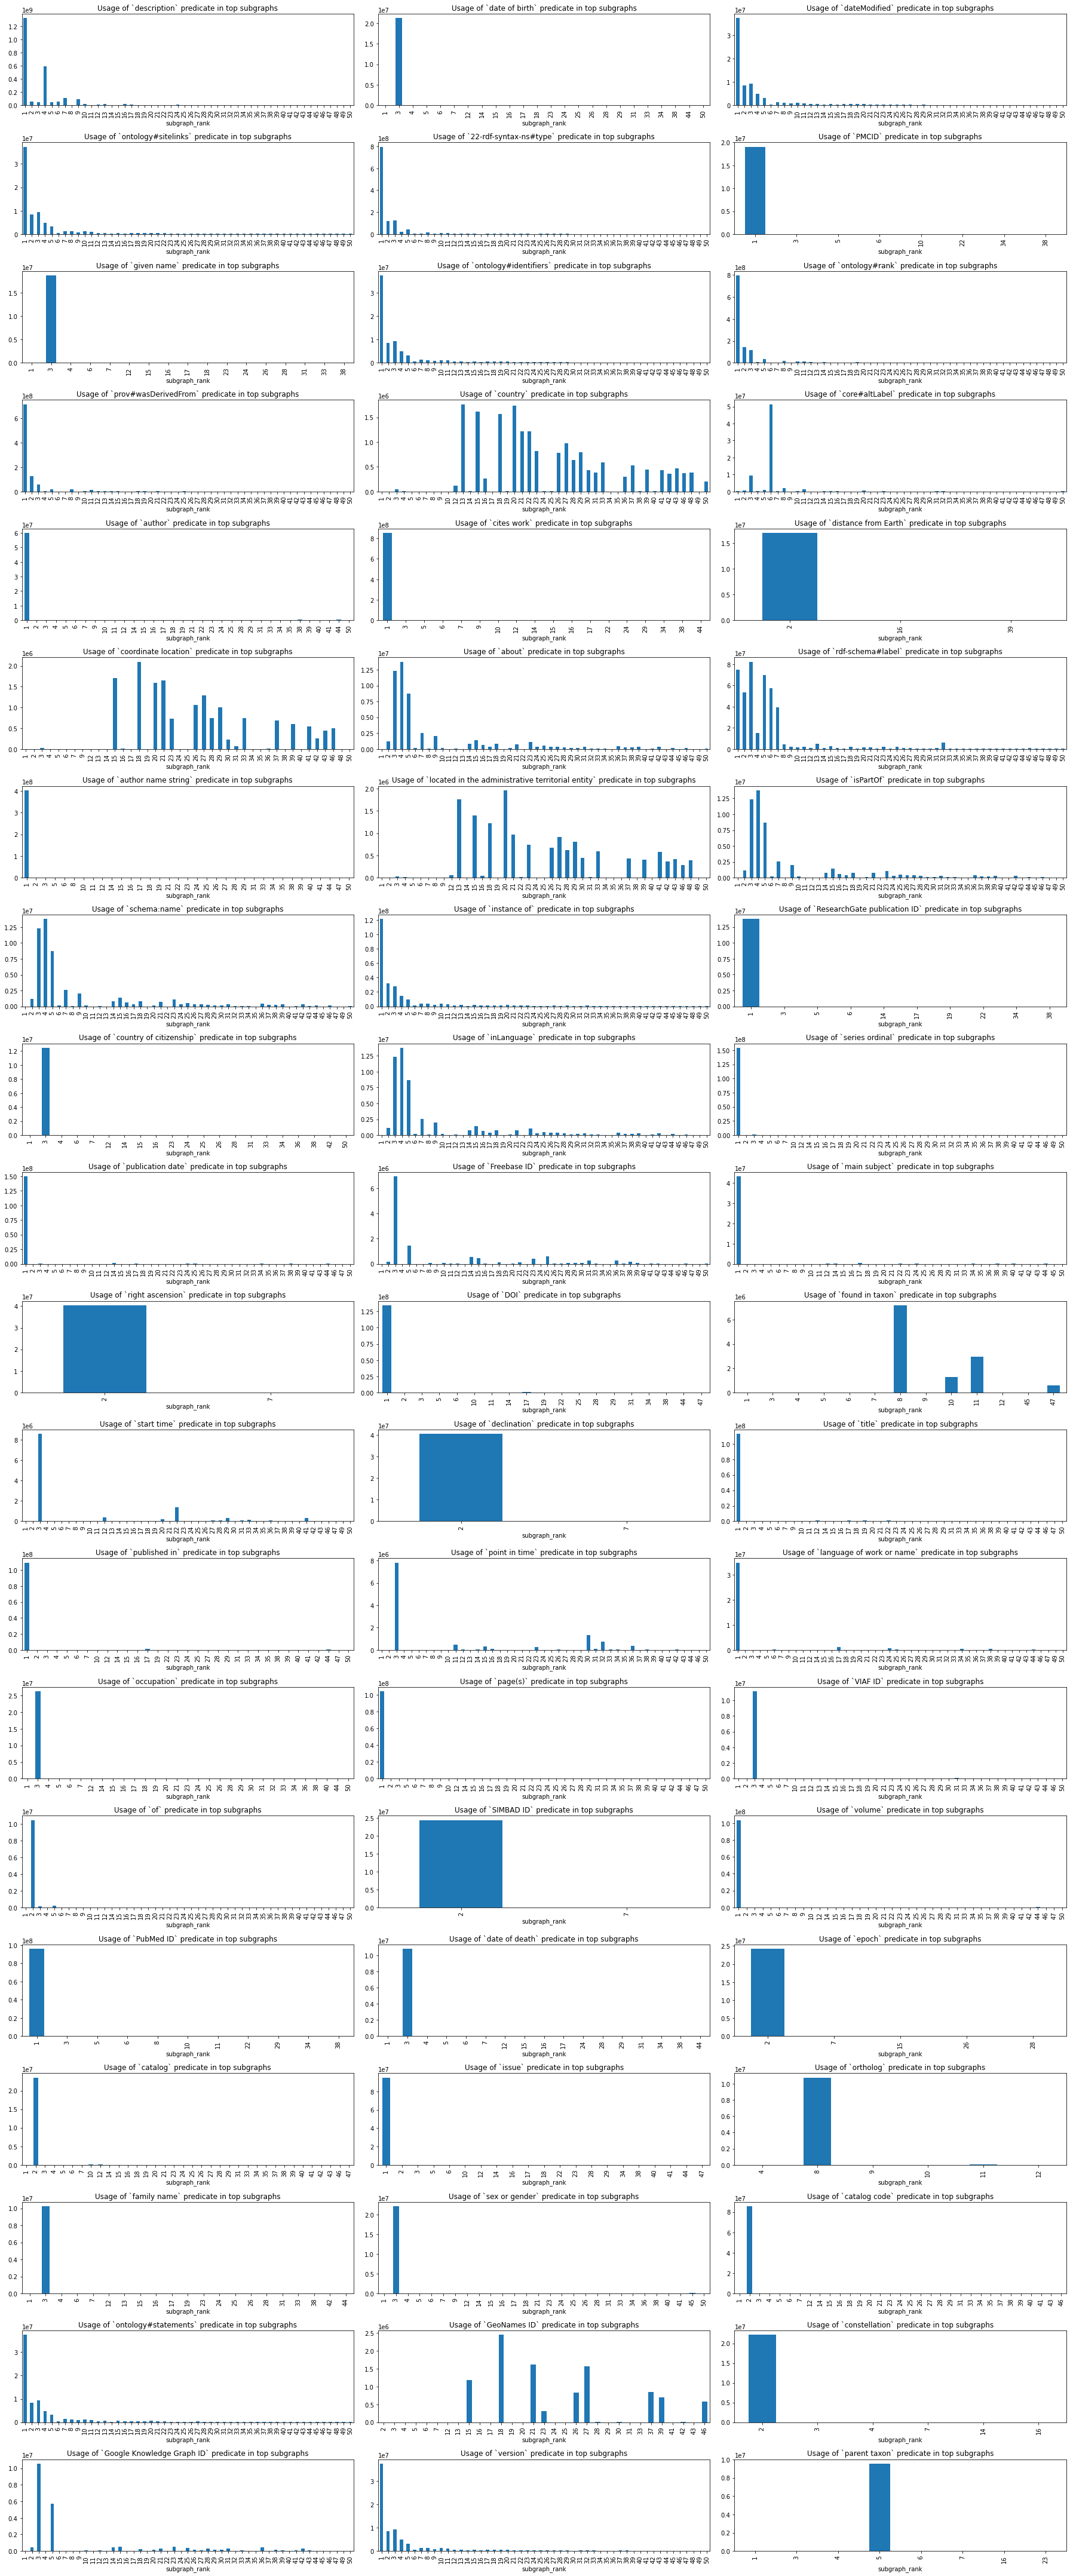

In [286]:
fig, axes = plt.subplots(nrows=20, ncols=3, figsize=(25,60))
r, c = 0, 0

for pred in predList:
    df = subgraph_pred_df_info[subgraph_pred_df_info['predicate_label'] == pred].sort_values('subgraph_rank')
    df.plot.bar(ax=axes[r,c], x='subgraph_rank', y='count', legend=False, title='Usage of `'+pred+'` predicate in top subgraphs')
    r = (r+1)%20
    c = (c+1)%3
    
plt.tight_layout()
plt.savefig('60_preds_distribution_in_subgraphs.png', facecolor='white', edgecolor='none')

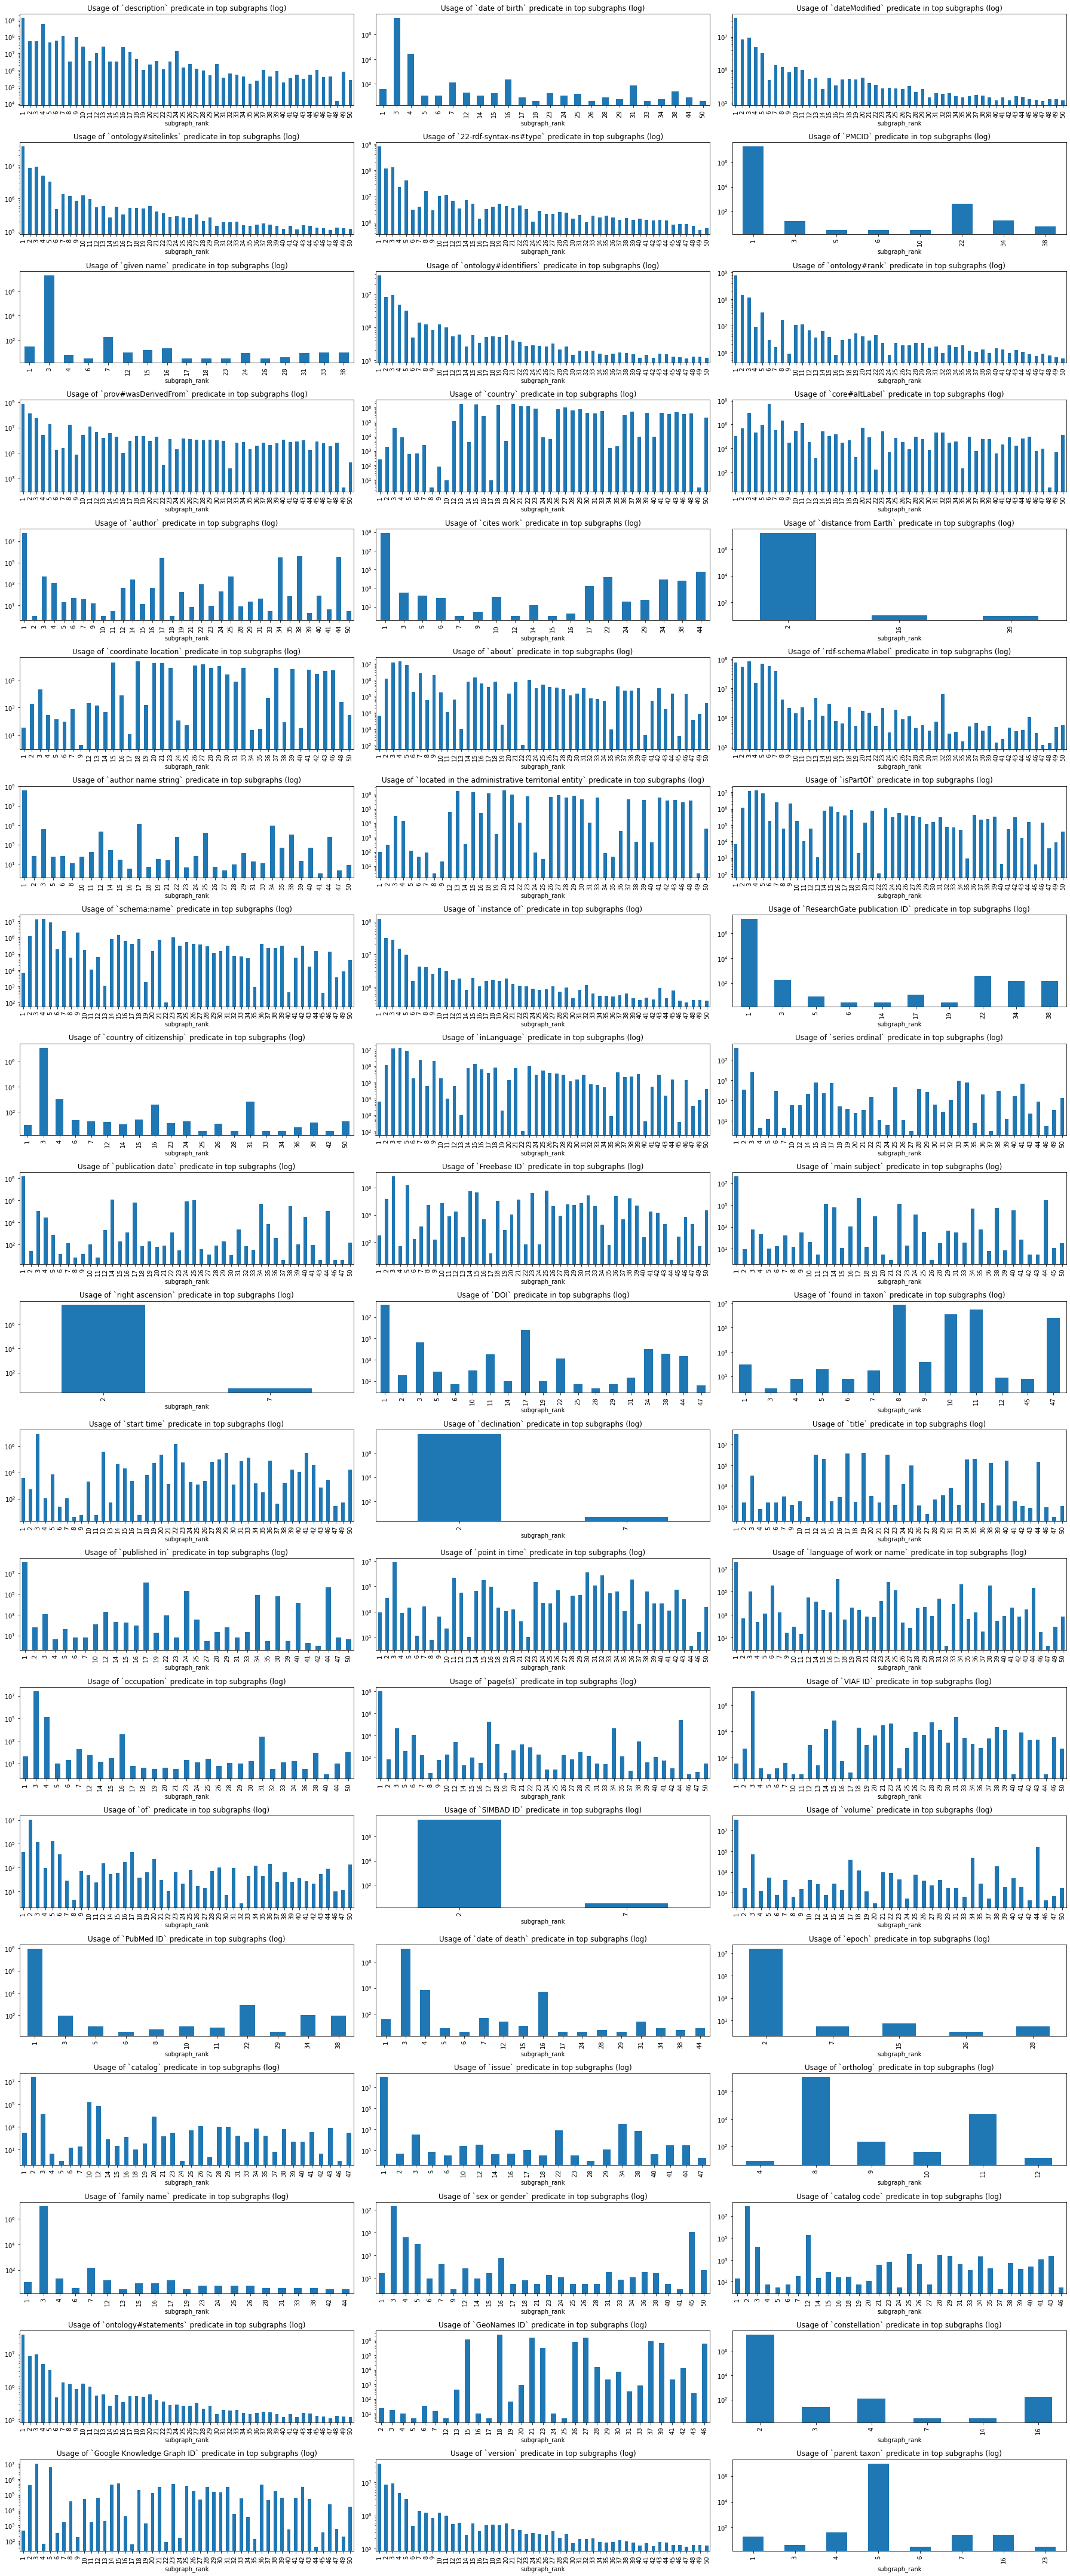

In [287]:
fig, axes = plt.subplots(nrows=20, ncols=3, figsize=(25,60))
r, c = 0, 0

for pred in predList:
    df = subgraph_pred_df_info[subgraph_pred_df_info['predicate_label'] == pred].sort_values('subgraph_rank')
    df.plot.bar(ax=axes[r,c], x='subgraph_rank', y='count', logy=True, legend=False, title='Usage of `'+pred+'` predicate in top subgraphs (log)')
    r = (r+1)%pred_count.png
    c = (c+1)%3
    
plt.tight_layout()
plt.savefig('logarithmic_60_preds_distribution_in_subgraphs.png', facecolor='white', edgecolor='none')

In [151]:
pred_subgraph_perc = pd.merge(subgraph_pred_df_info[['label', 'subgraph_rank', 'predicate_label', 'count']], 
                              all_pred['sum'].reset_index(), on='predicate_label')
pred_subgraph_perc['percentage'] = (pred_subgraph_perc['count']*100/pred_subgraph_perc['sum']).round(2)
pred_subgraph_perc

label  subgraph_rank  \
0                                 human              3   
1                                 river             21   
2      version, edition, or translation             34   
3                        primary school             43   
4                    Wikimedia category              4   
...                                 ...            ...   
31852                Wikimedia template              9   
31853                Wikimedia template              9   
31854                Wikimedia template              9   
31855                       watercourse             37   
31856                       watercourse             37   

                 predicate_label    count       sum  percentage  
0                  core#altLabel  9320641  69166128       13.48  
1                  core#altLabel    80417  69166128        0.12  
2                  core#altLabel    35149  69166128        0.05  
3                  core#altLabel    16908  69166128        0.02  
4                  core#altLabel   204281  69166128        0.30  
...                          ...      ...       ...         ...  
31852  Terminologia Embryologica       39        39      100.00  
31853                 ICD-10-PCS       78        78      100.00  
31854         case fatality rate      346       346      100.00  
31855                   delta of        9         9      100.00  
31856                       MMSI        3         3      100.00  

[31857 rows x 6 columns]

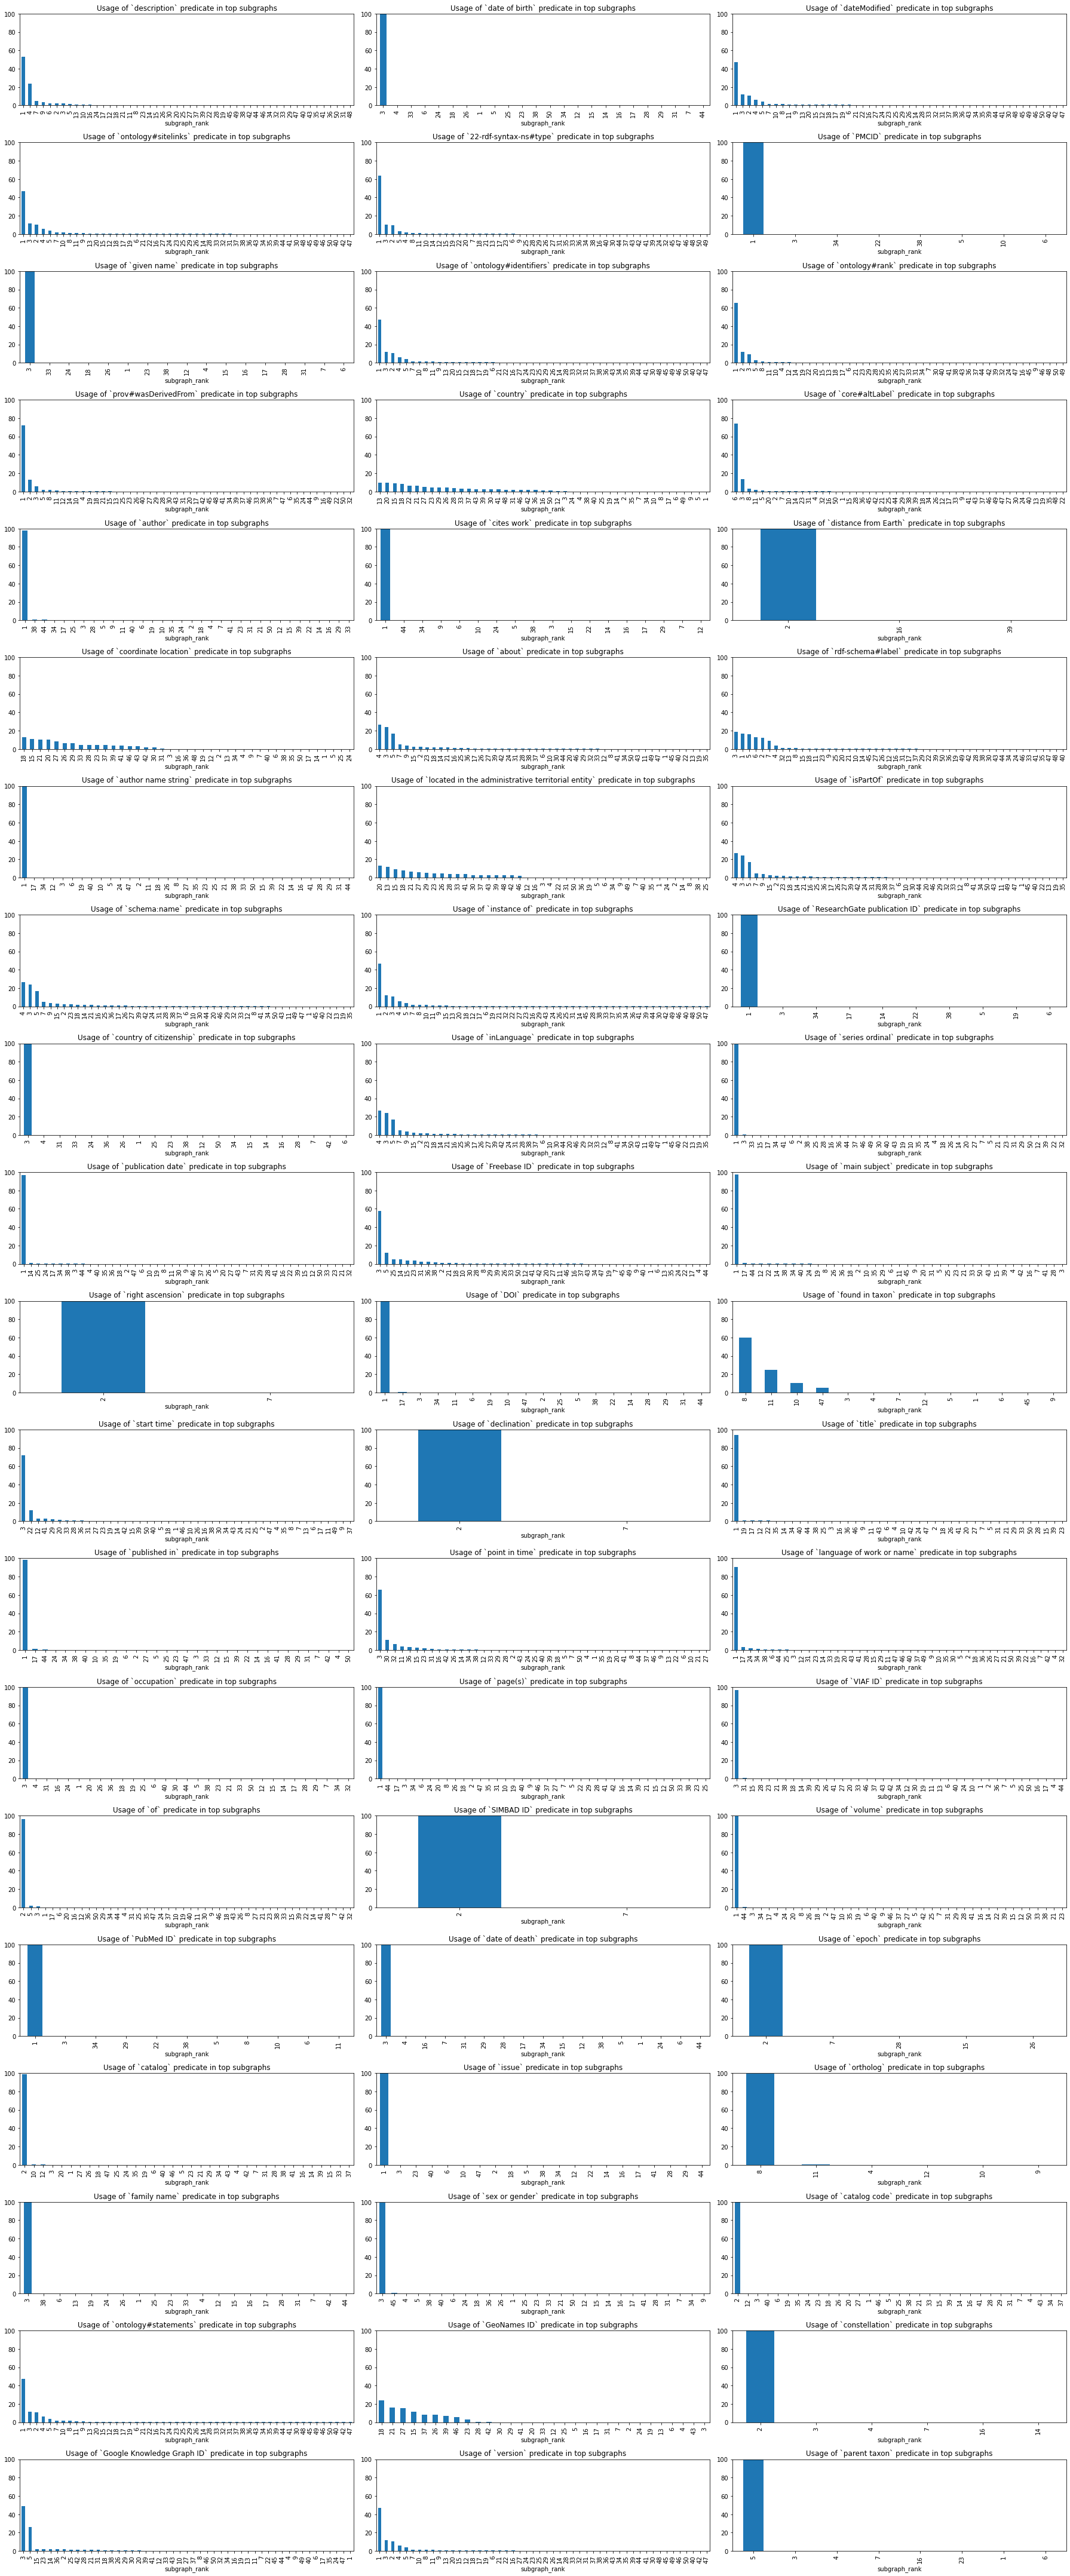

In [44]:
fig, axes = plt.subplots(nrows=20, ncols=3, figsize=(25,60))
r, c = 0, 0

for pred in predList:
    df = pred_subgraph_perc[pred_subgraph_perc['predicate_label'] == pred].sort_values('percentage', ascending=False)
    df.plot.bar(ax=axes[r,c], x='subgraph_rank', y='percentage', legend=False, title='Usage of `'+pred+'` predicate in top subgraphs', ylim=(0,100))
    r = (r+1)%20
    c = (c+1)%3
    
plt.tight_layout()
plt.savefig('60_preds_powerlaw.png', facecolor='white', edgecolor='none')

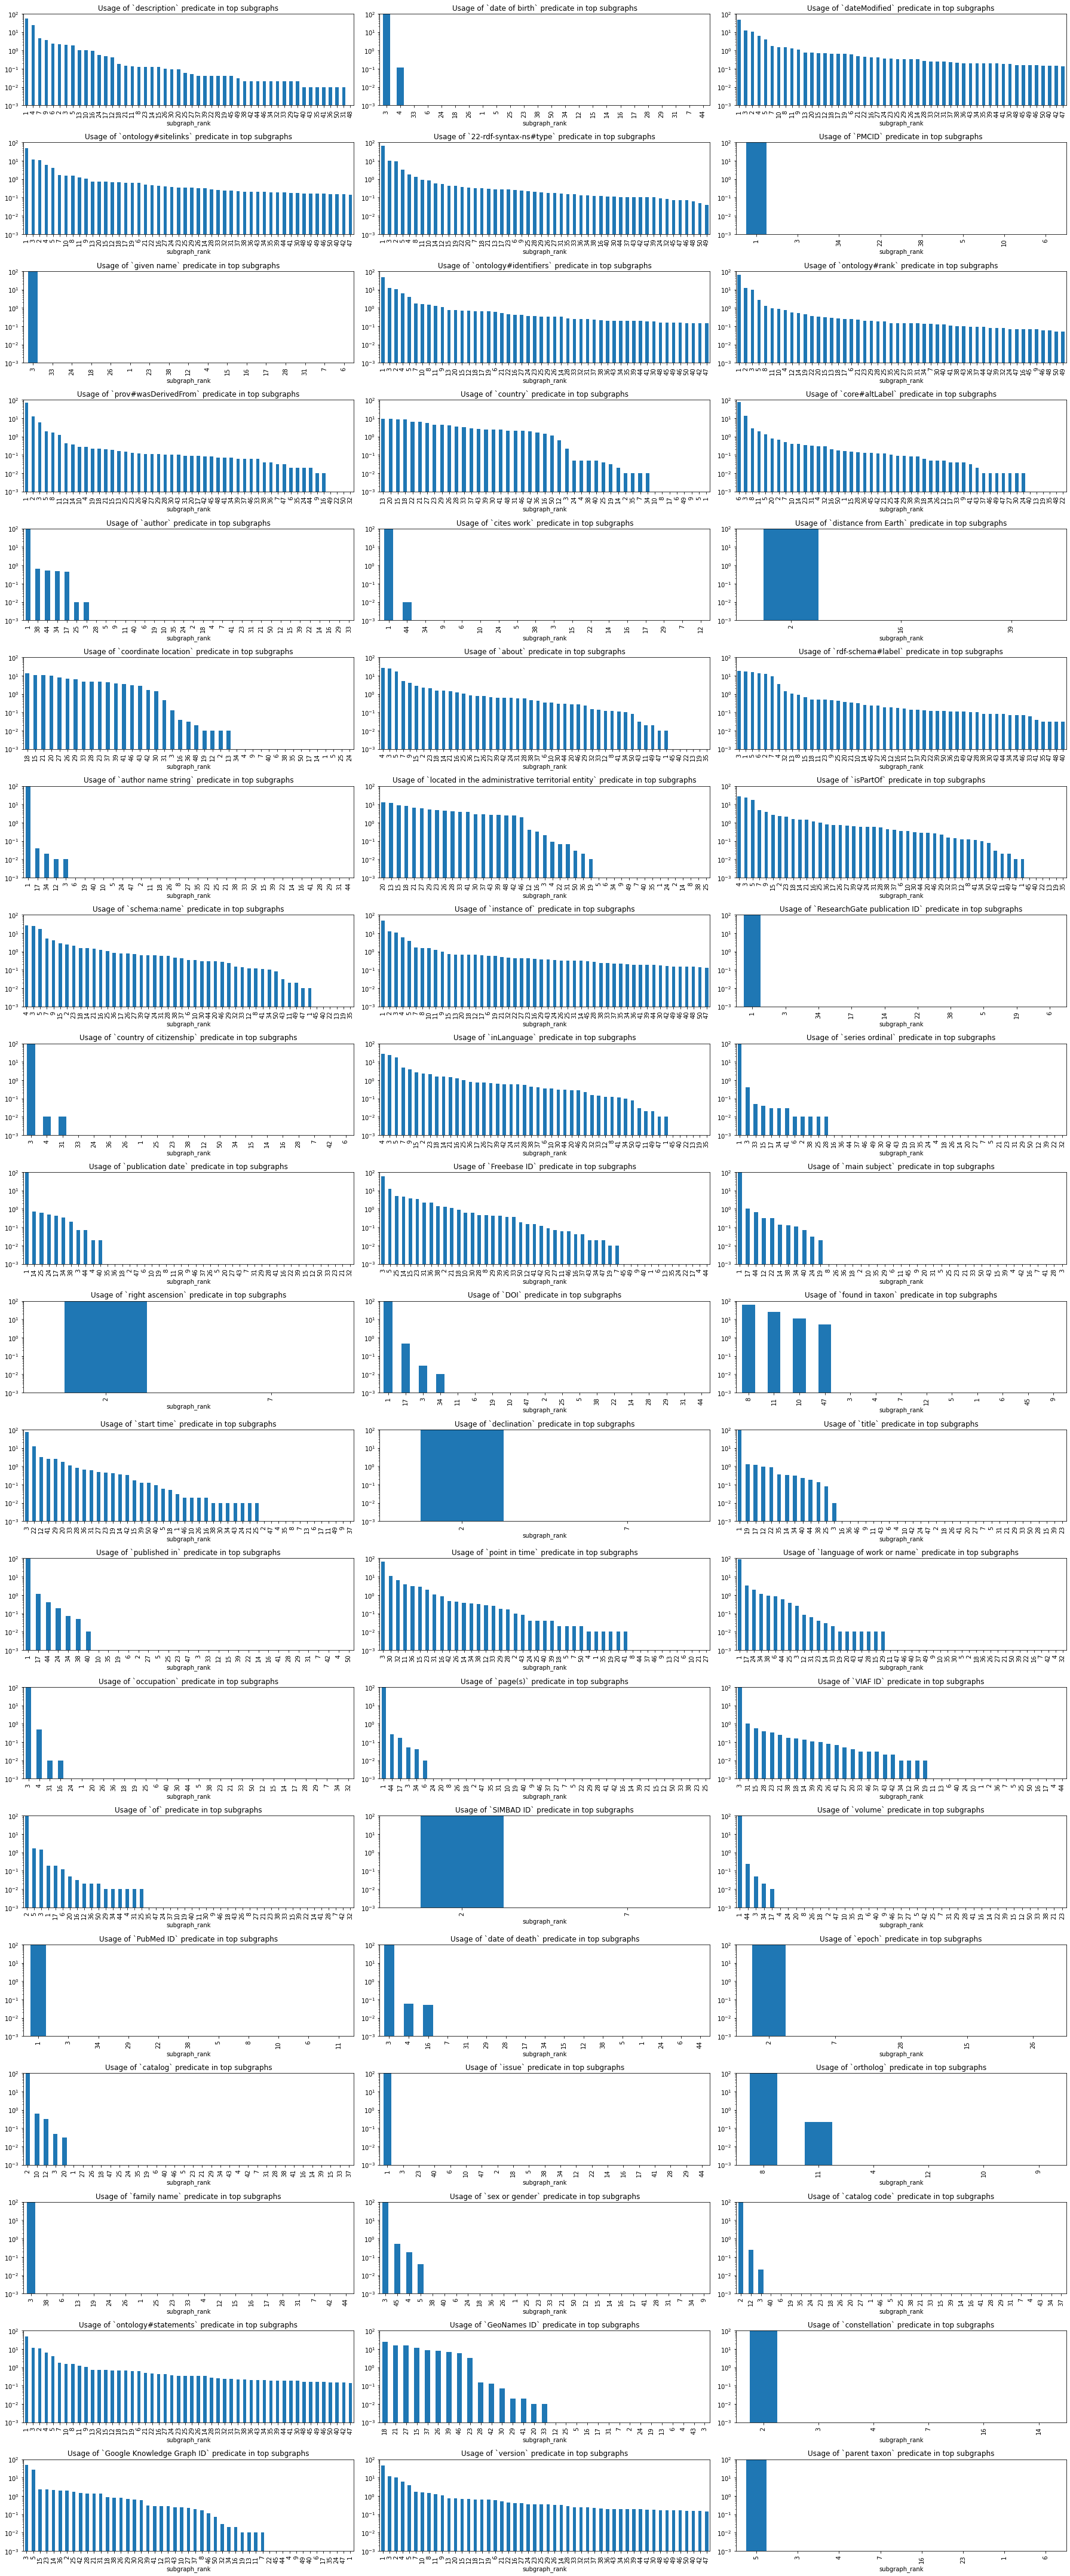

In [45]:
fig, axes = plt.subplots(nrows=20, ncols=3, figsize=(25,60))
r, c = 0, 0

for pred in predList:
    df = pred_subgraph_perc[pred_subgraph_perc['predicate_label'] == pred].sort_values('percentage', ascending=False)
    df.plot.bar(ax=axes[r,c], x='subgraph_rank', y='percentage', legend=False, title='Usage of `'+pred+'` predicate in top subgraphs', ylim=(0.001,100), logy=True)
    r = (r+1)%20
    c = (c+1)%3
    
plt.tight_layout()
plt.savefig('60_preds_powerlaw_log.png', facecolor='white', edgecolor='none')

## Properties usage analysis
### Metric for cross coverage/connectivity/subgraph overlaps based on properties

In [8]:
subgraph_pred_df_info = pd.read_csv('subgraph_pred_df_info.csv')
# subgraph_pred_df_info.head(5)

In [9]:
subgraph_size = pd.read_csv('subgraph_size.csv')
# subgraph_size

In [10]:
## top 3 usage of a predicate
top_pred = subgraph_pred_df_info.rename(columns={'count':'pred_count'}).groupby('predicate_label')\
                                .agg(
                                        sum = pd.NamedAgg('pred_count','sum'),
                                        count = pd.NamedAgg('pred_count','count'),
                                        max = pd.NamedAgg('pred_count','max'),
                                        second_max = pd.NamedAgg('pred_count',lambda x: x.nlargest(2,keep='first').tail(1).sum()),
                                        third_max = pd.NamedAgg('pred_count',lambda x: x.nlargest(3,keep='first').tail(1).sum()),
                                    )
top_pred = top_pred[top_pred['count']>1]
top_pred = top_pred.sort_values('count', ascending=False)
top_pred['max%'] = top_pred['max']*100/top_pred['sum']
top_pred['max2%'] = top_pred['second_max']*100/top_pred['sum']
top_pred['diff1'] = top_pred['max'] - top_pred['second_max']
top_pred['diff1%'] = (top_pred['max'] - top_pred['second_max'])*100/top_pred['max']
top_pred['diff2'] = top_pred['second_max'] - top_pred['third_max']
top_pred['diff2%'] = (top_pred['second_max'] - top_pred['third_max'])*100/top_pred['second_max']

top_pred

sum  count         max  \
predicate_label                                                            
version                                      79377439     50    37362640   
description                                2494215823     50  1324177494   
ontology#sitelinks                           79377422     50    37362641   
core#altLabel                                69166128     50    51377678   
prov#wasDerivedFrom                         991249731     50   714004630   
...                                               ...    ...         ...   
PeakFinder ID                                     171      2         153   
Pays de la Loire inventory identifier              18      2          12   
Patrons de France ID                             1014      2        1011   
Patreon ID                                       1505      2        1481   
Český hudební slovník osob a institucí ID        9801      2        9798   

                                           second_max  third_max       max%  \
predicate_label                                                               
version                                       9315444    8412914  47.069596   
description                                 596672076  112264922  53.089932   
ontology#sitelinks                            9315444    8412914  47.069608   
core#altLabel                                 9320641    1958029  74.281559   
prov#wasDerivedFrom                         128331955   56970478  72.030751   
...                                               ...        ...        ...   
PeakFinder ID                                      18         18  89.473684   
Pays de la Loire inventory identifier               6          6  66.666667   
Patrons de France ID                                3          3  99.704142   
Patreon ID                                         24         24  98.405316   
Český hudební slovník osob a institucí ID           3          3  99.969391   

                                               max2%      diff1     diff1%  \
predicate_label                                                              
version                                    11.735632   28047196  75.067490   
description                                23.922231  727505418  54.940174   
ontology#sitelinks                         11.735634   28047197  75.067491   
core#altLabel                              13.475730   42057037  81.858579   
prov#wasDerivedFrom                        12.946481  585672675  82.026453   
...                                              ...        ...        ...   
PeakFinder ID                              10.526316        135  88.235294   
Pays de la Loire inventory identifier      33.333333          6  50.000000   
Patrons de France ID                        0.295858       1008  99.703264   
Patreon ID                                  1.594684       1457  98.379473   
Český hudební slovník osob a institucí ID   0.030609       9795  99.969382   

                                               diff2     diff2%  
predicate_label                                                  
version                                       902530   9.688534  
description                                484407154  81.184821  
ontology#sitelinks                            902530   9.688534  
core#altLabel                                7362612  78.992550  
prov#wasDerivedFrom                         71361477  55.606943  
...                                              ...        ...  
PeakFinder ID                                      0   0.000000  
Pays de la Loire inventory identifier              0   0.000000  
Patrons de France ID                               0   0.000000  
Patreon ID                                         0   0.000000  
Český hudební slovník osob a institucí ID          0   0.000000  

[3851 rows x 11 columns]

In [97]:
len(all_pred), len(all_pred[all_pred['count']==1]), len(all_pred[all_pred['count']>1]), len(top_pred)

(7418, 3567, 3851, 3851)

In [439]:
## One subgraph predicates

preds = all_pred[all_pred['count']==1].index.values
subgraph_pred_df_info[subgraph_pred_df_info['predicate_label'].isin(preds)][['subgraph_label&rank','predicate_label','count']]\
                                                            .sort_values('count', ascending=False).iloc[:50]

subgraph_label&rank  \
31471  astronomical object (2)   
31515  astronomical object (2)   
31525  astronomical object (2)   
31519  astronomical object (2)   
31541  astronomical object (2)   
31495  astronomical object (2)   
31475  astronomical object (2)   
31545  astronomical object (2)   
31259    scholarly article (1)   
31552  astronomical object (2)   
17844                human (3)   
10368                human (3)   
31486  astronomical object (2)   
30972                taxon (5)   
30882                taxon (5)   
14126                human (3)   
22817                human (3)   
31503  astronomical object (2)   
31496  astronomical object (2)   
11036                human (3)   
30924                taxon (5)   
5115                 human (3)   
31124                taxon (5)   
31849        prime number (49)   
31805          family name (6)   
11446                human (3)   
21154                human (3)   
8787                 human (3)   
9656                 human (3)   
22927                human (3)   
31841           cell line (45)   
31837           cell line (45)   
21715                human (3)   
31845        prime number (49)   
31846        prime number (49)   
11266                human (3)   
31467  astronomical object (2)   
31474  astronomical object (2)   
31464  astronomical object (2)   
15016                human (3)   
7573                 human (3)   
802                  human (3)   
686                  human (3)   
31042                taxon (5)   
20452                human (3)   
31061                taxon (5)   
18373                human (3)   
31479  astronomical object (2)   
31497  astronomical object (2)   
31517  astronomical object (2)   

                                         predicate_label      count  
31471                                 apparent magnitude  113616097  
31515                                      proper motion   49968595  
31525                                astronomical filter   33104435  
31519                                           parallax   27012229  
31541                                    radial velocity   22162019  
31495                                           redshift    4826204  
31475                              effective temperature    3625324  
31545                                    surface gravity    3059274  
31259                            CJFD journal article ID    2915210  
31552                                     spectral class    2855290  
17844                              The Peerage person ID    2156308  
10368                                            CBDB ID    1267943  
31486                                        metallicity    1083683  
30972                             MycoBank taxon name ID    1009413  
30882                                  Index Fungorum ID     958229  
14126                                   doctoral student     879089  
22817                   Mathematics Genealogy Project ID     783448  
31503                        Minor Planet Center body ID     742263  
31496                     JPL Small-Body Database SPK-ID     706988  
11036                                 WikiTree person ID     661919  
30924                                           WCSPF ID     539525  
5115                                 Geni.com profile ID     533790  
31124                              BOLD Systems taxon ID     529485  
31849                           number of decimal digits     510176  
31805                                    Géopatronyme ID     468397  
11446                                Olympedia people ID     465690  
21154                                       MR Author ID     448309  
8787                             Transfermarkt player ID     414050  
9656                        Terezín Memorial Database ID     407718  
22927            Sports-Reference.com Olympic athlete ID     398947  
31841                         derived from organism type     389406  
31837                               

### Max%

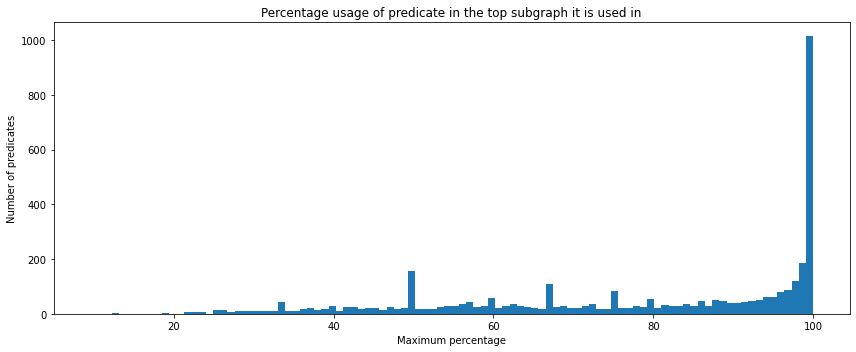

In [101]:
ax = top_pred['max%'].plot.hist(bins=100, figsize=(12,5),title='Percentage usage of predicate in the top subgraph it is used in')
ax.set(xlabel='Maximum percentage', ylabel='Number of predicates');
plt.tight_layout()
plt.savefig('perc_pred_usage.png')

In [444]:
len(top_pred[top_pred['max%']>=99])

1032

In [445]:
top_pred[top_pred['max%']>=99].sort_values('second_max', ascending=False)

sum  count        max  second_max  third_max  \
predicate_label                                                               
series ordinal           155278457     42  154240932      654345      82777   
DOI                      135309281     19  134618991      629108      40399   
page(s)                  104911623     40  104343883      268719     181187   
volume                   104114833     41  103761064      254537      53499   
catalog code              85828413     33   85591425      202909      16559   
...                            ...    ...        ...         ...        ...   
NooSFere author ID           18596      2      18595           1          1   
temple name                    314      2        313           1          1   
member of military unit       4235      2       4234           1          1   
killed by                     4507      2       4506           1          1   
is pollinator of               160      2        159           1          1   

                              max%      diff1     diff1%   diff2    diff2%  
predicate_label                                                             
series ordinal           99.331829  153586587  99.575764  571568  0.370568  
DOI                      99.489843  133989883  99.532675  588709  0.437315  
page(s)                  99.458840  104075164  99.742468   87532  0.083888  
volume                   99.660213  103506527  99.754689  201038  0.193751  
catalog code             99.723882   85388516  99.762933  186350  0.217720  
...                            ...        ...        ...     ...       ...  
NooSFere author ID       99.994622      18594  99.994622       0  0.000000  
temple name              99.681529        312  99.680511       0  0.000000  
member of military unit  99.976387       4233  99.976382       0  0.000000  
killed by                99.977812       4505  99.977807       0  0.000000  
is pollinator of         99.375000        158  99.371069       0  0.000000  

[1032 rows x 10 columns]

In [446]:
top_pred[top_pred['max%']>=99]['second_max'].describe()

count      1032.000000
mean       2735.371124
std       31989.889819
min           1.000000
25%           3.000000
50%           7.000000
75%          45.000000
max      654345.000000
Name: second_max, dtype: float64

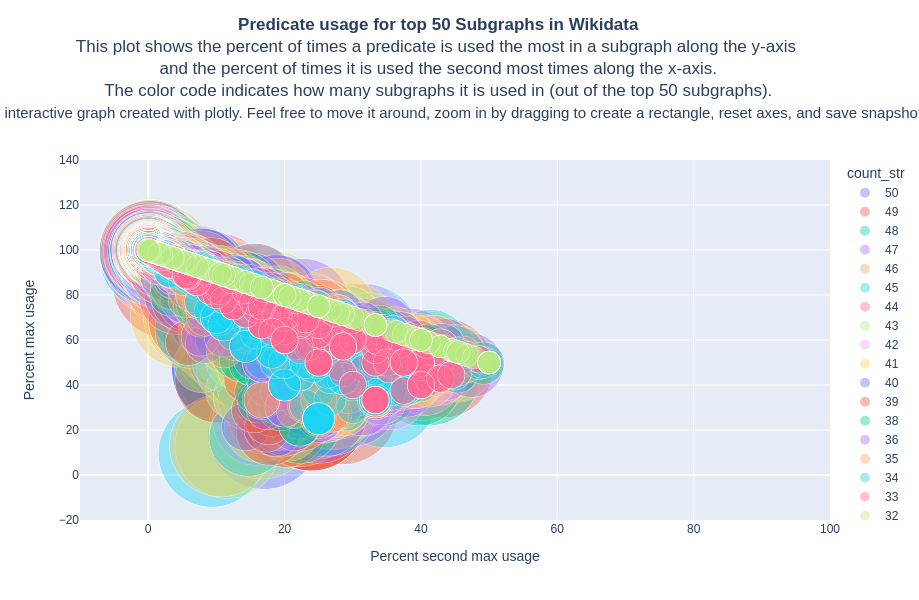

In [65]:
top_pred['count_str'] = top_pred['count'].astype(str)
tmp = top_pred.reset_index()
tmp = tmp[['predicate_label', 'count', 'max', 'second_max', 'max%', 'max2%', 'count_str']]
tmp.columns = ['Predicate', 'Number of Subgraph it is in', 'Max count in a subgraph', 
               'Second max count in a subgraph', 'Percent max usage', 'Percent second max usage', 'count_str']
title = """
        <b>Predicate usage for top 50 Subgraphs in Wikidata</b>
        <br>This plot shows the percent of times a predicate is used the most in a subgraph along the y-axis 
        <br>and the percent of times it is used the second most times along the x-axis.
        <br>The color code indicates how many subgraphs it is used in (out of the top 50 subgraphs).
        <br><span style="font-size:15px;">This is an interactive graph created with plotly. Feel free to move it around, zoom in by dragging to create a rectangle, reset axes, and save snapshots as png.</span>
        """
fig = px.scatter(tmp, 
                 size="Number of Subgraph it is in", 
                 color= "count_str",#"Number of Subgraph it is in", #
#                  hover_name="Predicate",
                 size_max=80,
                 y='Percent max usage',
                 x='Percent second max usage',
#                  hover_data={'count_str':False, ## ordering is not maintained
#                              'Number of Subgraph it is in': True,
#                              'Max count in a subgraph':True,
#                              'Second max count in a subgraph':True,
#                              'Percent max usage':True,
#                              'Percent second max usage':True
#                             },
                 width=1300, height=600,
#                  color_discrete_sequence = col
                 custom_data=['Predicate', 'Number of Subgraph it is in', 
                              'Max count in a subgraph', 'Second max count in a subgraph', 
                              'Percent max usage', 'Percent second max usage']
                )
fig.update_traces(hovertemplate =
                    '<b>Predicate: %{customdata[0]}</b>'+
                    '<br>Number of Subgraph it is in: %{customdata[1]}'+
                    '<br>Max count in a subgraph: %{customdata[2]} (<b>%{customdata[4]:.2f}%</b>)'+
                    '<br>Second max count in a subgraph: %{customdata[3]} (%{customdata[5]:.2f}%)',
                 marker=dict(opacity=0.4))
fig.update_layout(title_text=title, title_x=0.5, title_y=.95, margin_t=160)
fig.update_yaxes(range=[-20, 140])
fig.update_xaxes(range=[-10, 100])
fig.write_html("predicate_usage.html")
fig.show()

# Subgraph pair predicate analysis

In [6]:
subgraph_pred_df_info = pd.read_csv('subgraph_pred_df_info.csv')

In [7]:
df = pd.DataFrame(columns=subgraph_pred_df_info.label.unique(), index=subgraph_pred_df_info.label.unique())
for subgraph in subgraph_pred_df_info.label.unique():
    for subgraph2 in subgraph_pred_df_info.label.unique():
        df.loc[subgraph, subgraph2] = df.loc[subgraph2, subgraph] = len(subgraph_pred_df_info[subgraph_pred_df_info['label'].isin([subgraph, subgraph2])]\
                                .groupby('predicate_label').agg({'count':'count'}).query('count > 1'))

In [14]:
df.to_csv('subgraph_pair_predicates.csv')

In [8]:
pd.set_option('display.max_colwidth', None)

In [9]:
df.max().max()

1286

In [10]:
df_styled = df.apply(pd.to_numeric).style.background_gradient(cmap='Reds', vmax=1300, vmin=0, axis=None)
df_styled

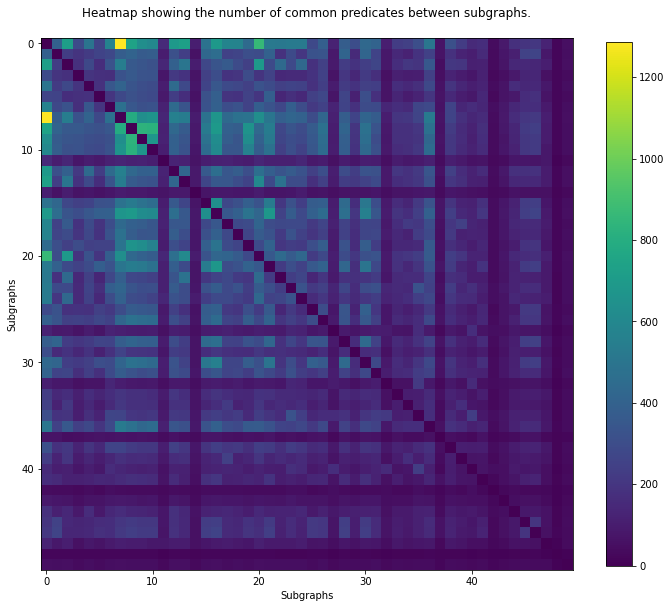

In [22]:
plt.figure(figsize=(10,10))
heatmap = plt.imshow(df.apply(pd.to_numeric))
plt.colorbar(heatmap, shrink=0.75)
plt.title("Heatmap showing the number of common predicates between subgraphs.\n")
plt.xlabel("Subgraphs")
plt.ylabel("Subgraphs")
plt.tight_layout()
plt.savefig('subgraph_pair_predicate.png')

In [173]:
cols = df.columns
ln = len(cols)

subgraph1, subgraph2, vals = [], [], []

for i in range(ln):
    for j in range(i+1,ln):
        val = df.loc[cols[i],cols[j]]
        if val>0:
            subgraph1.append(cols[i])
            subgraph2.append(cols[j])
            vals.append(val)
            
nonzero_subgraph_predicate_pair = pd.DataFrame({'subgraph1': subgraph1, 'subgraph2':subgraph2, 'value':vals}).sort_values('value', ascending=False)

In [175]:
nonzero_subgraph_predicate_pair.to_csv('nonzero_subgraph_predicate_pair.csv', index=False)

In [176]:
nonzero_subgraph_predicate_pair

subgraph1                     subgraph2  value
6                      human                      business   1286
19                     human                 literary work    862
364                 building               church building    832
365                 building       architectural structure    821
322                 business                      building    791
...                      ...                           ...    ...
1222    biographical article            branch post office     13
1202               cell line            branch post office     12
1187                 protein            branch post office     12
1087  group of stereoisomers            branch post office     12
1224      branch post office  calendar day of a given year     12

[1225 rows x 3 columns]

# Items overlap in subgraphs (In top 50 subgraphs for now)

## Item analysis

In [72]:
subgraph_code_label = spark.createDataFrame(top_instances[['code', 'label']])
subgraph_code_label

DataFrame[code: string, label: string]

In [107]:
uri2code = F.udf(lambda uri: uri.split('/')[-1][:-1])

shared_items = all_items.withColumn('code', uri2code(F.col('subgraph'))).join(subgraph_code_label, 'code', 'left')
shared_items = shared_items.groupby('item')\
                        .agg(
                            F.count('subgraph').alias('subgraph_count'), 
                            F.concat_ws('|',F.collect_list(shared_items.label)).alias('subgraph_list'),
                            F.concat_ws('|',F.collect_list(shared_items.code)).alias('subgraph_code_list')
                         )\
                         .filter("subgraph_count > 1")\
                         .sort("subgraph_count", ascending=False)

shared_items

DataFrame[item: string, subgraph_count: bigint, subgraph_list: string, subgraph_code_list: string]

In [56]:
shared_items.count()

40289

In [108]:
shared_items_df = shared_items.toPandas()

In [109]:
shared_items_df.head()

item  subgraph_count  \
0  <http://www.wikidata.org/entity/Q20574741>               3   
1  <http://www.wikidata.org/entity/Q12033895>               3   
2  <http://www.wikidata.org/entity/Q28089595>               3   
3  <http://www.wikidata.org/entity/Q13663087>               3   
4  <http://www.wikidata.org/entity/Q20571744>               3   

                     subgraph_list    subgraph_code_list  
0  hamlet|village|human settlement    Q5084|Q532|Q486972  
1         river|watercourse|stream  Q4022|Q355304|Q47521  
2         river|stream|watercourse  Q4022|Q47521|Q355304  
3  hamlet|village|human settlement    Q5084|Q532|Q486972  
4  village|human settlement|hamlet    Q532|Q486972|Q5084

In [76]:
shared_items_df['subgraph_count'].value_counts()

2    40232
3       57
Name: subgraph_count, dtype: int64

In [83]:
shared_items_df[shared_items_df['subgraph_count']==3].head(50)

item  subgraph_count  \
0   <http://www.wikidata.org/entity/Q13662863>               3   
1   <http://www.wikidata.org/entity/Q12517998>               3   
2     <http://www.wikidata.org/entity/Q871136>               3   
3   <http://www.wikidata.org/entity/Q13666826>               3   
4    <http://www.wikidata.org/entity/Q4464652>               3   
5   <http://www.wikidata.org/entity/Q20664190>               3   
6    <http://www.wikidata.org/entity/Q4242731>               3   
7   <http://www.wikidata.org/entity/Q12142210>               3   
8   <http://www.wikidata.org/entity/Q56887149>               3   
9   <http://www.wikidata.org/entity/Q18230784>               3   
10   <http://www.wikidata.org/entity/Q4322183>               3   
11  <http://www.wikidata.org/entity/Q97688789>               3   
12  <http://www.wikidata.org/entity/Q12033895>               3   
13   <http://www.wikidata.org/entity/Q2892231>               3   
14  <http://www.wikidata.org/entity/Q28089595>               3   
15  <http://www.wikidata.org/entity/Q20663846>               3   
16  <http://www.wikidata.org/entity/Q20577547>               3   
17  <http://www.wikidata.org/entity/Q13663087>               3   
18   <http://www.wikidata.org/entity/Q4952904>               3   
19  <http://www.wikidata.org/entity/Q32819162>               3   
20   <http://www.wikidata.org/entity/Q3216608>               3   
21  <http://www.wikidata.org/entity/Q21449969>               3   
22  <http://www.wikidata.org/entity/Q12154446>               3   
23  <http://www.wikidata.org/entity/Q12680092>               3   
24  <http://www.wikidata.org/entity/Q20663815>               3   
25  <http://www.wikidata.org/entity/Q20571024>               3   
26  <http://www.wikidata.org/entity/Q97622812>               3   
27  <http://www.wikidata.org/entity/Q14612484>               3   
28  <http://www.wikidata.org/entity/Q13662749>               3   
29  <http://www.wikidata.org/entity/Q29892004>               3   
30  <http://www.wikidata.org/entity/Q13663072>               3   
31  <http://www.wikidata.org/entity/Q20571744>               3   
32  <http://www.wikidata.org/entity/Q20571421>               3   
33    <http://www.wikidata.org/entity/Q827222>               3   
34  <http://www.wikidata.org/entity/Q16696845>               3   
35  <http://www.wikidata.org/entity/Q13662790>               3   
36  <http://www.wikidata.org/entity/Q13662753>               3   
37  <http://www.wikidata.org/entity/Q15118894>               3   
38  <http://www.wikidata.org/entity/Q29785960>               3   
39  <http://www.wikidata.org/entity/Q20571302>               3   
40  <http://www.wikidata.org/entity/Q97631010>               3   
41   <http://www.wikidata.org/entity/Q4415895>               3   
42   <http://www.wikidata.org/entity/Q1961403>               3   
43  <http://www.wikidata.org/entity/Q18986775>               3   
44  <http://www.wikidata.org/entity/Q13663105>               3   
45  <http://www.wikidata.org/entity/Q25689900>               3   
46  <http://www.wikidata.org/entity/Q16657653>               3   
47   <http://www.wikidata.org/entity/Q4181799>               3   
48  <http://www.wikidata.org/entity/Q20664197>               3   
49  <http://www.wikidata.org/entity/Q13663092>               3   

                                                                     subgraph_list  \
0                                                village, hamlet, human settlement   
1                                                      village, watercourse, river   
2   literary work, Wikimedia disambiguation page, version, edition, or translation   
3                                                village, hamlet, human settlement   
4                                                village, hamlet, human settlement   
5                                                hamlet, human settlement, village   
6                                                village, hamlet, human s

In [84]:
shared_items_df[shared_items_df['subgraph_count']==2].head(50)

item  subgraph_count  \
57   <http://www.wikidata.org/entity/Q107326556>               2   
58     <http://www.wikidata.org/entity/Q1148759>               2   
59      <http://www.wikidata.org/entity/Q122144>               2   
60    <http://www.wikidata.org/entity/Q15109808>               2   
61    <http://www.wikidata.org/entity/Q16715334>               2   
62    <http://www.wikidata.org/entity/Q16723649>               2   
63    <http://www.wikidata.org/entity/Q19362293>               2   
64    <http://www.wikidata.org/entity/Q20457610>               2   
65    <http://www.wikidata.org/entity/Q20466820>               2   
66    <http://www.wikidata.org/entity/Q21343363>               2   
67    <http://www.wikidata.org/entity/Q21963893>               2   
68    <http://www.wikidata.org/entity/Q22444272>               2   
69    <http://www.wikidata.org/entity/Q23695432>               2   
70    <http://www.wikidata.org/entity/Q23696409>               2   
71    <http://www.wikidata.org/entity/Q23697989>               2   
72    <http://www.wikidata.org/entity/Q23702630>               2   
73    <http://www.wikidata.org/entity/Q24821222>               2   
74    <http://www.wikidata.org/entity/Q24897176>               2   
75    <http://www.wikidata.org/entity/Q24966085>               2   
76    <http://www.wikidata.org/entity/Q25049287>               2   
77    <http://www.wikidata.org/entity/Q25175433>               2   
78    <http://www.wikidata.org/entity/Q25222395>               2   
79    <http://www.wikidata.org/entity/Q25300256>               2   
80    <http://www.wikidata.org/entity/Q28226881>               2   
81    <http://www.wikidata.org/entity/Q28226990>               2   
82    <http://www.wikidata.org/entity/Q28227044>               2   
83    <http://www.wikidata.org/entity/Q28227467>               2   
84    <http://www.wikidata.org/entity/Q28232601>               2   
85    <http://www.wikidata.org/entity/Q28256144>               2   
86    <http://www.wikidata.org/entity/Q28309000>               2   
87    <http://www.wikidata.org/entity/Q28314543>               2   
88    <http://www.wikidata.org/entity/Q28314971>               2   
89    <http://www.wikidata.org/entity/Q29933244>               2   
90    <http://www.wikidata.org/entity/Q30066051>               2   
91    <http://www.wikidata.org/entity/Q30232699>               2   
92     <http://www.wikidata.org/entity/Q3667808>               2   
93     <http://www.wikidata.org/entity/Q4109952>               2   
94    <http://www.wikidata.org/entity/Q42403564>               2   
95     <http://www.wikidata.org/entity/Q7396278>               2   
96     <http://www.wikidata.org/entity/Q8242887>               2   
97    <http://www.wikidata.org/entity/Q92189257>               2   
98   <http://www.wikidata.org/entity/Q103930255>               2   
99    <http://www.wikidata.org/entity/Q11186203>               2   
100    <http://www.wikidata.org/entity/Q1143052>               2   
101   <http://www.wikidata.org/entity/Q12831376>               2   
102   <http://www.wikidata.org/entity/Q13164349>               2   
103   <http://www.wikidata.org/entity/Q14421779>               2   
104    <http://www.wikidata.org/entity/Q1741193>               2   
105   <http://www.wikidata.org/entity/Q21965260>               2   
106   <http://www.wikidata.org/entity/Q22561764>               2   

                                         subgraph_list    subgraph_code_list  
57     literary work, version, edition, or translation    Q7725634, Q3331189  
58                                       stream, river         Q47521, Q4022  
59                                       stream, river         Q47521, Q4022  
60            church building, architectural structure       Q16970, Q811979  
61                            human settlement, hamlet        Q486972, Q5084  
62                            human settlement, hamlet        Q486972, Q5084  
63                   a

## Subgraph pair analysis for items overlap

In [111]:
df = pd.DataFrame(0, columns=subgraph_pred_df_info.label.unique(), index=subgraph_pred_df_info.label.unique())

In [110]:
shared_items_df.head(5)

item  subgraph_count  \
0  <http://www.wikidata.org/entity/Q20574741>               3   
1  <http://www.wikidata.org/entity/Q12033895>               3   
2  <http://www.wikidata.org/entity/Q28089595>               3   
3  <http://www.wikidata.org/entity/Q13663087>               3   
4  <http://www.wikidata.org/entity/Q20571744>               3   

                     subgraph_list    subgraph_code_list  
0  hamlet|village|human settlement    Q5084|Q532|Q486972  
1         river|watercourse|stream  Q4022|Q355304|Q47521  
2         river|stream|watercourse  Q4022|Q47521|Q355304  
3  hamlet|village|human settlement    Q5084|Q532|Q486972  
4  village|human settlement|hamlet    Q532|Q486972|Q5084

In [115]:
for _,elem in shared_items_df.iterrows():
    grs = [e.strip() for e in elem['subgraph_list'].split('|')]
    for i in range(len(grs)):
        for j in range(i+1,len(grs)):
            df.loc[grs[i],grs[j]] += 1
            df.loc[grs[j],grs[i]] += 1

In [116]:
pd.set_option('display.max_colwidth', None)

In [117]:
df.max().max()

37102

In [118]:
df.apply(pd.to_numeric).style.background_gradient(cmap='Reds', vmax=37102, vmin=0, axis=None)

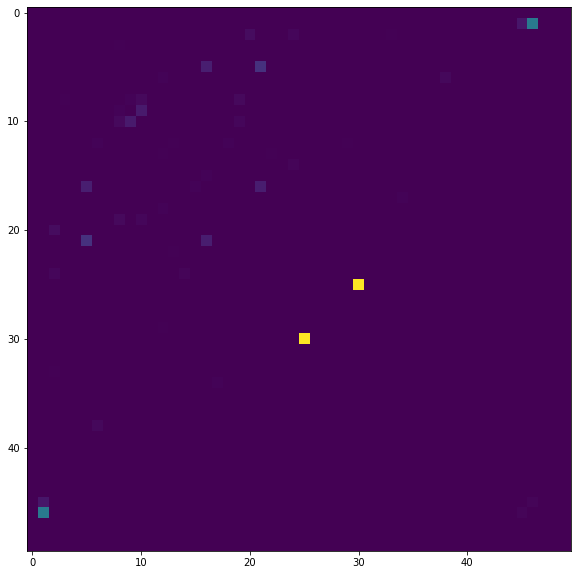

In [120]:
plt.figure(figsize=(10,10))
plt.imshow(df.apply(pd.to_numeric))

In [133]:
cols = df.columns
ln = len(cols)

subgraph1, subgraph2, vals = [], [], []

for i in range(ln):
    for j in range(i+1,ln):
        val = df.loc[cols[i],cols[j]]
        if val>0:
            subgraph1.append(cols[i])
            subgraph2.append(cols[j])
            vals.append(val)
            
nonzero_subgraph_pair = pd.DataFrame({'subgraph1': subgraph1, 'subgraph2':subgraph2, 'value':vals}).sort_values('value', ascending=False)

In [134]:
len(nonzero_subgraph_pair)

235

In [135]:
nonzero_subgraph_pair.iloc[:50]

subgraph1                         subgraph2  value
216                              hill                          mountain  37102
31                              river                       watercourse  14972
72                             hamlet                           village   5282
71                             hamlet                  human settlement   3120
173                  human settlement                           village   2986
119                   church building           architectural structure   2622
30                              river                            stream   2204
39   version, edition, or translation                     literary work   1304
107                          building           architectural structure    946
111                          building                             house    942
91      Wikimedia disambiguation page                       family name    810
131           architectural structure                             house    658
41   version, edition, or translation                 scholarly article    640
234                            stream                       watercourse    566
163                    clinical trial                 scholarly article    562
164                            island                  human settlement    432
106                          building                   church building    380
143            Wikimedia list article                          position    330
188                          painting  item of collection or exhibition    324
78      Wikimedia disambiguation page            Wikimedia list article    294
150            Wikimedia list article                     sports season    236
47                     primary school                          building    190
42   version, edition, or translation                  Wikinews article    166
159                              film                             album    162
140            Wikimedia list article                              film    146
165                            island                           village    144
181                  human settlement                  village in India    142
40   version, edition, or translation                             album    122
36   version, edition, or translation            Wikimedia list article    118
95                           business                          building    116
195                     literary work                 scholarly article    112
168                            island                          mountain    104
97                           business            Wikimedia list article    100
189                          painting                             print     82
178                  human settlement                          mountain     82
157                              film                     literary work     74
54                 Wikimedia category            Wikimedia list article     66
179                  human settlement   village-level division in China     60
138              encyclopedia article                 scholarly article     60
121                   church building                  human settlement     54
174                  human settlement                              hill     54
198                     literary work                        collection     52
222                              gene                Wikimedia template     52
65                 Wikimedia category                Wikimedia template     48
184                  human settlement                       watercourse     48
110                          building                  human settlement     48
130           architectural structure                  human settlement     46
116                          building                            street     44
215                              hill                            street     44
197                     literary work  item of collection or exhibition     42

In [158]:
nonzero_subgraph_pair_detail = \
pd.merge(
        pd.merge(
                subgraph_size[['label', 'item_count']], nonzero_subgraph_pair, left_on='label', right_on='subgraph1')\
                .drop(columns='label')\
                .rename(columns={'item_count':'subgraph1_item_count'}
                ),
        subgraph_size[['label', 'item_count']], right_on='label', left_on='subgraph2'
        )\
        .drop(columns='label')\
        .rename(columns={'item_count':'subgraph2_item_count'})\
        .sort_values('value', ascending=False)[['subgraph1', 'subgraph2', 'subgraph1_item_count', 'subgraph2_item_count', 'value']]\

In [159]:
len(nonzero_subgraph_pair_detail), len(nonzero_subgraph_pair)

(235, 235)

In [163]:
nonzero_subgraph_pair_detail['subgraph1_item_count%'] = (nonzero_subgraph_pair_detail['value']*100/nonzero_subgraph_pair_detail['subgraph1_item_count']).round(2)
nonzero_subgraph_pair_detail['subgraph2_item_count%'] = (nonzero_subgraph_pair_detail['value']*100/nonzero_subgraph_pair_detail['subgraph2_item_count']).round(2)

In [167]:
nonzero_subgraph_pair_detail = nonzero_subgraph_pair_detail.sort_values(['subgraph1_item_count%', 'subgraph2_item_count%'], ascending=False)

#### Find mistakes in wikidata with this analysis?

In [171]:
nonzero_subgraph_pair_detail.head(10)

subgraph1                subgraph2  \
88                               hill                 mountain   
55                             hamlet                  village   
184                             river              watercourse   
148                            hamlet         human settlement   
123                   church building  architectural structure   
115  version, edition, or translation            literary work   
215                             river                   stream   
45                   human settlement                  village   
108           architectural structure                    house   
188                            stream              watercourse   

     subgraph1_item_count  subgraph2_item_count  value  subgraph1_item_count%  \
88                 327277                525553  37102                  11.34   
55                 118188                274840   5282                   4.47   
184                399552                174620  14972                   3.75   
148                118188                563958   3120                   2.64   
123                211291                145957   2622                   1.24   
115                157486                164860   1304                   0.83   
215                399552                124853   2204                   0.55   
45                 563958                274840   2986                   0.53   
108                145957                197736    658                   0.45   
188                124853                174620    566                   0.45   

     subgraph2_item_count%  
88                    7.06  
55                    1.92  
184                   8.57  
148                   0.55  
123                   1.80  
115                   0.79  
215                   1.77  
45                    1.09  
108                   0.33  
188                   0.32

In [170]:
nonzero_subgraph_pair_detail.iloc[100:150]

subgraph1                         subgraph2  \
33                           human            Wikimedia list article   
91                            lake                          mountain   
57              Wikimedia category                  Wikinews article   
47                           river                           village   
42                           human                           village   
191                           gene                           protein   
225                       building                        collection   
61                           human                          painting   
56                           human                  Wikinews article   
150  Wikimedia disambiguation page                              lake   
71                           taxon                 scholarly article   
37                        building            Wikimedia list article   
23   Wikimedia disambiguation page                              film   
203                        village   village-level division in China   
5    Wikimedia disambiguation page                 chemical compound   
70                           human                 scholarly article   
17          Wikimedia list article                       family name   
169                  literary work                Wikimedia template   
67   Wikimedia disambiguation page                          business   
65                           human                          business   
171         Wikimedia list article      calendar day of a given year   
44   Wikimedia disambiguation page                           village   
38                 church building            Wikimedia list article   
209                church building                            street   
193               human settlement                     sports season   
85                          street                          mountain   
145                       business                  human settlement   
6                             gene                 chemical compound   
52                           house                           village   
186                           lake                       watercourse   
220                          river                            hamlet   
214               human settlement                            stream   
200                church building                  village in India   
159                           film  item of collection or exhibition   
176                       building                            island   
153         Wikimedia list article                              lake   
227                       business                        collection   
117             Wikimedia category                   church building   
82                           human                          mountain   
110  Wikimedia disambiguation page                     literary work   
77                           human                             taxon   
137                         hamlet                              hill   
87          Wikimedia list article                          mountain   
58          Wikimedia list article                  Wikinews article   
92                 church building                          mountain   
48          Wikimedia list article                           village   
96                          hamlet                          mountain   
80          Wikimedia list article                             taxon   
98              Wikimedia category                          position   
99   Wikimedia disambiguation page                          position   

     subgraph1_item_count  subgraph2_item_count  value  subgraph1_item_count%  \
33                9315444                334939     14                    0.0   
91                 260135                525553     12                    0.0   
57                4840195                286950     12                    0.0   
47                 399552   

In [166]:
nonzero_subgraph_pair_detail.to_csv('nonzero_subgraph_pair_detail.csv', index=False)

# Items as object

## Triple subgraph - object subgraph

In [60]:
triple_subgraph_object_subgraph = \
            all_subgraphs.select("subgraph", "object").distinct().alias('all_subgraphs')\
                         .join(all_items.alias('all_items'), col('all_subgraphs.object') == col('all_items.item'), "inner")\
                         .selectExpr("all_subgraphs.subgraph as triple_subgraph", "object",
                                     "all_items.subgraph as object_subgraph")\
                        .distinct()

triple_subgraph_object_subgraph.cache()
triple_subgraph_object_subgraph

DataFrame[triple_subgraph: string, object: string, object_subgraph: string]

In [37]:
## total triples in top 50 subgraphs ## took 30 minutes
triples = all_subgraphs.select('subject', 'predicate', 'object').distinct().count()

triples, triples*100/total_triples

(11284296417, 85.82154408434681)

In [ ]:
## total items in top 50 subgraphs ## 4 minutes
items = all_subgraphs.select('item').distinct().count()

items, items/940000.00

(79337202, 84.40127872340426)

In [61]:
triple_subgraph_object_subgraph.count()

49136958

In [64]:
subgraph_item_connection = triple_subgraph_object_subgraph.groupby(['triple_subgraph', 'object_subgraph']).count().sort('count', ascending=False)
subgraph_item_connection

DataFrame[triple_subgraph: string, object_subgraph: string, count: bigint]

In [65]:
subgraph_item_connection.count()

1509

In [67]:
subgraph_item_connection_df = subgraph_item_connection.toPandas()

In [77]:
subgraph_item_connection_df = pd.merge(subgraph_item_connection_df, subgraph_size[['subgraph', 'label']], left_on='triple_subgraph', right_on='subgraph').drop(columns='subgraph').rename(columns={'label':'triple_subgraph_label'})
subgraph_item_connection_df = pd.merge(subgraph_item_connection_df, subgraph_size[['subgraph', 'label']], left_on='object_subgraph', right_on='subgraph').drop(columns='subgraph').rename(columns={'label':'object_subgraph_label'})

In [80]:
subgraph_item_connection_df = subgraph_item_connection_df.sort_values('count', ascending=False)

In [82]:
subgraph_item_connection_df.to_csv('subgraph_item_connection_df.csv', index=False)

In [24]:
subgraph_item_connection_df = pd.read_csv('subgraph_item_connection_df.csv')

In [26]:
subgraph_item_connection_df[subgraph_item_connection_df['triple_subgraph_label']!=subgraph_item_connection_df['object_subgraph_label']].iloc[:50]

triple_subgraph  \
4   <http://www.wikidata.org/entity/Q13442814>   
6       <http://www.wikidata.org/entity/Q8054>   
7       <http://www.wikidata.org/entity/Q7187>   
15         <http://www.wikidata.org/entity/Q5>   
23     <http://www.wikidata.org/entity/Q11424>   
26  <http://www.wikidata.org/entity/Q13442814>   
29   <http://www.wikidata.org/entity/Q4167836>   
30     <http://www.wikidata.org/entity/Q16521>   
36   <http://www.wikidata.org/entity/Q4167410>   
38    <http://www.wikidata.org/entity/Q101352>   
42  <http://www.wikidata.org/entity/Q13442814>   
44         <http://www.wikidata.org/entity/Q5>   
45         <http://www.wikidata.org/entity/Q5>   
46  <http://www.wikidata.org/entity/Q13442814>   
47  <http://www.wikidata.org/entity/Q19389637>   
48         <http://www.wikidata.org/entity/Q5>   
49  <http://www.wikidata.org/entity/Q13442814>   
51   <http://www.wikidata.org/entity/Q3305213>   
52  <http://www.wikidata.org/entity/Q13433827>   
54   <http://www.wikidata.org/entity/Q4167836>   
56   <http://www.wikidata.org/entity/Q7725634>   
57     <http://www.wikidata.org/entity/Q16521>   
58  <http://www.wikidata.org/entity/Q13442814>   
59         <http://www.wikidata.org/entity/Q5>   
60  <http://www.wikidata.org/entity/Q13406463>   
61   <http://www.wikidata.org/entity/Q4167836>   
62   <http://www.wikidata.org/entity/Q3331189>   
63     <http://www.wikidata.org/entity/Q11173>   
65    <http://www.wikidata.org/entity/Q482994>   
68         <http://www.wikidata.org/entity/Q5>   
69  <http://www.wikidata.org/entity/Q59199015>   
70         <http://www.wikidata.org/entity/Q5>   
71  <http://www.wikidata.org/entity/Q21014462>   
72     <http://www.wikidata.org/entity/Q79007>   
73   <http://www.wikidata.org/entity/Q4830453>   
76         <http://www.wikidata.org/entity/Q5>   
77         <http://www.wikidata.org/entity/Q5>   
78         <http://www.wikidata.org/entity/Q5>   
79  <http://www.wikidata.org/entity/Q11060274>   
80     <http://www.wikidata.org/entity/Q16970>   
81         <http://www.wikidata.org/entity/Q5>   
82     <http://www.wikidata.org/entity/Q16970>   
83   <http://www.wikidata.org/entity/Q7725634>   
84         <http://www.wikidata.org/entity/Q5>   
86   <http://www.wikidata.org/entity/Q4167836>   
87    <http://www.wikidata.org/entity/Q355304>   
88      <http://www.wikidata.org/entity/Q4022>   
89   <http://www.wikidata.org/entity/Q4164871>   
90   <http://www.wikidata.org/entity/Q3331189>   
91     <http://www.wikidata.org/entity/Q54050>   

                               object_subgraph    count  \
4          <http://www.wikidata.org/entity/Q5>  1813767   
6       <http://www.wikidata.org/entity/Q7187>   938854   
7       <http://www.wikidata.org/entity/Q8054>   937527   
15    <http://www.wikidata.org/entity/Q101352>   321203   
23         <http://www.wikidata.org/entity/Q5>   229953   
26     <http://www.wikidata.org/entity/Q11173>   173924   
29     <http://www.wikidata.org/entity/Q16521>   156468   
30   <http://www.wikidata.org/entity/Q4167836>   156440   
36    <http://www.wikidata.org/entity/Q101352>   131914   
38   <http://www.wikidata.org/entity/Q4167410>   127352   
42  <http://www.wikidata.org/entity/Q59199015>    99653   
44   <http://www.wikidata.org/entity/Q4164871>    95977   
45  <http://www.wikidata.org/entity/Q19389637>    93354   
46      <http://www.wikidata.org/entity/Q8054>    91295   
47         <http://www.wikidata.org/entity/Q5>    90510   
48  <http://www.wikidata.org/entity/Q13433827>    82422   
49     <http://www.wikidata.org/entity/Q16521>    81387   
51         <http://www.wikidata.org/entity/Q5>    67004   
52         <http://www.wikidata.org/entity/Q5>    65440   
54         <http://www.wikidata.org/entity/Q5>    55144   
56         <http://www.wikidata.org/entity/Q5>    47862   
57         <http://www.wikidata.org/entity/Q5>    45293   
58  <http://www.wikidata.org/entity/Q21014462>    44442   
59   <http://www.wikidata.org/entity/Q4167836>    44306   
60   

In [88]:
subgraph_item_connection_df.tail(50)

triple_subgraph  \
527   <http://www.wikidata.org/entity/Q27020041>   
654      <http://www.wikidata.org/entity/Q11173>   
655   <http://www.wikidata.org/entity/Q21014462>   
1359     <http://www.wikidata.org/entity/Q79007>   
1360      <http://www.wikidata.org/entity/Q5084>   
657    <http://www.wikidata.org/entity/Q4164871>   
658      <http://www.wikidata.org/entity/Q30612>   
1369   <http://www.wikidata.org/entity/Q4167836>   
1371      <http://www.wikidata.org/entity/Q4022>   
412      <http://www.wikidata.org/entity/Q30612>   
1372     <http://www.wikidata.org/entity/Q54050>   
1374     <http://www.wikidata.org/entity/Q23442>   
1376   <http://www.wikidata.org/entity/Q4830453>   
669      <http://www.wikidata.org/entity/Q54050>   
1378     <http://www.wikidata.org/entity/Q41176>   
341    <http://www.wikidata.org/entity/Q4830453>   
100      <http://www.wikidata.org/entity/Q23442>   
674      <http://www.wikidata.org/entity/Q23397>   
1386   <http://www.wikidata.org/entity/Q4167836>   
1387     <http://www.wikidata.org/entity/Q16521>   
1389     <http://www.wikidata.org/entity/Q11424>   
862     <http://www.wikidata.org/entity/Q101352>   
1058  <http://www.wikidata.org/entity/Q27020041>   
906   <http://www.wikidata.org/entity/Q21014462>   
1322       <http://www.wikidata.org/entity/Q532>   
136    <http://www.wikidata.org/entity/Q3305213>   
623   <http://www.wikidata.org/entity/Q21014462>   
624       <http://www.wikidata.org/entity/Q9842>   
134    <http://www.wikidata.org/entity/Q7725634>   
133   <http://www.wikidata.org/entity/Q13433827>   
896     <http://www.wikidata.org/entity/Q101352>   
1155  <http://www.wikidata.org/entity/Q27020041>   
629   <http://www.wikidata.org/entity/Q13100073>   
892      <http://www.wikidata.org/entity/Q23397>   
123   <http://www.wikidata.org/entity/Q21014462>   
1320  <http://www.wikidata.org/entity/Q17633526>   
120    <http://www.wikidata.org/entity/Q3331189>   
108     <http://www.wikidata.org/entity/Q811979>   
1039  <http://www.wikidata.org/entity/Q11060274>   
1327    <http://www.wikidata.org/entity/Q101352>   
1330     <http://www.wikidata.org/entity/Q47521>   
323   <http://www.wikidata.org/entity/Q59199015>   
1333   <http://www.wikidata.org/entity/Q3305213>   
116      <http://www.wikidata.org/entity/Q16521>   
419      <http://www.wikidata.org/entity/Q11173>   
639       <http://www.wikidata.org/entity/Q4022>   
416   <http://www.wikidata.org/entity/Q61443690>   
112   <http://www.wikidata.org/entity/Q18593264>   
875    <http://www.wikidata.org/entity/Q4164871>   
1086  <http://www.wikidata.org/entity/Q13433827>   

                                 object_subgraph  count  \
527      <http://www.wikidata.org/entity/Q11424>      1   
654     <http://www.wikidata.org/entity/Q482994>      1   
655     <http://www.wikidata.org/entity/Q482994>      1   
1359  <http://www.wikidata.org/entity/Q56436498>      1   
1360  <http://www.wikidata.org/entity/Q56436498>      1   
657     <http://www.wikidata.org/entity/Q482994>      1   
658     <http://www.wikidata.org/entity/Q482994>      1   
1369  <http://www.wikidata.org/entity/Q11060274>      1   
1371  <http://www.wikidata.org/entity/Q11060274>      1   
412        <http://www.wikidata.org/entity/Q532>      1   
1372  <http://www.wikidata.org/entity/Q11060274>      1   
1374  <http://www.wikidata.org/entity/Q11060274>      1   
1376  <http://www.wikidata.org/entity/Q11060274>      1   
669      <http://www.wikidata.org/entity/Q16970>      1   
1378  <http://www.wikidata.org/entity/Q11060274>      1   
341       <http://www.wikidata.org/entity/Q7187>      1   
100      <http://www.wikidata.org/entity/Q11173>      1   
674      <http://www.wikidata.org/entity/Q16970>      1   
1386  <http://www.wikidata.org/entity/Q18593264>      1   
1387  <http://www.wikidata.org/entity/Q18593264>      1   
1389  <http://www.wikidata.org/entity/Q18593264>      1   
862      <http://www.wikidata.org/entity/Q23397>      1   
1058     <http://www.wi

In [35]:
df = pd.DataFrame(0, columns=subgraph_pred_df_info.label.unique(), index=subgraph_pred_df_info.label.unique())

In [36]:
for _,elem in subgraph_item_connection_df.iterrows():
    i = elem['triple_subgraph_label']
    j = elem['object_subgraph_label']
    val = elem['count']
    df.loc[i,j] += val

In [37]:
pd.set_option('display.max_colwidth', None)

In [38]:
df.max().max()

20374824

In [39]:
df.apply(pd.to_numeric).style.background_gradient(cmap='Reds', vmax=40740637, vmin=1, axis=None)

In [40]:
df.to_csv('subgraph_pair_triple_connections.csv', index=False)

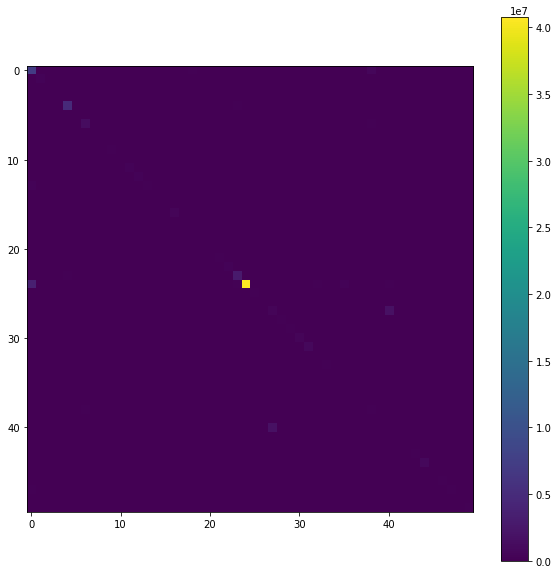

In [194]:
plt.figure(figsize=(10,10))
plt.imshow(df.apply(pd.to_numeric))
plt.colorbar()

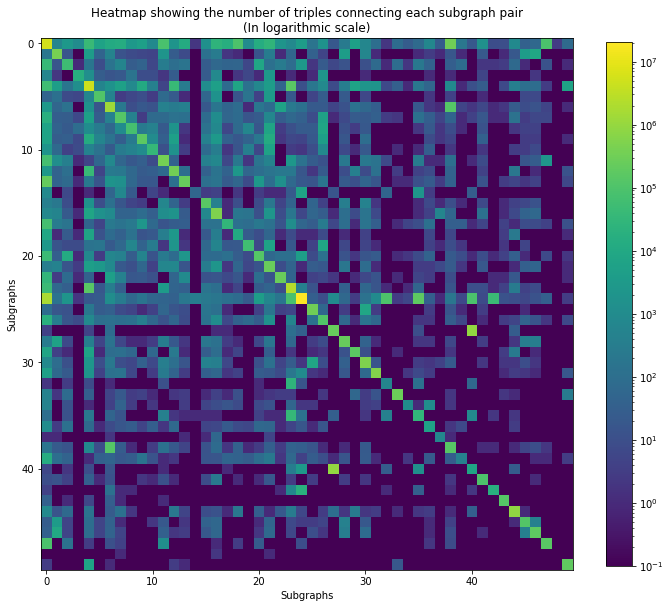

In [50]:
from pylab import figure, cm
from matplotlib.colors import LogNorm

plt.figure(figsize=(10,10))
heatmap = plt.imshow(df.apply(pd.to_numeric).replace(0, 0.1), norm=LogNorm())
plt.colorbar(heatmap, shrink=0.75)
plt.title("Heatmap showing the number of triples connecting each subgraph pair\n(In logarithmic scale)")
plt.xlabel("Subgraphs")
plt.ylabel("Subgraphs")
plt.tight_layout()
plt.savefig('subgraph_pair_triples.png')

# Subraph to WD and vice versa
Top 50 to/from full_subgraph/full_item

### From subgraph to all

In [339]:
from_subgraph = all_subgraphs.select("subgraph", "object").distinct().alias('all_subgraphs')\
                         .join(full_items.alias('full_items'), F.col('all_subgraphs.object') == F.col('full_items.item'), "inner")\
                         .selectExpr("all_subgraphs.subgraph as from_subgraph", "object","full_items.subgraph as to_subgraph")\
                         .distinct()\
                         .groupby(['from_subgraph', 'to_subgraph']).count()\
                         .sort('count', ascending=False)
from_subgraph.cache()
from_subgraph_df = from_subgraph.toPandas()

from_subgraph_df = pd.merge(from_subgraph_df, subgraph_size[['subgraph', 'label']], left_on='from_subgraph', right_on='subgraph')\
                     .drop(columns='subgraph').rename(columns={'label':'from_subgraph_label'})
from_subgraph_df = from_subgraph_df.sort_values('count', ascending=False)
from_subgraph_df.to_csv('from_subgraph_df.csv', index=False)

grouped_from_subgraph = from_subgraph_df[from_subgraph_df['from_subgraph'] != from_subgraph_df['to_subgraph']]\
                        .groupby(['from_subgraph', 'from_subgraph_label']).agg({'count':'sum'})
grouped_from_subgraph

count
from_subgraph                              from_subgraph_label                      
<http://www.wikidata.org/entity/Q101352>   family name                        131335
<http://www.wikidata.org/entity/Q11060274> print                               15651
<http://www.wikidata.org/entity/Q11173>    chemical compound                   43922
<http://www.wikidata.org/entity/Q11266439> Wikimedia template                   5541
<http://www.wikidata.org/entity/Q11424>    film                               256312
<http://www.wikidata.org/entity/Q13100073> village-level division in China     21301
<http://www.wikidata.org/entity/Q13406463> Wikimedia list article              60228
<http://www.wikidata.org/entity/Q13433827> encyclopedia article                90060
<http://www.wikidata.org/entity/Q13442814> scholarly article                 2612344
<http://www.wikidata.org/entity/Q16521>    taxon                              222453
<http://www.wikidata.org/entity/Q16970>    church building                    130706
<http://www.wikidata.org/entity/Q17633526> Wikinews article                     1390
<http://www.wikidata.org/entity/Q18593264> item of collection or exhibition     2890
<http://www.wikidata.org/entity/Q19389637> biographical article                95800
<http://www.wikidata.org/entity/Q21014462> cell line                           36656
<http://www.wikidata.org/entity/Q23397>    lake                                18479
<http://www.wikidata.org/entity/Q23442>    island                               7082
<http://www.wikidata.org/entity/Q2668072>  collection                           2656
<http://www.wikidata.org/entity/Q27020041> sports season                       28069
<http://www.wikidata.org/entity/Q30612>    clinical trial                      14511
<http://www.wikidata.org/entity/Q3305213>  painting                            90991
<http://www.wikidata.org/entity/Q3331189>  version, edition, or translation   117442
<http://www.wikidata.org/entity/Q355304>   watercourse                         11378
<http://www.wikidata.org/entity/Q3947>     house                               41473
<http://www.wikidata.org/entity/Q4022>     river                               31390
<http://www.wikidata.org/entity/Q41176>    building                            54121
<http://www.wikidata.org/entity/Q4164871>  position                            62599
<http://www.wikidata.org/entity/Q4167410>  Wikimedia disambiguation page      174948
<http://www.wikidata.org/entity/Q4167836>  Wikimedia category                 492710
<http://www.wikidata.org/entity/Q47150325> calendar day of a given year         6515
<http://www.wikidata.org/entity/Q47521>    stream                               5884
<http://www.wikidata.org/entity/Q482994>   album                               90024
<http://www.wikidata.org/entity/Q4830453>  business                            73460
<http://www.wikidata.org/entity/Q486972>   human settlement                    37192
<http://www.wikidata.org/entity/Q49008>    prime number                         5567
<http://www.wikidata.org/entity/Q5084>     hamlet                              28420
<http://www.wikidata.org/entity/Q532>      village                             91491
<http://www.wikidata.org/entity/Q54050>    hill                                12207
<http://www.wikidata.org/entity/Q56436498> village in India                      948
<http://www.wikidata.org/entity/Q59199015> group of stereoisomers              26703
<http://www.wikidata.org/entity/Q5>        human                             1234017
<http://www.wikidata.org/entity/Q61443690> branch post office                      7
<http://www.wikidata.org/entity/Q6999>     astronomical object                 10639
<http://www.wikidata.org/entity/Q7187>     gene                               956960
<http://www.wikidata.org/entity/Q7725634>  literary work                      109257
<http://www.wikidata.org/entity/Q79007>    street                              39089

### To subgraph from all

In [344]:
to_subgraph = full_subgraphs.select("subgraph", "object").distinct().alias('full_subgraphs')\
                         .join(all_items.alias('all_items'), F.col('full_subgraphs.object') == F.col('all_items.item'), "inner")\
                         .selectExpr("full_subgraphs.subgraph as from_subgraph", "object",
                                     "all_items.subgraph as to_subgraph")\
                         .distinct()\
                         .groupby(['from_subgraph', 'to_subgraph']).count()\
                         .sort('count', ascending=False)
to_subgraph.cache()
to_subgraph_df = to_subgraph.toPandas()

to_subgraph_df = pd.merge(to_subgraph_df, subgraph_size[['subgraph', 'label']], left_on='to_subgraph', right_on='subgraph')\
                    .drop(columns='subgraph').rename(columns={'label':'to_subgraph_label'})
to_subgraph_df = to_subgraph_df.sort_values('count', ascending=False)
to_subgraph_df.to_csv('to_subgraph_df.csv', index=False)

grouped_to_subgraph = to_subgraph_df[to_subgraph_df['from_subgraph'] != to_subgraph_df['to_subgraph']]\
                        .groupby(['to_subgraph', 'to_subgraph_label']).agg({'count':'sum'})
grouped_to_subgraph

count
to_subgraph                                to_subgraph_label                        
<http://www.wikidata.org/entity/Q101352>   family name                        481332
<http://www.wikidata.org/entity/Q11060274> print                                 469
<http://www.wikidata.org/entity/Q11173>    chemical compound                  187331
<http://www.wikidata.org/entity/Q11266439> Wikimedia template                   7137
<http://www.wikidata.org/entity/Q11424>    film                                26404
<http://www.wikidata.org/entity/Q13100073> village-level division in China    406403
<http://www.wikidata.org/entity/Q13406463> Wikimedia list article              99265
<http://www.wikidata.org/entity/Q13433827> encyclopedia article               113215
<http://www.wikidata.org/entity/Q13442814> scholarly article                 1914650
<http://www.wikidata.org/entity/Q16521>    taxon                              339224
<http://www.wikidata.org/entity/Q16970>    church building                     43903
<http://www.wikidata.org/entity/Q17633526> Wikinews article                      324
<http://www.wikidata.org/entity/Q18593264> item of collection or exhibition      547
<http://www.wikidata.org/entity/Q19389637> biographical article               101835
<http://www.wikidata.org/entity/Q21014462> cell line                           60949
<http://www.wikidata.org/entity/Q23397>    lake                                16537
<http://www.wikidata.org/entity/Q23442>    island                              12830
<http://www.wikidata.org/entity/Q2668072>  collection                           3658
<http://www.wikidata.org/entity/Q27020041> sports season                       19644
<http://www.wikidata.org/entity/Q30612>    clinical trial                        482
<http://www.wikidata.org/entity/Q3305213>  painting                            23478
<http://www.wikidata.org/entity/Q3331189>  version, edition, or translation    84053
<http://www.wikidata.org/entity/Q355304>   watercourse                         11105
<http://www.wikidata.org/entity/Q3947>     house                               10424
<http://www.wikidata.org/entity/Q4022>     river                               43242
<http://www.wikidata.org/entity/Q41176>    building                            20643
<http://www.wikidata.org/entity/Q4164871>  position                           150845
<http://www.wikidata.org/entity/Q4167410>  Wikimedia disambiguation page      195297
<http://www.wikidata.org/entity/Q4167836>  Wikimedia category                 501463
<http://www.wikidata.org/entity/Q47150325> calendar day of a given year         7044
<http://www.wikidata.org/entity/Q47521>    stream                               6202
<http://www.wikidata.org/entity/Q482994>   album                               63065
<http://www.wikidata.org/entity/Q4830453>  business                            81949
<http://www.wikidata.org/entity/Q486972>   human settlement                    78933
<http://www.wikidata.org/entity/Q49008>    prime number                         1494
<http://www.wikidata.org/entity/Q5084>     hamlet                              69989
<http://www.wikidata.org/entity/Q532>      village                            203375
<http://www.wikidata.org/entity/Q54050>    hill                                11564
<http://www.wikidata.org/entity/Q56436498> village in India                    42533
<http://www.wikidata.org/entity/Q59199015> group of stereoisomers             100827
<http://www.wikidata.org/entity/Q5>        human                             3321990
<http://www.wikidata.org/entity/Q61443690> branch post office                      3
<http://www.wikidata.org/entity/Q6999>     astronomical object                  4326
<http://www.wikidata.org/entity/Q7187>     gene                               974213
<http://www.wikidata.org/entity/Q7725634>  literary work                       65104
<http://www.wikidata.org/entity/Q79007>    street                              75460

In [350]:
len(from_subgraph_df), len(to_subgraph_df)

(6843, 7193)

## 90-0.5 rule rule in Wikidata (for items in subgraph with `P31`)

In [229]:
instance_pdf[instance_pdf['count']<10000]['count'].sum()*100/95000000,\
instance_pdf[instance_pdf['count']>=10000]['count'].sum()*100/95000000,\
top_instances['count'].sum()*100/95000000

(6.698298947368421, 95.35984315789473, 95.34931684210527)

In [231]:
len(instance_pdf[instance_pdf['count']<10000]), len(instance_pdf[instance_pdf['count']>=10000]), len(top_instances)

(82526, 393, 392)

In [232]:
len(instance_pdf)

82919

In [234]:
393/829.19, 82526/829.19

(0.473956511776553, 99.52604348822344)

# Days to Recover

In [7]:
subgraph_size = pd.read_csv('subgraph_size.csv')

In [8]:
subgraph_size['recover'] = (subgraph_size['triple_count']/4770000).round(2)
subgraph_size['item_percentage'] = subgraph_size['item_percentage'].round(2)
subgraph_size['triple_percentage'] = subgraph_size['triple_percentage'].round(2)
subgraph_size['triple_count'] = subgraph_size['triple_count'].apply(lambda x: format(x,','))
subgraph_size['item_count'] = subgraph_size['item_count'].apply(lambda x: format(x,',')) 

In [9]:
subgraph_size

subgraph subgraph_code  \
0   <http://www.wikidata.org/entity/Q13442814>     Q13442814   
1          <http://www.wikidata.org/entity/Q5>            Q5   
2       <http://www.wikidata.org/entity/Q6999>         Q6999   
3    <http://www.wikidata.org/entity/Q4167836>      Q4167836   
4      <http://www.wikidata.org/entity/Q16521>        Q16521   
5    <http://www.wikidata.org/entity/Q4167410>      Q4167410   
6      <http://www.wikidata.org/entity/Q11173>        Q11173   
7       <http://www.wikidata.org/entity/Q7187>         Q7187   
8       <http://www.wikidata.org/entity/Q8054>         Q8054   
9   <http://www.wikidata.org/entity/Q11266439>     Q11266439   
10  <http://www.wikidata.org/entity/Q13100073>     Q13100073   
11     <http://www.wikidata.org/entity/Q79007>        Q79007   
12    <http://www.wikidata.org/entity/Q486972>       Q486972   
13   <http://www.wikidata.org/entity/Q3305213>      Q3305213   
14      <http://www.wikidata.org/entity/Q8502>         Q8502   
15  <http://www.wikidata.org/entity/Q13433827>     Q13433827   
16   <http://www.wikidata.org/entity/Q2668072>      Q2668072   
17    <http://www.wikidata.org/entity/Q101352>       Q101352   
18      <http://www.wikidata.org/entity/Q4022>         Q4022   
19     <http://www.wikidata.org/entity/Q30612>        Q30612   
20  <http://www.wikidata.org/entity/Q13406463>     Q13406463   
21     <http://www.wikidata.org/entity/Q54050>        Q54050   
22  <http://www.wikidata.org/entity/Q17633526>     Q17633526   
23       <http://www.wikidata.org/entity/Q532>          Q532   
24    <http://www.wikidata.org/entity/Q482994>       Q482994   
25     <http://www.wikidata.org/entity/Q41176>        Q41176   
26     <http://www.wikidata.org/entity/Q11424>        Q11424   
27     <http://www.wikidata.org/entity/Q23397>        Q23397   
28     <http://www.wikidata.org/entity/Q16970>        Q16970   
29      <http://www.wikidata.org/entity/Q3947>         Q3947   
30   <http://www.wikidata.org/entity/Q4830453>      Q4830453   
31  <http://www.wikidata.org/entity/Q47150325>     Q47150325   
32    <http://www.wikidata.org/entity/Q355304>       Q355304   
33   <http://www.wikidata.org/entity/Q7725634>      Q7725634   
34  <http://www.wikidata.org/entity/Q27020041>     Q27020041   
35   <http://www.wikidata.org/entity/Q3331189>      Q3331189   
36      <http://www.wikidata.org/entity/Q9842>         Q9842   
37  <http://www.wikidata.org/entity/Q19389637>     Q19389637   
38     <http://www.wikidata.org/entity/Q23442>        Q23442   
39  <http://www.wikidata.org/entity/Q18593264>     Q18593264   
40    <http://www.wikidata.org/entity/Q811979>       Q811979   
41  <http://www.wikidata.org/entity/Q56436498>     Q56436498   
42  <http://www.wikidata.org/entity/Q61443690>     Q61443690   
43  <http://www.wikidata.org/entity/Q21014462>     Q21014462   
44     <http://www.wikidata.org/entity/Q49008>        Q49008   
45     <http://www.wikidata.org/entity/Q47521>        Q47521   
46   <http://www.wikidata.org/entity/Q4164871>      Q4164871   
47  <http://www.wikidata.org/entity/Q11060274>     Q11060274   
48      <http://www.wikidata.org/entity/Q5084>         Q5084   
49  <http://www.wikidata.org/entity/Q59199015>     Q59199015   

                               label  item_count   triple_count  \
0                  scholarly article  37,362,641  6,539,020,889   
1                              human   9,315,444    954,536,943   
2                astronomical object   8,412,914  1,136,682,291   
3                 Wikimedia category   4,840,195    753,127,982   
4                              taxon   3,180,248    367,926,462   
5      Wikimedia disambiguation page   1,359,804    180,124,174   
6                  chemical compound   1,223,387     91,228,463   
7                               gene   1,196,361    122,421,508   
8                            protein     986,599     88,483,828   
9                 Wikimedia template     845,852    114,308,711   
10   village-level division in China